In [1]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

### Loading the dinesafe data

In [2]:
datapath = r'../data/'

In [26]:
dfd = pd.read_csv(datapath + 'dinesafe.csv', parse_dates=['INSPECTION_DATE']).drop('Unnamed: 0', axis=1)
dfd.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED
0,1,1222579,103868579,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2016-12-21,M - Minor,Notice to Comply,,
1,2,1222579,104063869,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,NaN,2017-10-04,NaN,NaN,NaN,NaN
2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificat...,2018-06-20,NA - Not Applicable,Notice to Comply,,
3,4,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
4,5,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,


In [27]:
insp = dfd[['ESTABLISHMENT_ID', 'INSPECTION_DATE']].groupby('ESTABLISHMENT_ID').count().sort_values('INSPECTION_DATE', ascending=False)

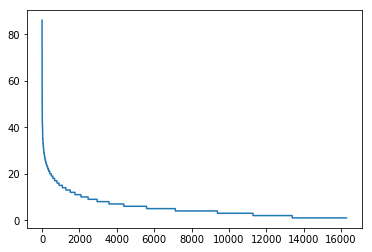

In [28]:
plt.plot(insp.values)
plt.show()

### Initial exploration

In [29]:
# Pass count
df_pass = dfd[['ESTABLISHMENT_STATUS', 'ROW_ID']].groupby('ESTABLISHMENT_STATUS').count()
df_pass['pct'] = df_pass['ROW_ID'] / df_pass['ROW_ID'].sum()
df_pass

,ROW_ID,pct
ESTABLISHMENT_STATUS,,
Closed,352,0.003889
Conditional Pass,17237,0.190422
Pass,72931,0.805689


min date: 2016-09-23
max date: 2018-09-21


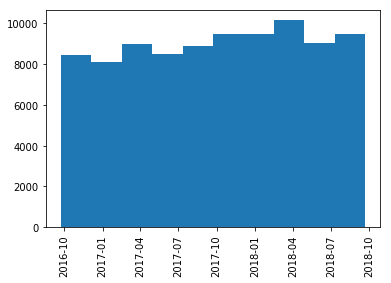

In [30]:
# time
plt.hist(dfd['INSPECTION_DATE'], bins=10)
plt.xticks(rotation='vertical')
print("min date: %s" % dfd['INSPECTION_DATE'].min().date())
print("max date: %s" % dfd['INSPECTION_DATE'].max().date())
plt.show()

In [31]:
# severity
df_severe = dfd[['SEVERITY', 'ROW_ID']].groupby('SEVERITY').count()
df_severe['pct'] = df_severe['ROW_ID'] / df_severe['ROW_ID'].sum()
df_severe

,ROW_ID,pct
SEVERITY,,
C - Crucial,2400,0.038899
M - Minor,32280,0.523194
NA - Not Applicable,4048,0.065610
S - Significant,22970,0.372297


### Fines

In [32]:
df_fined = dfd[(pd.notnull(dfd['AMOUNT_FINED'])) & (dfd['AMOUNT_FINED'] != ' ')].copy()
df_fined['COURT_OUTCOME'].unique()

array(['Conviction - Fined',
       'Conviction - Fined & Order to Close by Court',
       'Charges Withdrawn', 'Conviction - Suspended Sentence',
       'Charges Quashed'], dtype=object)

In [33]:
fine_map = {
    'Conviction - Fined': True,
    'Conviction - Fined & Order to Close by Court': True,
    'Charges Withdrawn': False, 
    'Conviction - Suspended Sentence': True,
    'Charges Quashed': False
}

In [34]:
df_fined['Convicted'] = df_fined['COURT_OUTCOME'].apply(lambda x: fine_map[x])
df_fined['dollar_amt'] = df_fined['AMOUNT_FINED'].apply(lambda x: float(x))

In [35]:
df_fined.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED,Convicted,dollar_amt
695,696,9001150,103920617,STARBUCKS,Restaurant,1088 YONGE ST,43.677997,-79.390257,Pass,1,Operate food premise - fail to keep facility s...,2017-02-28,M - Minor,Ticket,Conviction - Fined,65.00,True,65.0
853,854,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Fail to Hold a Valid Food Handler's Certificat...,2017-12-01,NA - Not Applicable,Ticket,Conviction - Fined,63.50,True,63.5
854,855,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operate food premise - fail to keep facility s...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
855,856,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operator fail to ensure room kept free from ma...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
858,859,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Store hazardous foods at internal temperature ...,2017-12-01,C - Crucial,Summons,Conviction - Fined,1130,True,1130.0


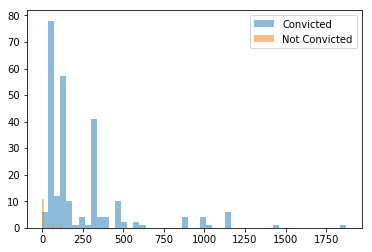

In [36]:
# any fines?
plt.hist(df_fined[df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Convicted', bins=50)
plt.hist(df_fined[~df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Not Convicted')
plt.legend()
plt.show()

In [37]:
dft = pd.read_pickle('univ/tor_rest.p')

In [38]:
dft.shape

(10914, 14)

### Joining

In [39]:
dfd = dfd.set_index('ROW_ID')

In [40]:
# converting all to lower case
dfd['name'] = dfd['ESTABLISHMENT_NAME'].apply(lambda x: x.lower())
dfd['address'] = dfd['ESTABLISHMENT_ADDRESS'].apply(lambda x: x.lower())
dft['name'] = dft['name'].apply(lambda x: x.lower())
dft['address'] = dft['address'].apply(lambda x: x.lower())

display(dfd[:1][['name', 'address']])
print(dfd.shape)

display(dft[:1][['name', 'address']])
print(dft.shape)

,name,address
ROW_ID,,
1,sai-lila khaman dhokla house,870 markham rd


(90520, 17)


,name,address
business_id,,
9A2quhZLyWk0akUetBd8hQ,bnc cake house,631 bloor st w


(10914, 14)


In [41]:
dfd.columns

Index(['ESTABLISHMENT_ID', 'INSPECTION_ID', 'ESTABLISHMENT_NAME',
       'ESTABLISHMENTTYPE', 'ESTABLISHMENT_ADDRESS', 'LATITUDE', 'LONGITUDE',
       'ESTABLISHMENT_STATUS', 'MINIMUM_INSPECTIONS_PERYEAR',
       'INFRACTION_DETAILS', 'INSPECTION_DATE', 'SEVERITY', 'ACTION',
       'COURT_OUTCOME', 'AMOUNT_FINED', 'name', 'address'],
      dtype='object')

In [42]:
# required combined address and name match score
CUT_OFF_SCORE = 0.8

total_count = dft.shape[0]
final_mapper = {}
for i, row in enumerate(dft.iterrows()):
    cur_bus_id = row[0]
    cur_name = row[1]['name']
    cur_addr = row[1]['address']
    print("processing (%s/%s) business: %s at address: %s with id: %s" % (i+1
                                                                          , total_count
                                                                          , cur_name
                                                                          , cur_addr
                                                                          , cur_bus_id))
    
    dfd['match_name'] = dfd['name'].apply(lambda x: fuzz.partial_ratio(x, cur_name))
    dfd['match_addr'] = dfd['address'].apply(lambda x: fuzz.partial_ratio(x, cur_addr))
    dfd['score'] = (dfd['match_name'] /  100) * (dfd['match_addr'] / 100)
    dfd = dfd.sort_values('score', ascending=False)
    if dfd['score'].values[0] > CUT_OFF_SCORE:
        print("\n!!! Found Match for \n(%s, %s) in the dinesafe db \n at (ROW_ID: %s, %s, %s)" % (cur_name
                                                                                       , cur_addr
                                                                                       , dfd.index[0]
                                                                                       , dfd['name'].values[0]
                                                                                       , dfd['address'].values[0]))
        final_mapper[cur_bus_id] = dfd.index[0]

# exporting
df_map = pd.DataFrame(final_mapper, index=['mapped_ROW_ID']).T
df_map.index.name = 'yelp_business_id'
df_map.to_pickle('univ/mapped_dinesafe.p')

processing (1/10914) business: bnc cake house at address: 631 bloor st w with id: 9A2quhZLyWk0akUetBd8hQ
processing (2/10914) business: thai one on at address: 3417 derry road e, unit 103 with id: 6OuOZAok8ikONMS_T3EzXg
processing (3/10914) business: southern accent restaurant at address: 595 markham street with id: tZnSodhPwNr4bzrwJ1CSbw
processing (4/10914) business: mabel's bakery at address: 746 street clair avenue w with id: 5J3b7j3Fzo9ISjChmoUoUA
processing (5/10914) business: the coffee mill restaurant at address: 99 yorkville avenue with id: PMDlKLd0Mxj0ngCpuUmE5Q
processing (6/10914) business: la rosa chilena at address: 788 wilson avenue with id: Be7Mwq06nf1eNLblo1ekow

!!! Found Match for 
(la rosa chilena, 788 wilson avenue) in the dinesafe db 
 at (ROW_ID: 5320, la rosa chilena bakery, 788 wilson ave )
processing (7/10914) business: allwyn's bakery at address: 81 underhill drive with id: YIez_A3WOt9J2SXN7OMa2Q

!!! Found Match for 
(allwyn's bakery, 81 underhill drive) in 

processing (50/10914) business: manhattan classic grill at address: 3200 dufferin st with id: k28OVH_iA7vI5dPtfNH2Zw
processing (51/10914) business: crews & tangos at address: 508 church street with id: wk6aHP-vxv9dhmmJVDWnPg
processing (52/10914) business: chipotle mexican grill at address: 25 the w mall, unit f012 with id: neBW0IYhxkj9zE7R4TA3BQ
processing (53/10914) business: irish potato nachos at address: 213 church st with id: E9K1wSwr-3y7TIaVaoa-9g
processing (54/10914) business: lick's homeburgers & ice cream at address: 43 milner avenue with id: CUtu_Y0_kXeAajLBBJUbPQ
processing (55/10914) business: subway at address: 19 glendinning avenue with id: n-htQX5fDg1VNiTKTJsu_w

!!! Found Match for 
(subway, 19 glendinning avenue) in the dinesafe db 
 at (ROW_ID: 60074, subway, 1 glendinning ave )
processing (56/10914) business: rolltation at address: 2291 yonge street with id: wL5yGvlL1zXZ4EPJ8d0hIA

!!! Found Match for 
(rolltation, 2291 yonge street) in the dinesafe db 
 at (ROW_I


!!! Found Match for 
(tim horton's, 2245 yonge street) in the dinesafe db 
 at (ROW_ID: 19915, tim hortons, 2245 yonge st )
processing (96/10914) business: subway at address: 727 queen street e with id: p6mnPa2-__9ttPTIfecc0Q

!!! Found Match for 
(subway, 727 queen street e) in the dinesafe db 
 at (ROW_ID: 23816, subway, 727 queen st e)
processing (97/10914) business: astra meat products at address: 2238 bloor street w with id: 1E1BN1eJQX7j6EdepVxoMQ
processing (98/10914) business: port 229 at address: 231 lakeshore road e with id: D_s16LOzlDkLwa4S8QPabw
processing (99/10914) business: kiku japanese cuisine at address: 808 york mills road with id: 5sKb4h7R5gdhePSflPD0Tw
processing (100/10914) business: delhi bistro at address: 2214 queen street e with id: UAXz2KC1aXpxzV-MLdXbmQ

!!! Found Match for 
(delhi bistro, 2214 queen street e) in the dinesafe db 
 at (ROW_ID: 37556, delhi bistro, 2214 queen st e)
processing (101/10914) business: tasty chinese restaurant at address: 997 eglin


!!! Found Match for 
(greenhouse juice, commerce court, 199 bay street) in the dinesafe db 
 at (ROW_ID: 59721, greenhouse juice co., 199 bay st )
processing (145/10914) business: tokyo sushi at address: 362 bloor street w with id: le1qCRgM-wtKvfeKClbnHQ
processing (146/10914) business: hakka no 1 restaurant 2 at address: 2355 keele street, unit 15 with id: r71RUi85E60aGuhVqXWjKA

!!! Found Match for 
(hakka no 1 restaurant 2, 2355 keele street, unit 15) in the dinesafe db 
 at (ROW_ID: 35683, hakka no 1 restaurant 2, 2355 keele st )
processing (147/10914) business: loblaws at address: 60 carlton street with id: 53GguDU6v46zPJTL3CZl5g

!!! Found Match for 
(loblaws, 60 carlton street) in the dinesafe db 
 at (ROW_ID: 40855, loblaws, 60 carlton st )
processing (148/10914) business: popeyes louisiana kitchen at address: 1975 weston rd with id: dpKY8_Rz1kofRBD8w_i_0A
processing (149/10914) business: west city snackbar at address: 430 horner avenue with id: Q6f-wJvMLbfcypKMJnad3w
processi

processing (194/10914) business: pour boy at address: 583 college street with id: 8ZpXbFWIY4uEnmOJMr6gyQ

!!! Found Match for 
(pour boy, 583 college street) in the dinesafe db 
 at (ROW_ID: 59372, pour boy, 583 college st )
processing (195/10914) business: blue goose tavern at address: 1 blue goose street with id: 1Ta487VlU6ceB0euIS9-EA

!!! Found Match for 
(blue goose tavern, 1 blue goose street) in the dinesafe db 
 at (ROW_ID: 16775, the blue goose tavern, 1 blue goose st )
processing (196/10914) business: brick house pizza co. at address: 111 queen street s with id: UCnPW3drq6wzO7ovAfxqEA
processing (197/10914) business: mitzie's jerk at address: 3337 bloor street w with id: W3K_5U2KEw0gxK7cvuB2mw

!!! Found Match for 
(mitzie's jerk, 3337 bloor street w) in the dinesafe db 
 at (ROW_ID: 34555, mitzie's jerk, 3337 bloor st w)
processing (198/10914) business: big al's flyin' phillys at address: kensington market, 251 augusta avenue with id: VM8LZTKqtprMEs0h3CDOXA
processing (199/1


!!! Found Match for 
(the captain's boil, 1800 the queensway, unit 5) in the dinesafe db 
 at (ROW_ID: 78700, the captain's boil, 1800 the queensway  )
processing (241/10914) business: granowska's bakery at address: 175 roncesvalles avenue with id: yS4H1eQBtWLmYlkTKVL6hg
processing (242/10914) business: adega restaurante at address: 33 elm st with id: 6eRSdODyj9GS0w6zlhrWkg

!!! Found Match for 
(adega restaurante, 33 elm st) in the dinesafe db 
 at (ROW_ID: 192, adega restaurant, 33 elm st )
processing (243/10914) business: bob's bulgogi at address: 105 victoria street with id: x4q_kJ-dvaHL7dkpZKJUdg

!!! Found Match for 
(bob's bulgogi, 105 victoria street) in the dinesafe db 
 at (ROW_ID: 40169, bob's bulgogi, 105 victoria st )
processing (244/10914) business: la tortilleria at address: 198 augusta ave with id: DLwpjhatiSRN7QqZQwokSw

!!! Found Match for 
(la tortilleria, 198 augusta ave) in the dinesafe db 
 at (ROW_ID: 87941, la tortilleria, 198 augusta ave )
processing (245/1091


!!! Found Match for 
(the grapefruit moon, 968 bathurst street) in the dinesafe db 
 at (ROW_ID: 39921, the grapefruit moon, 968 bathurst st )
processing (286/10914) business: sud forno at address: 132 yonge street with id: ryEwIARbKHvb0lCkAam8dQ
processing (287/10914) business: mister yummy at address: 2340 dundas street w with id: _hlNVsSGc2R9wT_cNBbFoQ

!!! Found Match for 
(mister yummy, 2340 dundas street w) in the dinesafe db 
 at (ROW_ID: 19716, mister yummy, 2340 dundas st w)
processing (288/10914) business: luce restaurant at address: 791 king street w with id: o7io7ITyHfjXOpxIktL0Bg
processing (289/10914) business: china garden restaurant at address: 7071 airport road with id: RJnikmkw2aW4gF2zcmxfvQ
processing (290/10914) business: apkujung restaurant at address: 6309 yonge st with id: s8qhewnW9LXH1WLFD3AbTw
processing (291/10914) business: quesada burritos & tacos at address: 234 wellington street w with id: t2eQcHc7WIlyKK8zFtY2Kw

!!! Found Match for 
(quesada burritos & t


!!! Found Match for 
(paradise fine chinese dining, 5505 leslie street) in the dinesafe db 
 at (ROW_ID: 26252, paradise fine chinese dining, 5505 leslie st )
processing (334/10914) business: roc'n doc's at address: 105 lakeshore road e with id: OyPWyqSC_dtLQsRJJhvlSQ
processing (335/10914) business: hitch at address: 1216 queen street e with id: dHI6YDCDuU5X9tS-3y0Bcg

!!! Found Match for 
(hitch, 1216 queen street e) in the dinesafe db 
 at (ROW_ID: 45184, hitch, 1216 queen st e)
processing (336/10914) business: nunu ethiopian fusion at address: 1178 queen street w with id: xfbjRpE3yhRQ9Zw-D_mBgQ

!!! Found Match for 
(nunu ethiopian fusion, 1178 queen street w) in the dinesafe db 
 at (ROW_ID: 30262, nunu, 1178 queen st w)
processing (337/10914) business: number one at address: 897 pape avenue with id: CyQXHdumQvxKAkXglORTdQ

!!! Found Match for 
(number one, 897 pape avenue) in the dinesafe db 
 at (ROW_ID: 46838, number one chinese restaurant, 897 pape ave )
processing (338/10914

processing (378/10914) business: john anderson's restaurant at address: 5653 yonge street with id: UUT3f05dbse6ar-2Ws5GUA
processing (379/10914) business: friendship restaurant at address: 2912 sheppard e avenue with id: ZU-J5OtfgdNm0uPdxYNoaQ

!!! Found Match for 
(friendship restaurant, 2912 sheppard e avenue) in the dinesafe db 
 at (ROW_ID: 3508, friendship restaurant, 2912 sheppard ave e)
processing (380/10914) business: pearl city at address: 4664 yonge street, unit 13 with id: wTMuxPmQtSALOoQiNq6dnw
processing (381/10914) business: bairrada churrasqueira grill at address: 33 hillcrest avenue with id: GheMvm_dgcBTULpwzNuyBg
processing (382/10914) business: wild wing at address: 666 millwood rd with id: Qk_g7_hCvXrtdv_XUlXXGg

!!! Found Match for 
(wild wing, 666 millwood rd) in the dinesafe db 
 at (ROW_ID: 47366, wild wing, 666 millwood rd )
processing (383/10914) business: manchu wok at address: 2300 yonge street, unit #s106 with id: XINxZ5fHTKq5eCq-z_KS8g

!!! Found Match for 


!!! Found Match for 
(aaamazing salad, 160 baldwin street, unit 2) in the dinesafe db 
 at (ROW_ID: 68408, aa amazing salad, 160 baldwin st )
processing (422/10914) business: mi'hito sushi laboratory at address: 285 college street with id: TKKX9bllRBMzp0NYr441PQ

!!! Found Match for 
(mi'hito sushi laboratory, 285 college street) in the dinesafe db 
 at (ROW_ID: 80919, mi'hito sushi laboratory, 285 college st )
processing (423/10914) business: pizza pizza at address: 208 queens quay w, unit 9 10 with id: uuDxjiidiIb6dTsV9edUTA

!!! Found Match for 
(pizza pizza, 208 queens quay w, unit 9 10) in the dinesafe db 
 at (ROW_ID: 33530, pizza pizza, 208 queens quay  w)
processing (424/10914) business: mac's sushi - fairview mall at address: 1800 sheppard avenue e with id: etzcNEVPuTvpnh8ew12W9g
processing (425/10914) business: national bakery & pastry at address: 812 college street with id: 1qqwHZ0Bf1f1O5CUjo3PnA

!!! Found Match for 
(national bakery & pastry, 812 college street) in the di

processing (468/10914) business: mirto italian restaurant & bar at address: 25 toronto st with id: tgZU8QAowa7V4Af6DV9UUg

!!! Found Match for 
(mirto italian restaurant & bar, 25 toronto st) in the dinesafe db 
 at (ROW_ID: 20761, mirto italian restaurant, 25 toronto st )
processing (469/10914) business: studio cafe at address: the four seasons, 21 avenue road with id: NFE_xumAFUYr-eV1mQsgJQ
processing (470/10914) business: astarté fresh yogurt bar at address: 150 king street w with id: pQ4K6ZXC2vGsatT5Xw3ILw

!!! Found Match for 
(astarté fresh yogurt bar, 150 king street w) in the dinesafe db 
 at (ROW_ID: 49917, astarte fresh yogurt bar, 150 king st w)
processing (471/10914) business: brownes bistro at address: 1251 yonge street with id: CrIQLWcvOYWDFAl-UWgkxw

!!! Found Match for 
(brownes bistro, 1251 yonge street) in the dinesafe db 
 at (ROW_ID: 38856, brownes bistro, 1251 yonge st )
processing (472/10914) business: jxy dumpling restaurant at address: 3250 midland avenue, unit 

processing (512/10914) business: mikasa japanese restaurant at address: 3330 pharmacy avenue with id: AfEUIbr8_urxI1efrqu0qg
processing (513/10914) business: abc bakery coffee shop at address: 3618 victoria park avenue with id: semizMsHqDfT_kOXQITSOA

!!! Found Match for 
(abc bakery coffee shop, 3618 victoria park avenue) in the dinesafe db 
 at (ROW_ID: 87271, abc bakery coffee shop, 3618 victoria park ave )
processing (514/10914) business: 241 pizza at address: 94 lakeshore road e with id: QnlSgDRrKzuZqe5VJzvBCw
processing (515/10914) business: select grill at address: 1250 south service road with id: GZdipYHpXO5FzMPUk_sy7A
processing (516/10914) business: striker at address: 31 st joseph street with id: 3HwLDQhV8nS4mgWFtRMA5A
processing (517/10914) business: maki my way at address: 7 king street e with id: JmKgz6n7zn24F-WkgT-kiA
processing (518/10914) business: louis cifer brew works at address: 417 danforth avenue with id: xpJEBXTCQh5Ib8BJrjt9Bg

!!! Found Match for 
(louis cifer 

processing (561/10914) business: modo mio italian bistro at address: 1923c avenue road with id: NvFpFlu-aHzUOtaA0yc-YA

!!! Found Match for 
(modo mio italian bistro, 1923c avenue road) in the dinesafe db 
 at (ROW_ID: 64516, modo mio italian bistro, 1923 avenue rd )
processing (562/10914) business: mii sandwich at address: 100 city centre drive with id: bBt-9dRev6C-hXQDxDGfUA
processing (563/10914) business: palermo bakery at address: 1084 st clair ave w with id: cPAVcmanexdCPzwGpy5ZVg

!!! Found Match for 
(palermo bakery, 1084 st clair ave w) in the dinesafe db 
 at (ROW_ID: 53026, palermo bakery, 1084 st clair ave w)
processing (564/10914) business: barburrito - gerrard at address: 1000 gerrard st e with id: i3oRRwl3RWOxKfTtiJbliw

!!! Found Match for 
(barburrito - gerrard, 1000 gerrard st e) in the dinesafe db 
 at (ROW_ID: 63736, barburrito, 1000 gerrard st e)
processing (565/10914) business: cafe gelato at address: 2494 yonge street with id: G1XEyjiV7QThOgSrHaDcRg
processing (5

processing (612/10914) business: cluck clucks at address: 222 the esplanade with id: Zq9WPT7ZAOYlQ0GV8OQWKQ

!!! Found Match for 
(cluck clucks, 222 the esplanade) in the dinesafe db 
 at (ROW_ID: 65776, cluck cluck's, 222 the esplanade  )
processing (613/10914) business: toffee cafe at address: 95 esther shiner blvd with id: kd8v68rmPA5KE9TtBx-4AA

!!! Found Match for 
(toffee cafe, 95 esther shiner blvd) in the dinesafe db 
 at (ROW_ID: 84073, toffee cafe, 95 esther shiner blvd )
processing (614/10914) business: raijin ramen at address: 24 wellesley street w with id: fJ-2acaqvWOsujUTAJB-ew
processing (615/10914) business: king slice at address: 1598 bloor st w with id: amsvLzfEvCzLwP0MnXAJ1w

!!! Found Match for 
(king slice, 1598 bloor st w) in the dinesafe db 
 at (ROW_ID: 35031, king slice pizza, 1598 bloor st w)
processing (616/10914) business: sushi shop at address: 65 front st w with id: c93AzlUc_j0C-lkWBG92Sw
processing (617/10914) business: quiznos sub at address: 100 welling


!!! Found Match for 
(creme de la creme cafe, 2991 bloor street w) in the dinesafe db 
 at (ROW_ID: 18982, creme de la creme cafe, 2991 bloor st w)
processing (658/10914) business: hcafe japanese cafe at address: 4750 yonge street, unit 119 with id: sizDIacOnwzgDjKuhyNZqw

!!! Found Match for 
(hcafe japanese cafe, 4750 yonge street, unit 119) in the dinesafe db 
 at (ROW_ID: 84093, hcafe, 4750 yonge st )
processing (659/10914) business: freshly squeezed at address: 100 city center drive with id: nogpz7Ebqc0ZIqX8cImdKg
processing (660/10914) business: food central at address: square one shopping centre, 100 city centre drive with id: 3Phhm4suJ-9fVakKXJSMxg
processing (661/10914) business: tokyo smoke found at address: 850b adelaide street w with id: 3SLMbM0m_9zQObNZ9gPoXg

!!! Found Match for 
(tokyo smoke found, 850b adelaide street w) in the dinesafe db 
 at (ROW_ID: 73460, tokyo smoke found, 850 adelaide st w)
processing (662/10914) business: magic oven at address: 798 danforth ave


!!! Found Match for 
(tim hortons, 2696-2708 keele street) in the dinesafe db 
 at (ROW_ID: 28188, tim hortons, 2708 keele st )
processing (700/10914) business: big fat burrito at address: 285 augusta avenue with id: arpBUwgiaE8iqfNGMQ_hgg

!!! Found Match for 
(big fat burrito, 285 augusta avenue) in the dinesafe db 
 at (ROW_ID: 23209, big fat burrito, 285 augusta ave )
processing (701/10914) business: millie creperie at address: 161 baldwin street with id: TR0-w6VoZDAdvFQiq7P2Ug

!!! Found Match for 
(millie creperie, 161 baldwin street) in the dinesafe db 
 at (ROW_ID: 48801, millie creperie, 161 baldwin st )
processing (702/10914) business: sushi & bento at address: 187 dundas street w with id: ZxwTs6uEDRnC-kNnsrDNsA

!!! Found Match for 
(sushi & bento, 187 dundas street w) in the dinesafe db 
 at (ROW_ID: 58634, torch sushi & bento japanese restaurant, 187 dundas st w)
processing (703/10914) business: sushiburri toronto at address:  with id: zy5UZvaG4iOLSbxuophtTQ
processing (7

processing (746/10914) business: thai one on at address: 861 york mills road with id: nvbfWYxTNq5XgJkcAPcXNQ

!!! Found Match for 
(thai one on, 861 york mills road) in the dinesafe db 
 at (ROW_ID: 73104, thai one on, 861 york mills rd )
processing (747/10914) business: tilde at address: 699 danforth avenue with id: nemcwBBzPuTbP9oKF9t_Jw
processing (748/10914) business: magic oven at address: 347 keele street with id: eQNApV0-OpYJec3y1OoBvg
processing (749/10914) business: pho my duyen at address: 1208 bloor street w with id: q7hgincxO4YwDPVcIzWPbg
processing (750/10914) business: the queen and beaver public house at address: 35 elm street with id: qaNt4vtVdge_S68DVjw5Jg

!!! Found Match for 
(the queen and beaver public house, 35 elm street) in the dinesafe db 
 at (ROW_ID: 29945, queen and beaver public house, 35 elm st )
processing (751/10914) business: asahi sushi at address: 640 church st with id: L4wjHHeoJ33KK59i3xpOqw

!!! Found Match for 
(asahi sushi, 640 church st) in the d


!!! Found Match for 
(faley restaurant, 62 overlea boulevard) in the dinesafe db 
 at (ROW_ID: 43458, faley restaurant, 62 overlea blvd )
processing (789/10914) business: the wren at address: 1382 danforth avenue with id: UkoseRjoLT4K2bEzvmyhYA

!!! Found Match for 
(the wren, 1382 danforth avenue) in the dinesafe db 
 at (ROW_ID: 52415, the wren, 1382 danforth ave )
processing (790/10914) business: taste of china at address: 338 spadina ave with id: _Ss4d4dYzehTmWJGpkqL7w

!!! Found Match for 
(taste of china, 338 spadina ave) in the dinesafe db 
 at (ROW_ID: 9928, taste of china seafood, 338 spadina ave )
processing (791/10914) business: villa sorrento restaurant at address: 1149 lakeshore road e with id: xN-7KyLu14SbbBEaQd4heQ
processing (792/10914) business: the public house gastropub at address: 751 queen street w with id: cXN64viNvfIqtw5fSOS7aw

!!! Found Match for 
(the public house gastropub, 751 queen street w) in the dinesafe db 
 at (ROW_ID: 74544, public house, 751 queen s


!!! Found Match for 
(hunters landing bar grill hub restaurant, 82 fort york blvd) in the dinesafe db 
 at (ROW_ID: 79732, hunters landing, 82 fort york blvd )
processing (831/10914) business: brazilian star bar & grill at address: 1242 dundas street w with id: FjHGjWZ6EAEioQWBUp7WZA
processing (832/10914) business: boots & bourbon saloon at address: 725 queen street e with id: LmXxzIkRDzAiVPztnkBb_w
processing (833/10914) business: café la gaffe at address: 24 baldwin street with id: jo4KmAqlZ7vxjHIP7IIkAw

!!! Found Match for 
(café la gaffe, 24 baldwin street) in the dinesafe db 
 at (ROW_ID: 63578, cafe la gaffe, 24 baldwin st )
processing (834/10914) business: salus fresh foods at address: 25 carlton street, unit d with id: xmSQ5Md_XNzPmSRkilo_2A

!!! Found Match for 
(salus fresh foods, 25 carlton street, unit d) in the dinesafe db 
 at (ROW_ID: 74554, salus, 25 carlton st )
processing (835/10914) business: nari sushi at address: 257 king street e with id: I3MpZ5YFmHe4gHgA0CRzpQ

processing (873/10914) business: golden sun and grill at address: 639 mccowan rd with id: 7O7Igq9MR4kg7GFflPWwuA
processing (874/10914) business: real fruit bubble tea at address: 100 city centre drive, unit 02-829 with id: Pj-SNqjFwu7zGUZLH-MhLg
processing (875/10914) business: bar b q tonite at address: 5165 dixie road with id: kb56PJRc9_Wtyp5ZCw1sVA
processing (876/10914) business: veggie planet at address: 6985 davand drive, suite 1 with id: BQsHIeY0x__B5IHyyQZ1ng
processing (877/10914) business: burrito boyz at address: 1736 queen street w with id: yrEhbjvGcODIH1OTVrc-IQ

!!! Found Match for 
(burrito boyz, 1736 queen street w) in the dinesafe db 
 at (ROW_ID: 56581, burrito boyz, 1736 queen st w)
processing (878/10914) business: patty king bakery at address: 321 progress avenue with id: 8HAsNLoSr3xi5rwQretp3w

!!! Found Match for 
(patty king bakery, 321 progress avenue) in the dinesafe db 
 at (ROW_ID: 7285, patty king, 321 progress ave )
processing (879/10914) business: il sogn

processing (917/10914) business: halal shamiana restaurant at address: 816 britannia road w, suite 101 with id: 3r5FidzFQ9rfAoQOtixfxA
processing (918/10914) business: arz fine foods at address: 1909 lawrence avenue e with id: Z2sf4YFtB_bCyDlqJIXJew

!!! Found Match for 
(arz fine foods, 1909 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 12792, arz fine food supermarket, 1909 lawrence ave e)
processing (919/10914) business: izakaya sushi house at address: 294 college street with id: s2RCw9-DB3r4XyUMxYiOKA
processing (920/10914) business: slack's music bar & lounge at address: 562 church st with id: 26_tunWERRkQBSBwtWoFTQ
processing (921/10914) business: number one at address: 862 pape avenue with id: 64Wt06TZjb9Se8q3kdeOJQ
processing (922/10914) business: ember hot stove & social house at address: 3039 lakeshore boulevard w with id: p83GTFKojvIwCFZEE7BE0Q
processing (923/10914) business: biryani corner at address: 40 dundas street w, unit 1 with id: nGGHX9HSHHWTyTCaPVxU7g
process

processing (962/10914) business: roux at address: 2790 dundas street w with id: -ClafaRWkSRTfieIzO4r3Q

!!! Found Match for 
(roux, 2790 dundas street w) in the dinesafe db 
 at (ROW_ID: 53922, roux bistro and bar, 2790 dundas st w)
processing (963/10914) business: souvlaki hut at address: 2184 bloor street w with id: HdA60YKlC1HQ7MfkMQIOew

!!! Found Match for 
(souvlaki hut, 2184 bloor street w) in the dinesafe db 
 at (ROW_ID: 59523, souvlaki hut, 2184 bloor st w)
processing (964/10914) business: queen slice at address: 177 college street with id: fBgUT-V7F66kNOkv56fCnA
processing (965/10914) business: the boiler house at address: 18 tank house lane with id: eUjDWzbQ6eLZy0uELEOa9Q
processing (966/10914) business: parallel at address: 217 geary avenue with id: Cx0o524EbpLh8Luvjx6DMw

!!! Found Match for 
(parallel, 217 geary avenue) in the dinesafe db 
 at (ROW_ID: 86743, parallel, 217 geary ave )
processing (967/10914) business: food studio cafe at address: 100 queen's park with id:


!!! Found Match for 
(taste of tandooree and sweets, 1330 gerrard street e) in the dinesafe db 
 at (ROW_ID: 54551, taste of tandooree, 1330 gerrard st e)
processing (1009/10914) business: saigon flower restaurant at address: 1138 queen street w with id: mt5kFJr1rOqIajMguELR9Q

!!! Found Match for 
(saigon flower restaurant, 1138 queen street w) in the dinesafe db 
 at (ROW_ID: 8523, saigon flower restaurant, 1138 queen st w)
processing (1010/10914) business: brickworks cider house at address: 709 queen street e with id: NYsh17F0sWm-e7fVdm2CSA

!!! Found Match for 
(brickworks cider house, 709 queen street e) in the dinesafe db 
 at (ROW_ID: 89241, brickworks cider house, 709 queen st e)
processing (1011/10914) business: z-teca at address: commerce court, 199 bay st with id: REbNih8rOHc63a7WRRKb3A
processing (1012/10914) business: tandoor express at address: 660 eglinton avenue west, unit 5b with id: L4q6PF-0Enef6gKsDB6EjA
processing (1013/10914) business: golden griddle restaurant at

processing (1052/10914) business: luma at address: 350 king street w, 2nd floor with id: UJevx59U-bi6fRADCSa7LQ
processing (1053/10914) business: coco fresh tea & juice at address: 630 bloor st w with id: TcHDo5zgp2n4k9tkO4EvuQ
processing (1054/10914) business: gateway of india at address: 19 baldwin st with id: t3pKESVSZ34J36XQIsiZ7g
processing (1055/10914) business: foxley bistro and bar at address: 207 ossington avenue with id: dy0O7DaSUd49NZWSEtvz_g

!!! Found Match for 
(foxley bistro and bar, 207 ossington avenue) in the dinesafe db 
 at (ROW_ID: 24680, foxley, 207 ossington ave )
processing (1056/10914) business: soho house toronto at address: 192 adelaide st w with id: lqagldgZR_GSZejz7xYogQ

!!! Found Match for 
(soho house toronto, 192 adelaide st w) in the dinesafe db 
 at (ROW_ID: 44016, soho house, 192 adelaide st w)
processing (1057/10914) business: that's greek cuisine at address: 1045 the queensway with id: xSCuXYDIRvwSnnCUHLQNzw
processing (1058/10914) business: china 


!!! Found Match for 
(when the pig came home, 3035 dundas street w) in the dinesafe db 
 at (ROW_ID: 74098, when the pig came home delicatessen, 3035 dundas st w)
processing (1100/10914) business: the spicy & delicious at address: 4664 yonge street, unit 13 with id: nFktMPlUZh06-dGTg4HdPw
processing (1101/10914) business: banh mi boys at address: 399 yonge street with id: ttuEwktrkmh3TUlSFPZqAA

!!! Found Match for 
(banh mi boys, 399 yonge street) in the dinesafe db 
 at (ROW_ID: 48185, banh mi boys, 399 yonge st )
processing (1102/10914) business: sushi style at address: 80a dundas street e with id: hAhvkwAjzvuzxrfu4XI_PA

!!! Found Match for 
(sushi style, 80a dundas street e) in the dinesafe db 
 at (ROW_ID: 49390, sushi style, 80 dundas st e)
processing (1103/10914) business: sora ethiopian restaurant at address: 1383 danforth avenue with id: -ZpPd7bY9ra553VoxXvYHw

!!! Found Match for 
(sora ethiopian restaurant, 1383 danforth avenue) in the dinesafe db 
 at (ROW_ID: 56318, sora

processing (1145/10914) business: toong at address: 5588 yonge street with id: Ielwatc9VDHFwSAgiK51ww
processing (1146/10914) business: lapaz batchoy toronto at address: 360 wilson avenue with id: 9MFcLXNi4pbqHsdrH9giZw

!!! Found Match for 
(lapaz batchoy toronto, 360 wilson avenue) in the dinesafe db 
 at (ROW_ID: 68120, la paz batchoy, 360 wilson ave )
processing (1147/10914) business: nest at address: 423 college street with id: pJ_dQ7qxZu-77e-MDU5DHg

!!! Found Match for 
(nest, 423 college street) in the dinesafe db 
 at (ROW_ID: 65139, nest, 423 college st )
processing (1148/10914) business: tofu village - house of soon tofu at address: 681 bloor street w with id: lVVJMvqu4LXL5rBqjO6eqg

!!! Found Match for 
(tofu village - house of soon tofu, 681 bloor street w) in the dinesafe db 
 at (ROW_ID: 33556, tofu village, 681 bloor st w)
processing (1149/10914) business: yumi japanese restaurant at address: 2384 bloor street w with id: tTx6Ac4yQWNnRW2qMHFztg
processing (1150/10914) bu

processing (1189/10914) business: blackjack bbq at address: 1044 gerrard st e with id: ZVCSVpPiBsw9Go7Sk3SHgQ

!!! Found Match for 
(blackjack bbq, 1044 gerrard st e) in the dinesafe db 
 at (ROW_ID: 89200, black jack bbq, 1044 gerrard st e)
processing (1190/10914) business: mitzi's on college at address: 890 college st with id: PFPUMF38-lraKzLcTiz5gQ
processing (1191/10914) business: ali baba's middle eastern cuisine at address: 2202 dundas street w with id: U_-j8L1rXbucWWZDLpYAAg

!!! Found Match for 
(ali baba's middle eastern cuisine, 2202 dundas street w) in the dinesafe db 
 at (ROW_ID: 31159, ali baba, 2202 dundas st w)
processing (1192/10914) business: chelo & co at address: 811 queen street w with id: iOTh1kL-UixifUBgn2-E2A
processing (1193/10914) business: pie squared at address: 366 bloor street e, unit 2 with id: UivDzG-AWhcfX-ADpg3Riw

!!! Found Match for 
(pie squared, 366 bloor street e, unit 2) in the dinesafe db 
 at (ROW_ID: 57512, pie squared restaurants, 366 bloor s

processing (1237/10914) business: randy's roti & doubles at address: 876 yonge street with id: jR-oxMOS9EpQ9enFTKuquQ

!!! Found Match for 
(randy's roti & doubles, 876 yonge street) in the dinesafe db 
 at (ROW_ID: 87554, randy's roti  & doubles , 876 yonge st )
processing (1238/10914) business: the keg steakhouse + bar - yonge + eglinton at address: 2201 yonge st with id: cicPsia8Wj-DNRkmLbD_xg

!!! Found Match for 
(the keg steakhouse + bar - yonge + eglinton, 2201 yonge st) in the dinesafe db 
 at (ROW_ID: 26553, the keg , 2201 yonge st )
processing (1239/10914) business: churrasqueira do sardinha at address: 707 college street w with id: JePdoHGJ2kWRQkfGx0T34Q

!!! Found Match for 
(churrasqueira do sardinha, 707 college street w) in the dinesafe db 
 at (ROW_ID: 28680, churrasqueira do sardinha, 707 college st )
processing (1240/10914) business: chino locos original at address: 4 greenwood avenue with id: a9aW5e731lplWGHUZ02-zQ

!!! Found Match for 
(chino locos original, 4 green

processing (1287/10914) business: zelden's deli and desserts at address: 1446 yonge street with id: _eRcc1OFDbi3fnVBskXP9g

!!! Found Match for 
(zelden's deli and desserts, 1446 yonge street) in the dinesafe db 
 at (ROW_ID: 83340, zelden's deli & desserts, 1446 yonge st )
processing (1288/10914) business: the longest yard restaurant at address: 535 mt pleasant road with id: ikQ7dbYDkTtg78Y5Y1DByA
processing (1289/10914) business: barburrito at address: 736 bay street with id: _BkpuQVbJTB6jht1eGvlNw
processing (1290/10914) business: 180 secondi at address: 21 saint clair avenue w, unit b with id: Erf_MwkL0Gls3tCJvz41-A
processing (1291/10914) business: big smoke burger at address: 260 yonge street with id: 0B3W6KxkD3o4W4l6cq735w
processing (1292/10914) business: sea witch fish and chips at address: 636 saint clair avenue w with id: If8BMnK0BFY213rOtxs9Yg
processing (1293/10914) business: sugo at address: 1279 bloor street  w with id: zEwQJl9haP5BYIl0peOpGA
processing (1294/10914) busi

processing (1335/10914) business: lola sushi at address: 2070 yonge street with id: R5ZvZ97FDp2bD93CNKg-zQ

!!! Found Match for 
(lola sushi, 2070 yonge street) in the dinesafe db 
 at (ROW_ID: 31004, lola sushi, 2070 yonge st )
processing (1336/10914) business: little caesars at address: 720 bristol road w with id: Ui0hzs2VFVMfa9B7xoJocg
processing (1337/10914) business: black skirt at address: 974 college street with id: PPrE3wc9hihGLQOX0Y6nvg
processing (1338/10914) business: john's classic pizza at address: 591 college st with id: zZ5EM6ON8l7R32HwDabd2Q
processing (1339/10914) business: swan dive at address: 1631 dundas street w with id: -smb9VnuwDyTeImkS8W5GQ

!!! Found Match for 
(swan dive, 1631 dundas street w) in the dinesafe db 
 at (ROW_ID: 76359, swan dive, 1631 dundas st w)
processing (1340/10914) business: st. louis bar & grill at address: 1963 queen st east, unit 11 with id: aXIJx_kxbmxUioM7Kcokow
processing (1341/10914) business: boneyard grill at address: 1554 avenue r

processing (1383/10914) business: pfannkuchen köln at address: 3345 yonge street with id: poD7wxQBqPi6FtHq1yPcgA
processing (1384/10914) business: anoush at address: canadian tire gas station, 5067 dixie road with id: 8jeFkySyEzLnsGYwZIeArw
processing (1385/10914) business: los guaca-moles at address: 690 euclid avenue with id: TVtnQyn3ka60r2t9xRwKPQ

!!! Found Match for 
(los guaca-moles, 690 euclid avenue) in the dinesafe db 
 at (ROW_ID: 72538, los guaca-moles, 690 euclid ave )
processing (1386/10914) business: xe lua vietnamese restaurant at address: 125 ravel road with id: tthxzfZu5z1ZYAV7-Um2tQ
processing (1387/10914) business: gyro bar! souvlaki kitchen at address: 1050 coxwell avenue with id: PMCKMRXChVsStf_uyRbKBQ

!!! Found Match for 
(gyro bar! souvlaki kitchen, 1050 coxwell avenue) in the dinesafe db 
 at (ROW_ID: 81757, gyro bar, 1050 coxwell ave )
processing (1388/10914) business: super baker at address: 1122b the queensway with id: hMkM4z0LYNgi29OcYrjGlg

!!! Found Match


!!! Found Match for 
(the calvin bar, 325 bay st) in the dinesafe db 
 at (ROW_ID: 56324, the calvin bar, 325 bay st )
processing (1427/10914) business: almanqal at address: 2075 danforth avenue with id: QVzZeu36KN7UNaFY6lBKuQ
processing (1428/10914) business: enigma cafe and restaurant at address: 1556 bloor street w with id: pks_z0EXHrxouKLKaMq1gw

!!! Found Match for 
(enigma cafe and restaurant, 1556 bloor street w) in the dinesafe db 
 at (ROW_ID: 87163, enigma, 1556 bloor st w)
processing (1429/10914) business: proof the vodka bar at address: 220 bloor street w with id: EVSfdVw1j-kr3Pn9K08Ruw
processing (1430/10914) business: mama's authentic caribbean restaurant at address: 349 marlee avenue with id: wFnMOhf51su_yIcHWdCeLw
processing (1431/10914) business: alborz restaurant at address: 5907 yonge street with id: qahnICF6MAmhkbuJvY4VfA
processing (1432/10914) business: boston pizza at address: 35 square one drive with id: D-Y4sRmHcpukcgKiiYOicA
processing (1433/10914) business: 


!!! Found Match for 
(round the horn, 331 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 78899, round the horn, 331 roncesvalles ave )
processing (1476/10914) business: kuni sushi ya at address: 20 baldwin st with id: kjZ7Mk1fvjgFCQxHpEn4hw

!!! Found Match for 
(kuni sushi ya, 20 baldwin st) in the dinesafe db 
 at (ROW_ID: 16950, kuni sushi-ya, 20 baldwin st )
processing (1477/10914) business: mandarin garden restaurant at address: 5463 yonge street with id: xGsMUrCRZImNks421EDyEg
processing (1478/10914) business: bibab express at address: 120 adelaide with id: We_Fci0vsWOekpAVIXKpSA

!!! Found Match for 
(bibab express, 120 adelaide) in the dinesafe db 
 at (ROW_ID: 59584, bibab express , 120 adelaide st w)
processing (1479/10914) business: pizza nova at address: 758 mt pleasant road with id: exawrYlJA4GKsGdqje2G-A

!!! Found Match for 
(pizza nova, 758 mt pleasant road) in the dinesafe db 
 at (ROW_ID: 64055, pizza nova, 758 mount pleasant rd )
processing (1480/10914) busin

processing (1518/10914) business: subway at address: 331 carlaw avenue, unit 103 with id: f8YPC7K4UUTkKatE5ga8Ig

!!! Found Match for 
(subway, 331 carlaw avenue, unit 103) in the dinesafe db 
 at (ROW_ID: 56345, subway, 321 carlaw ave )
processing (1519/10914) business: czehoski at address: 678 queen street w with id: 1DaqBYCDuBwooGNPRv4--g
processing (1520/10914) business: marish's boulangerie at address: 104 lakeshore rd e with id: r-YMM2Ibe80-APKShjo46A
processing (1521/10914) business: tutti frutti at address: 7 king st e with id: lTAkpHvhy7Z3mBjFODbXpA
processing (1522/10914) business: baddies at address: 679 lansdowne avenue with id: bbSb-uviEUNlCw1bitAmQg

!!! Found Match for 
(baddies, 679 lansdowne avenue) in the dinesafe db 
 at (ROW_ID: 74113, baddies toronto, 679 lansdowne ave )
processing (1523/10914) business: xin jiang barbecue restaurant at address: 3330 pharmacy avenue with id: LckZpP8V1F5zU5ZKVrhp2Q

!!! Found Match for 
(xin jiang barbecue restaurant, 3330 pharmacy 

processing (1565/10914) business: revitasize at address: 70 yorkville avenue with id: 56z-cq7L0MPE-nU9D-UEyQ

!!! Found Match for 
(revitasize, 70 yorkville avenue) in the dinesafe db 
 at (ROW_ID: 62391, revitasize, 70 yorkville ave )
processing (1566/10914) business: new york chicken at address: 1281 bloor street w with id: PaQ1345Hm9dW6f07TkyvUQ
processing (1567/10914) business: dominos' pizza at address: 4053 sheppard avenue e with id: 5wpy0z2KSF7buUtiCEquWg
processing (1568/10914) business: caribbean cuisine delights at address: 1700 av wilson with id: FJD0fCRufMkSECxFqiznyA
processing (1569/10914) business: jack astor's bar & grill at address: 580 progress avenue with id: 99p317EU5I0g4K8zHJD1ng

!!! Found Match for 
(jack astor's bar & grill, 580 progress avenue) in the dinesafe db 
 at (ROW_ID: 11973, jack astor's bar & grill, 580 progress ave )
processing (1570/10914) business: mcgugan's at address: 1058 gerrard street e with id: VZOQ2-cUP8bfCn7Q7ix9HQ
processing (1571/10914) b

processing (1609/10914) business: vinny massimo's pizza & pasta at address: 1130 queen street w with id: e1q9kpu9wzyFHLkKegf49w
processing (1610/10914) business: mcdonald's at address: 1168 st clair avenue w with id: 3vykxItKNuoeQjoYnATXpQ

!!! Found Match for 
(mcdonald's, 1168 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 6124, mcdonald's, 1168 st clair ave w)
processing (1611/10914) business: homestyle fish & chips at address: 1250 eglinton avenue w with id: EP-Nezgl7ydgjum1CYE3fg
processing (1612/10914) business: subway at address: 717 college street with id: ZX79Grup-CWl_juMTwBoQA

!!! Found Match for 
(subway, 717 college street) in the dinesafe db 
 at (ROW_ID: 72468, subway, 717 college st )
processing (1613/10914) business: south sea chinese foods at address: 1330 danforth avenue with id: YSaf1x4Ik6nH2GsIa2DCvg
processing (1614/10914) business: olympia grill at address: 1 derry road e with id: g0aAaIVeDE8PYjkN7-EHNw
processing (1615/10914) business: illstyl3 sammies at a


!!! Found Match for 
(jp sushi, 520 annette street) in the dinesafe db 
 at (ROW_ID: 74988, jp sushi, 520 annette st )
processing (1656/10914) business: pape sub & grill at address: 1048 av pape with id: qsk1dBYqagtFaf72Xyni3A
processing (1657/10914) business: the loaded dog at address: 1921 lawrence avenue e with id: mfBvrKeDYnwgHgWvmDMNgg
processing (1658/10914) business: pk creek bar & grill at address: 255 dundas street w with id: lkeBZEsJpD3JOqMb5bXsWg
processing (1659/10914) business: r&d restaurant at address: 241 spadina avenue with id: e178giuAicIhb16ymOtiBg

!!! Found Match for 
(r&d restaurant, 241 spadina avenue) in the dinesafe db 
 at (ROW_ID: 60576, r & d restaurant, 241 spadina ave )
processing (1660/10914) business: paramount fine foods at address: 253 yonge street with id: uthbVCNZqmExJTzhII9iNQ

!!! Found Match for 
(paramount fine foods, 253 yonge street) in the dinesafe db 
 at (ROW_ID: 65130, paramount fine foods, 253 yonge st )
processing (1661/10914) business: 


!!! Found Match for 
(mcdonald's, 1966 eglinton avenue e) in the dinesafe db 
 at (ROW_ID: 13589, mcdonald's, 1960 eglinton ave e)
processing (1702/10914) business: dazzling modern restaurant and bar at address: 291 king street w with id: PYfewaNPrfF3BDAVEqvR7A
processing (1703/10914) business: veda at address: 506 church street with id: a7ChC96ZIKh8xY7ugDPktQ
processing (1704/10914) business: constantinople bakery & coffee at address: 536 queen street w with id: L38gPrqPa4alEwnxoLUdAQ
processing (1705/10914) business: mama's boys burgers at address: 480 danforth road with id: SSCgpKNpco3l-YZ2MC-lMw

!!! Found Match for 
(mama's boys burgers, 480 danforth road) in the dinesafe db 
 at (ROW_ID: 41652, mama's boys burgers, 480 danforth rd )
processing (1706/10914) business: lotus inn at address: 286 eglinton avenue w with id: c1VhAIzfRqnYUao6RQmjQw
processing (1707/10914) business: leão d'ouro restaurant bar at address: 920 dundas street e with id: zVN7X8mIa24HDjF2NPlL4g
processing (170

processing (1748/10914) business: smoke's weinerie at address: 457 spadina avenue with id: 7T1XVTSocHcOu2H5v2Iqog
processing (1749/10914) business: snow time at address: 3290 midland avenue, unit 10 with id: G4pt2q9Tr5SkwCw3Wb43VA

!!! Found Match for 
(snow time, 3290 midland avenue, unit 10) in the dinesafe db 
 at (ROW_ID: 75183, snow time korean dessert cafe, 3290 midland ave )
processing (1750/10914) business: the cups at address: 5418 yonge street, suite 12 with id: z9SjyM0Ixr1ud8zI7Y93-A

!!! Found Match for 
(the cups, 5418 yonge street, suite 12) in the dinesafe db 
 at (ROW_ID: 74683, the cups, 5418 yonge st )
processing (1751/10914) business: falafel royal at address: 2836 lake shore boulevard w with id: 47R6die2A-Ft5tx2rYg-FA
processing (1752/10914) business: sakura garden at address: 1921 avenue road with id: Q8-4uLtLJeXHJZZsr2Zexw

!!! Found Match for 
(sakura garden, 1921 avenue road) in the dinesafe db 
 at (ROW_ID: 43310, sakura garden, 1921 avenue rd )
processing (175

processing (1792/10914) business: mickele's bistro at address: 5503 eglinton avenue w with id: Pnw5K6dsMh6Zn_q2qcpnnA
processing (1793/10914) business: pariwar restaurant at address: 1732 lawrence avenue e with id: CsQbzxZ275CXkndSo8gryQ

!!! Found Match for 
(pariwar restaurant, 1732 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 76142, pariwar restaurant, 1732 lawrence ave e)
processing (1794/10914) business: daddy o doughnuts and british baked goods at address: 589 n service road, unit 5 with id: cLPv_OR49siI6QVvN4g6Ew
processing (1795/10914) business: pumpernickel's deli at address: 5700 yonge street with id: EUb7dTcg6crsUTQqHK1tkw

!!! Found Match for 
(pumpernickel's deli, 5700 yonge street) in the dinesafe db 
 at (ROW_ID: 7933, pumpernickel's, 5700 yonge st )
processing (1796/10914) business: brick farm breakfast at address: 2116 danforth avenue with id: HSFUD5xNd5HKsXNt2uNy0Q

!!! Found Match for 
(brick farm breakfast, 2116 danforth avenue) in the dinesafe db 
 at (ROW_I


!!! Found Match for 
(eva's original chimneys, 454 bloor street w) in the dinesafe db 
 at (ROW_ID: 78295, eva's original chimney's, 454 bloor st w)
processing (1839/10914) business: golden crisp fish & chips at address: 1354 weston road with id: gh-nY0AZC7dVgDrXk5BpGw

!!! Found Match for 
(golden crisp fish & chips, 1354 weston road) in the dinesafe db 
 at (ROW_ID: 3818, golden crisp fish & chips, 1354 weston rd )
processing (1840/10914) business: fuzion 99 at address: 810 st. clair ave w with id: NGZoDem4-cULrT42kzTOXQ
processing (1841/10914) business: monami sushi at address: 378 oakwood avenue with id: 0_MI3uzOP0MMPNSfj5zB-g
processing (1842/10914) business: king's belly english pub at address: 429a donlands avenue with id: qKoKgOvfcdz4-GA1i1BA7Q

!!! Found Match for 
(king's belly english pub, 429a donlands avenue) in the dinesafe db 
 at (ROW_ID: 51034, king's belly, 429 donlands ave )
processing (1843/10914) business: european delight at address: st. lawrence market, 93 front


!!! Found Match for 
(asap city, 2075 danforth avenue) in the dinesafe db 
 at (ROW_ID: 72867, asap city, 2075 danforth ave )
processing (1885/10914) business: paris croissant bakery cafe at address: 595 bay street with id: Me7-yOkG9MDBQN1QNmiXmw
processing (1886/10914) business: the mountain grill and juice bar at address: 1996 lawrence avenue e with id: n-UVXXRQNVEiP6CRrmRAzw
processing (1887/10914) business: serious sandwiches at address: 30 eglinton avenue w with id: cyGpoXCS4RVib3vEDs-iMw
processing (1888/10914) business: jalapeno's mexican cuisine at address: 725 king st w with id: FrT9Ij-uK4yjesnIoGSJrw
processing (1889/10914) business: cleopatra at address: 977 bloor st w with id: fJAdog4HQMn1AruhiUnX_A
processing (1890/10914) business: bar hop at address: 391 king street w with id: fqBnZxSkG287OOyU9LvTig

!!! Found Match for 
(bar hop, 391 king street w) in the dinesafe db 
 at (ROW_ID: 44859, bar hop, 391 king st w)
processing (1891/10914) business: to tuck shop at address: 

processing (1932/10914) business: sunset grill at address: 2610 weston rd with id: QBEqnk76Q5N1on4LAry2_g

!!! Found Match for 
(sunset grill, 2610 weston rd) in the dinesafe db 
 at (ROW_ID: 41782, sunset grill, 2610 weston rd )
processing (1933/10914) business: shawarma house at address: 222 the esplanade with id: oiocguLkMNwH6gux2wxMfQ

!!! Found Match for 
(shawarma house, 222 the esplanade) in the dinesafe db 
 at (ROW_ID: 50000, shawarma house, 222 the esplanade  )
processing (1934/10914) business: international plaza hotel & conference centre at address: 655 dixon road with id: IbOrNwCdMTd-eicZ9B2CiA
processing (1935/10914) business: park hyatt toronto kosher annona restaurant at address: 4 avenue road with id: nER4r71-nLBpy4ZkrsAOYg
processing (1936/10914) business: emiliano & ana's no frills at address: 245 dixon road with id: F6WcodntQQ9clzAERXmAFA

!!! Found Match for 
(emiliano & ana's no frills, 245 dixon road) in the dinesafe db 
 at (ROW_ID: 45239, emiliano & ana's no fr


!!! Found Match for 
(new york fried chicken, 1 york gate blvd) in the dinesafe db 
 at (ROW_ID: 87922, new york fried chicken, 1 york gate blvd )
processing (1977/10914) business: kwan at york mills at address: 808 york mill road, unit 8 with id: F9h98ZFHLCHG7SdVbXMz0g

!!! Found Match for 
(kwan at york mills, 808 york mill road, unit 8) in the dinesafe db 
 at (ROW_ID: 69329, kwan at york mills, 808 york mills rd )
processing (1978/10914) business: pho bo to at address: 1635 lawrence avenue with id: ZHrZgkN4fgLzjCU_9a_Czw

!!! Found Match for 
(pho bo to, 1635 lawrence avenue) in the dinesafe db 
 at (ROW_ID: 11, pho bo to, 1635 lawrence ave w)
processing (1979/10914) business: da-maria pizzeria & spaghetti house at address: 4 kenwood avenue with id: iAdj2sx6LHWt6_zM7U3GLw
processing (1980/10914) business: tom jones steakhouse & seafood at address: 17 leader lane with id: pucWlGXJZ4kdAxQN2jkIpA

!!! Found Match for 
(tom jones steakhouse & seafood, 17 leader lane) in the dinesafe d


!!! Found Match for 
(windies, 3330 lawrence ave e) in the dinesafe db 
 at (ROW_ID: 22314, windies restaurant & sports bar, 3330 lawrence ave e)
processing (2019/10914) business: 9 restaurant at address: 9 roncesvalles avenue with id: Qtb4dHWSxOv8RjgBWrzukQ

!!! Found Match for 
(9 restaurant, 9 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 90363, sam's restaurant, 5 roncesvalles ave )
processing (2020/10914) business: canephora cafe & bakery at address: 222 finch avenue w, suite 101 with id: JD0Wod1xotR3LckHm-Ql8A

!!! Found Match for 
(canephora cafe & bakery, 222 finch avenue w, suite 101) in the dinesafe db 
 at (ROW_ID: 59116, canephora cafe & bakery, 222 finch ave w)
processing (2021/10914) business: morso me at address: 850 king street w with id: 8pGD3zt6HEL2xzaT3lqMFQ

!!! Found Match for 
(morso me, 850 king street w) in the dinesafe db 
 at (ROW_ID: 81880, morso me, 850 king st w)
processing (2022/10914) business: crown prince fine dining & banquet at address: 3600 

processing (2060/10914) business: caribbean queen roti hut at address: 2957 lake shore boulevard w with id: gQjSMZYAeJalH6nNfj6Gtw

!!! Found Match for 
(caribbean queen roti hut, 2957 lake shore boulevard w) in the dinesafe db 
 at (ROW_ID: 1573, caribbean queen roti hut, 2957 lake shore blvd w)
processing (2061/10914) business: divino at address: 1 balmoral avenue with id: lRidtP8BPrIy7QvFCWpDpg
processing (2062/10914) business: cinquecento trattoria at address: liberty village, 109 atlantic ave with id: 0Ovh4Vn9ntMt5Ara-ZP2sA
processing (2063/10914) business: fueled espresso and freshbar at address: 739 ossington avenue with id: 2eU7ltXoQ2U7SyLhuY9Vxw
processing (2064/10914) business: bakery on the go at address: 819 bathurst st with id: zjFKwcCpwGbHMFtvXgbsCw

!!! Found Match for 
(bakery on the go, 819 bathurst st) in the dinesafe db 
 at (ROW_ID: 12688, bakery on the go, 819 bathurst st )
processing (2065/10914) business: chipotle mexican grill at address: 123 front st, unit 103 


!!! Found Match for 
(mcdonald's, 1735 danforth avenue) in the dinesafe db 
 at (ROW_ID: 51972, mcdonald's, 1735 danforth ave )
processing (2105/10914) business: 241 pizza at address: 1055 bloor street with id: ng93vMQLaUwLCvsz5t06tQ
processing (2106/10914) business: yes to fresh at address: 41 jarvis street, unit 3 with id: nfT1yN0oDleBlDsP-c1MRw
processing (2107/10914) business: frank's pizza house restaurant at address: 1352 st clair avenue w with id: W8Rv62fsDCbDp0L-Vl1NFg
processing (2108/10914) business: one of a kind at address: 746 queen street w with id: KBQcNy9k9G8_a5WtrVGH8w
processing (2109/10914) business: marshmallow factory at address: 709 danforth avenue with id: 4eqq8XF5H8E9-Q2X2KVbbw
processing (2110/10914) business: the lockhart at address: 1479 dundas street w with id: 3-A-wVAkoyz39nSHaExpLw

!!! Found Match for 
(the lockhart, 1479 dundas street w) in the dinesafe db 
 at (ROW_ID: 65575, the lockhart, 1479 dundas st w)
processing (2111/10914) business: noodle wok 


!!! Found Match for 
(bazara asian cuisine, 188 ossington avenue) in the dinesafe db 
 at (ROW_ID: 46192, bazara, 188 ossington ave )
processing (2153/10914) business: quinn's steakhouse & irish bar at address: the sheraton centre, 96 richmond st w with id: Vf_RHj0f1VViEF6OYnEfUA
processing (2154/10914) business: pumpernickel's at address: 2200 eglington ave w with id: h0bEgEMiUzU780Ib2q6aPQ
processing (2155/10914) business: la boheme at address: 2481 yonge street with id: P53-vcUZne1L1CNElu9m-g

!!! Found Match for 
(la boheme, 2481 yonge street) in the dinesafe db 
 at (ROW_ID: 71656, la boheme, 2431 yonge st )
processing (2156/10914) business: messini authentic gyros at address: 445 danforth avenue with id: MhiBpIBNTCAm1Xd3WzRzjQ

!!! Found Match for 
(messini authentic gyros, 445 danforth avenue) in the dinesafe db 
 at (ROW_ID: 15266, messini authentic gyros, 445 danforth ave )
processing (2157/10914) business: lee kitchen at address: t1 international gate e73, 3111 convair drive

processing (2196/10914) business: palm lane at address: 55 avenue road, upper level with id: c-N5b3LFflVwPwqwijVwSw
processing (2197/10914) business: boston pizza at address: 2915 eglinton avenue w with id: u_qlVDjGI8vVh4SXEVW1PQ
processing (2198/10914) business: the arkadia house restaurant at address: 2007 eglinton ave e with id: gvoe0Z2Y_2i4m7vJGiJXHg
processing (2199/10914) business: real fruit bubble tea at address: 660 bloor st w with id: gJGu5fH5hMijxYa83EoLDQ

!!! Found Match for 
(real fruit bubble tea, 660 bloor st w) in the dinesafe db 
 at (ROW_ID: 31601, real fruit bubble tea, 660 bloor st w)
processing (2200/10914) business: jack astor's bar & grill at address: 1060 don mills road with id: lOgybcjtSymXvJWvSZk1vw

!!! Found Match for 
(jack astor's bar & grill, 1060 don mills road) in the dinesafe db 
 at (ROW_ID: 27500, jack astor's bar & grill, 1090 don mills rd )
processing (2201/10914) business: white squirrel snack shop at address: 507 queen street w with id: TjgUGNiv

processing (2241/10914) business: courthouse at address: 57 adelaide street e with id: 3xO9ktZQVOkK6u6i2IVNCw
processing (2242/10914) business: starving artist at address: 1078 st clair ave w with id: zo_z6lMRcwHqQF_Z1VZLpg

!!! Found Match for 
(starving artist, 1078 st clair ave w) in the dinesafe db 
 at (ROW_ID: 52320, starving artist, 1078 st clair ave w)
processing (2243/10914) business: rosina at address: 740 king street w with id: o954oK-S2OxH-OaBc7f0UQ

!!! Found Match for 
(rosina, 740 king street w) in the dinesafe db 
 at (ROW_ID: 86125, rosina, 740 king st w)
processing (2244/10914) business: duffy's diner at address: 1236 bloor street w with id: deXHtVOMmihQ3lD5OV1fKA
processing (2245/10914) business: shallow groove lounge at address: 559 college street with id: ZAw8PJAopCs-Rd1X8Y4xGQ
processing (2246/10914) business: bashu sichuan at address: 4559 hurontario street, suite a-7a with id: B41kSVjdFOwOrZTuJaTF7g
processing (2247/10914) business: zeller's family diner at addr


!!! Found Match for 
(the burrito house, 818 danforth avenue) in the dinesafe db 
 at (ROW_ID: 70819, the burrito house, 818 danforth ave )
processing (2285/10914) business: maru & maru sake bar at address: 5347 yonge street with id: 23Dg53bT4WIJDK26WPR7vQ
processing (2286/10914) business: fahmee bakery & jamaican foods at address: 119 montezuma trail with id: UCKeRO02Er8AHLWQlQ3IuA

!!! Found Match for 
(fahmee bakery & jamaican foods, 119 montezuma trail) in the dinesafe db 
 at (ROW_ID: 3073, fahmee bakery & jamaican foods, 119 montezuma trl )
processing (2287/10914) business: strange love at address: 1055 yonge street with id: v4JcQnYG46oEj_xFyOW4mg
processing (2288/10914) business: chipotle mexican grill at address: 319 queen street west with id: dH5tXaMTuyWQ21z53OeqbA

!!! Found Match for 
(chipotle mexican grill, 319 queen street west) in the dinesafe db 
 at (ROW_ID: 81663, chiptole mexican grill, 319 queen st w)
processing (2289/10914) business: avani asian indian bistro at a


!!! Found Match for 
(california sandwiches, 435 yonge street) in the dinesafe db 
 at (ROW_ID: 54335, california sandwiches, 435 yonge st )
processing (2328/10914) business: baton rouge at address: 5000 yonge street, unit 102 with id: JhH2-Vcvc36qedE2UYvhTQ

!!! Found Match for 
(baton rouge, 5000 yonge street, unit 102) in the dinesafe db 
 at (ROW_ID: 61081, baton rouge, 5000 yonge st )
processing (2329/10914) business: diwan at address: aga khan museum, 77 wynford drive with id: we2gims2_S_Sg5_JSBoHKg

!!! Found Match for 
(diwan, aga khan museum, 77 wynford drive) in the dinesafe db 
 at (ROW_ID: 67082, diwan restaurant, 77 wynford dr )
processing (2330/10914) business: twilight family restaurant & bar at address: 12-55 nugget avenue with id: 1ygl2K40akubzIK6dGvQ_A

!!! Found Match for 
(twilight family restaurant & bar, 12-55 nugget avenue) in the dinesafe db 
 at (ROW_ID: 33072, twilight family restaurant & bar, 55 nugget ave )
processing (2331/10914) business: call a chicken a


!!! Found Match for 
(united bakers dairy restaurant, 506 lawrence avenue w) in the dinesafe db 
 at (ROW_ID: 11187, united bakers dairy restaurant, 506 lawrence ave w)
processing (2371/10914) business: heart at address: 2322 bloor street w with id: Eoa7Rcm1QbQSlm189p_-nw
processing (2372/10914) business: fresh pizza plus at address: 2240 lake shore boulevard w, unit 104 with id: rIT-2aXUkBFeDBHjAz24Vw

!!! Found Match for 
(fresh pizza plus, 2240 lake shore boulevard w, unit 104) in the dinesafe db 
 at (ROW_ID: 45021, fresh pizza plus, 2240 lake shore blvd w)
processing (2373/10914) business: dark horse espresso bar at address: 120 geary avenue with id: fCaytcVvHe5kLA9cE8xBoA
processing (2374/10914) business: le ti colibri at address: 291 augusta avenue with id: VJJveoWmlHroqnRR18K7sA
processing (2375/10914) business: aroma espresso bar at address: 383 spadina road with id: opPyCLGr0_Ne7KtropMMCQ

!!! Found Match for 
(aroma espresso bar, 383 spadina road) in the dinesafe db 
 at (R

processing (2417/10914) business: gino's pizza & wing machine at address: 2387 yonge street with id: DtzDpAflD41-rI6njywacw

!!! Found Match for 
(gino's pizza & wing machine, 2387 yonge street) in the dinesafe db 
 at (ROW_ID: 49135, gino's pizza/wing machine, 2387 yonge st )
processing (2418/10914) business: bow bulgogi house at address: 4002 sheppard avenue e with id: 82uTKEiIW8yqTPZFEfP1Xg

!!! Found Match for 
(bow bulgogi house, 4002 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 27200, bow bulgogi house, 4002 sheppard ave e)
processing (2419/10914) business: forno cultura at address: 609 king street w with id: ErTB7R4rJNUUV8nsUVG26Q

!!! Found Match for 
(forno cultura, 609 king street w) in the dinesafe db 
 at (ROW_ID: 46807, forno cultura, 609 king st w)
processing (2420/10914) business: paul's spaghetti at address: 488 cosburn avenue with id: l7bLPv5G6JwOySt8Wo7xkg

!!! Found Match for 
(paul's spaghetti, 488 cosburn avenue) in the dinesafe db 
 at (ROW_ID: 54018, paul'

processing (2462/10914) business: domino's pizza at address: 354 oakwood avenue with id: Fgg6-Jo9STNpb6L7V7A4xA

!!! Found Match for 
(domino's pizza, 354 oakwood avenue) in the dinesafe db 
 at (ROW_ID: 36017, domino's pizza, 354 oakwood ave )
processing (2463/10914) business: pita land at address: 246 king st e with id: L0T0tx47qXd15FOrLoKUng

!!! Found Match for 
(pita land, 246 king st e) in the dinesafe db 
 at (ROW_ID: 88696, pita land , 246 king st e)
processing (2464/10914) business: wendy's at address: 5961 hurontario street with id: 7fSE99-qeIVXpkbNkheeHg
processing (2465/10914) business: city fried chicken at address: 2665 lawrence avenue e with id: JTIbsAs3qUq-0bNIh404ng

!!! Found Match for 
(city fried chicken, 2665 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 57587, city fried chicken (scarborough), 2655 lawrence ave e)
processing (2466/10914) business: szechuan express at address: 200 bay st, south tower, concourse level with id: 8Sqd1E8Jhjt3pbsoyOZ4dQ

!!! Found

processing (2509/10914) business: laide at address: 138 adelaide street e with id: l-JxbU1hzQNAmaHt-CBORw

!!! Found Match for 
(laide, 138 adelaide street e) in the dinesafe db 
 at (ROW_ID: 25749, richmond adelaide child care centre, 130 adelaide st w)
processing (2510/10914) business: la petite france at address: 3317 bloor st w with id: wf6cEXlL1qkNGH0-_CjKMw
processing (2511/10914) business: sugary swirls at address: 1087 bathurst street with id: yTpJHRqrhIG6xV84UCk_qQ
processing (2512/10914) business: chipotle mexican grill at address: 100 city centre dr, fcu-3, ste 1-829 with id: A8MmwHrMI0WnRTyQMdf8aQ
processing (2513/10914) business: saigon bangkok restaurant at address: 2416 st clair avenue west with id: cniVq1lxQood4a5XnTsvhw
processing (2514/10914) business: flour studio at address: 883 eglinton avenue w with id: 8yc5EEe3dSYlRJYoiRwccA
processing (2515/10914) business: the belsize public house at address: 535 mt. pleasant road. with id: ndgnPEeRSztiigwNW2IuBg

!!! Found Mat

processing (2554/10914) business: state & main at address: 396 the east mall, bldg c with id: AMug9zQbMrdw7aM1EaMDsw

!!! Found Match for 
(state & main, 396 the east mall, bldg c) in the dinesafe db 
 at (ROW_ID: 81118, state & main kitchen & bar, 396 the east mall  )
processing (2555/10914) business: the bagel stop yonge eglinton centre at address: 2300 yonge st with id: aY26EcqiP-AbcKTn23PqpQ

!!! Found Match for 
(the bagel stop yonge eglinton centre, 2300 yonge st) in the dinesafe db 
 at (ROW_ID: 20392, the bagel stop, 2300 yonge st )
processing (2556/10914) business: mary browns chicken & taters at address: 45 queen street north with id: Cox5cbNF0f6XdubKAHqghA
processing (2557/10914) business: hero certified burgers - yonge & sheppard at address: 4698 yonge street with id: wwo-34hVqKcZ5J8pMoxdVA

!!! Found Match for 
(hero certified burgers - yonge & sheppard, 4698 yonge street) in the dinesafe db 
 at (ROW_ID: 65489, hero certified burgers, 4698 yonge st )
processing (2558/1091


!!! Found Match for 
(tim horton's, 335 parliament) in the dinesafe db 
 at (ROW_ID: 32702, tim hortons, 335 parliament st )
processing (2598/10914) business: hannah's kitchen at address: 2177 yonge street with id: yRqMaiW2BQNG-mo-9pljnA
processing (2599/10914) business: siam princess at address: 3039 lake shore blvd w with id: 9vXD2kWaqsfGOPglp6rM6g
processing (2600/10914) business: mcdonald's at address: 1000 gerrard street e with id: slU5UwPlYVyrz7HhQeqMew

!!! Found Match for 
(mcdonald's, 1000 gerrard street e) in the dinesafe db 
 at (ROW_ID: 45764, mcdonald's, 1000 gerrard st e)
processing (2601/10914) business: insadong at address: 4941 dundas street w with id: SYFU8LFTa9Oy6UHtxeyvsA

!!! Found Match for 
(insadong, 4941 dundas street w) in the dinesafe db 
 at (ROW_ID: 68712, insadong, 4941 dundas st w)
processing (2602/10914) business: kinka izakaya original at address: 398 church st with id: RtUvSWO_UZ8V3Wpj0n077w

!!! Found Match for 
(kinka izakaya original, 398 church st


!!! Found Match for 
(ho jan chinese restaurant, 45 carlton st) in the dinesafe db 
 at (ROW_ID: 30205, ho jan chinese restaurant, 45 carlton st )
processing (2646/10914) business: sparrow at address: 2197 bloor street w with id: x_1Yo9ArcbitR6NQC7tOUA
processing (2647/10914) business: cafe cinquecento at address: 791 king street w with id: Zuwzb89m5JfOGyPgknSbCQ
processing (2648/10914) business: bar verde at address: 260 yonge street with id: swM_9CXxkvxEk3fDkjA6PQ
processing (2649/10914) business: allan's pastry shop at address: peanut plaza, 3064 don mills rd with id: WLmKPfI_MKRw0xQ-9sy9Gg

!!! Found Match for 
(allan's pastry shop, peanut plaza, 3064 don mills rd) in the dinesafe db 
 at (ROW_ID: 52677, allan's pastry shop, 3064 don mills rd e)
processing (2650/10914) business: al mustafa catering at address: 558 lakeshore road e with id: pJXhUly8CcrYan9FOrrjow
processing (2651/10914) business: club cayo coco at address: 304 richmond street w with id: zY4P1gScsqbo-dd4WGxxtA
proce


!!! Found Match for 
(creeds coffee bar, 1595 bayview ave) in the dinesafe db 
 at (ROW_ID: 89228, creeds coffee bar, 1595 bayview ave )
processing (2692/10914) business: ing's thai bowl at address: 55 university ave with id: 4ZRd3oBKR6z1Fk4C25aD-A

!!! Found Match for 
(ing's thai bowl, 55 university ave) in the dinesafe db 
 at (ROW_ID: 33943, thai bowl, 55 university ave )
processing (2693/10914) business: rudolph's bakeries at address: 390 alliance avenue with id: W81QagPKS7V2n6RM9gKn8w
processing (2694/10914) business: go lounge at address: 1718 queen street w with id: t_HhQtNpKvgQrSLvK0eUEA
processing (2695/10914) business: mr sub at address: 2650 avenue lawrence e with id: -MuW_FZPZOIbf9rwsT_Gyg
processing (2696/10914) business: wilder foods at address: 382 keele street with id: j_BZ2A5XEQSd-k7yH-S_Pw

!!! Found Match for 
(wilder foods, 382 keele street) in the dinesafe db 
 at (ROW_ID: 81601, wilder, 382 keele st )
processing (2697/10914) business: the fat belgian restaurant 


!!! Found Match for 
(solmaz food, 16 jutland road) in the dinesafe db 
 at (ROW_ID: 76107, solmaz foods, 16 jutland rd )
processing (2740/10914) business: jack astor's bar & grill at address: 133 john street with id: qcDFrv2EQU9GeIAAVqdA-g

!!! Found Match for 
(jack astor's bar & grill, 133 john street) in the dinesafe db 
 at (ROW_ID: 27033, jack astor's, 133 john st )
processing (2741/10914) business: kanji sushi at address: 1346 queen street w with id: 4izLezuABxOQUylmVenjHw
processing (2742/10914) business: yummy zone at address: 895 bay street with id: sXKDj1yjfWkwhx5AxrgdBw

!!! Found Match for 
(yummy zone, 895 bay street) in the dinesafe db 
 at (ROW_ID: 62420, yummy zone taiwanese restaurant, 879 bay st )
processing (2743/10914) business: mashu mashu mediterranean grill at address: 387 spadina road with id: QTVvuhrbBDJfqaTyFOUMkw

!!! Found Match for 
(mashu mashu mediterranean grill, 387 spadina road) in the dinesafe db 
 at (ROW_ID: 57609, mashu mashu, 387 spadina rd )
pr

processing (2787/10914) business: isis mediterranean cuisine at address: 17 queen street north with id: dJuSgVJrMAETzh83EJG72w
processing (2788/10914) business: biggu sushi house at address: 4664 yonge street with id: 8O7nxCcZ_C28i955kXwzGA

!!! Found Match for 
(biggu sushi house, 4664 yonge street) in the dinesafe db 
 at (ROW_ID: 73840, biggu sushi house, 4664 yonge st )
processing (2789/10914) business: the thai grill at address: 1959 queen street e with id: 3m5Bh1AoDIDY4OwNadqSnw
processing (2790/10914) business: atlas espresso bar at address: 550 front street w, unit 59 with id: t72DAe7q5iaQLlQrdgpaFQ
processing (2791/10914) business: bubby's bagels at address: 3035 bathurst street with id: -grWXL6_ngCGcXp8IbQU0g

!!! Found Match for 
(bubby's bagels, 3035 bathurst street) in the dinesafe db 
 at (ROW_ID: 74946, bubby's bagels, 3035 bathurst st )
processing (2792/10914) business: nanalyn jerk at address: 564 wilson heights boulevard with id: gvvvnP7GTf70IIgrWGpXpg

!!! Found Matc

processing (2835/10914) business: best breakfast place at address: 432 parliament street with id: f_rkKVZAGBLp5zYl263Sww

!!! Found Match for 
(best breakfast place, 432 parliament street) in the dinesafe db 
 at (ROW_ID: 46373, best breakfast place, 432 parliament st )
processing (2836/10914) business: parmigiano trattoria at address: 3186 yonge street with id: lsfFzCl7SXgoq8N5NjbvZA

!!! Found Match for 
(parmigiano trattoria, 3186 yonge street) in the dinesafe db 
 at (ROW_ID: 12205, parmigiano trattoria, 3186 yonge st )
processing (2837/10914) business: tequila sun rise cantina & grill at address: 212 adelaide street w with id: hJda5g5v_2rT3D-3mSf7cQ
processing (2838/10914) business: narin deli & pastry at address: 107 danforth avenue with id: 1Qv_c1bCllShH1QrbmlH2Q
processing (2839/10914) business: pizza studio at address: 5101 dixie road with id: -80pfkoY1Br4BrcGjy87JA
processing (2840/10914) business: sina's bbq at address: 5171 tomken rd with id: ofDHpeIGCSX9-9U_DlH9Kw
processi


!!! Found Match for 
(sharetea, 576 yonge street) in the dinesafe db 
 at (ROW_ID: 59599, share tea, 576 yonge st )
processing (2881/10914) business: wanda's pie in the sky at address: 287 augusta avenue with id: eZaCQPZYmETSNiHRagNu2g

!!! Found Match for 
(wanda's pie in the sky, 287 augusta avenue) in the dinesafe db 
 at (ROW_ID: 26808, wanda's pie in the sky, 287 augusta ave )
processing (2882/10914) business: anoush middle eastern cuisine at address: 250 dundas street w, unit 15 with id: XWf49CJWn1DtR3vq1goVhQ

!!! Found Match for 
(anoush middle eastern cuisine, 250 dundas street w, unit 15) in the dinesafe db 
 at (ROW_ID: 67631, anoush, 250 dundas st w)
processing (2883/10914) business: uoshiki sushi at address: 3250 midland ave with id: akQhnViFokmD4XMglHmIIw
processing (2884/10914) business: malta bake shop at address: 3256 dundas street w with id: KcOWx9eV-It7CnIRGdd54w

!!! Found Match for 
(malta bake shop, 3256 dundas street w) in the dinesafe db 
 at (ROW_ID: 5802, mal

processing (2927/10914) business: caribbean roti palace at address: 744 bathurst street with id: BTtw9tkW4fw41L4s_PasrA
processing (2928/10914) business: sushi 2 go at address: 5280 dundas street w with id: e4BVOJgUnMih2v7KblGKcg

!!! Found Match for 
(sushi 2 go, 5280 dundas street w) in the dinesafe db 
 at (ROW_ID: 89590, sushi 2 go, 5280 dundas st w)
processing (2929/10914) business: not just noodles at address: 570 yonge street with id: xVHzCbDWCwmyavF5PgJRmg

!!! Found Match for 
(not just noodles, 570 yonge street) in the dinesafe db 
 at (ROW_ID: 64833, not just noodles, 570 yonge st )
processing (2930/10914) business: cherry cola's rock n' rolla cabaret lounge at address: 200 bathurst street with id: E4wiOHWrUzQibEHt2Rohhw

!!! Found Match for 
(cherry cola's rock n' rolla cabaret lounge, 200 bathurst street) in the dinesafe db 
 at (ROW_ID: 72030, cherry cola's rock 'n' rolla, 200 bathurst st )
processing (2931/10914) business: harvey's at address: 805 the queensway with id: 

processing (2972/10914) business: monk kitchen at address: 348 adelaide street w with id: VghejSa_mjn-W7BfGQsDtA
processing (2973/10914) business: popeyes louisiana kitchen at address: 2633 lawrence avenue e with id: txli1W8zgLl0ROKk24aPYQ
processing (2974/10914) business: chubby's fish n'chips at address: 2290 islington avenue with id: 3NbKnD5bI3tU-tNM-Y0TGQ

!!! Found Match for 
(chubby's fish n'chips, 2290 islington avenue) in the dinesafe db 
 at (ROW_ID: 27641, chubby's fish n chips, 2290 islington ave )
processing (2975/10914) business: jade river buffet at address: 22 metropolitan rd with id: x84c7qW3iiHTSZZzZMlP1g
processing (2976/10914) business: pho u at address: 398 parliament street with id: t65yfB9v9fqlhAkLnnUXdg
processing (2977/10914) business: alan shish kebab at address: 856 sheppard ave w with id: oD6-YmPo5xDR8XrDF9gbZQ

!!! Found Match for 
(alan shish kebab, 856 sheppard ave w) in the dinesafe db 
 at (ROW_ID: 15392, alan, 856 sheppard ave w)
processing (2978/10914)

processing (3021/10914) business: mars food at address: 432 college street with id: K12EYif4vVDBno8S5RaWMQ

!!! Found Match for 
(mars food, 432 college street) in the dinesafe db 
 at (ROW_ID: 55288, mars food, 432 college st )
processing (3022/10914) business: basil express restaurant at address: 353 danforth avenue with id: 8-vqn5UeqY3gDXzg9-sHSg

!!! Found Match for 
(basil express restaurant, 353 danforth avenue) in the dinesafe db 
 at (ROW_ID: 82727, basil express, 353 danforth ave )
processing (3023/10914) business: southern accent restaurant at address: 839 college street with id: gu0fcKEHR5fATemsBta-WA

!!! Found Match for 
(southern accent restaurant, 839 college street) in the dinesafe db 
 at (ROW_ID: 77422, southern accent restaurant, 839 college st )
processing (3024/10914) business: no bull burgers at address: 1019 kingston road with id: LTEVTg3qCGnlGaExZMAejw

!!! Found Match for 
(no bull burgers, 1019 kingston road) in the dinesafe db 
 at (ROW_ID: 49190, no bull bur

processing (3066/10914) business: panagio's all day grill at address: 2324 lake shore boulevard w with id: LauvdfR0EmajWB8l9aihAg
processing (3067/10914) business: le meridan king edward - cocktail lounge at address: 37 king st e with id: ZCz5QTWvk8BtkBDiR0ZZhw
processing (3068/10914) business: yupdduk at address: 24-30 finch avenue w with id: v-z5Tw5ds2sEvtk3Kj5x4w
processing (3069/10914) business: ginza sushi and thai at address: 1255 bay street with id: e62KCqoq3qQm0nvt3s5UAA
processing (3070/10914) business: the bond pub at address: 2340 dundas street w, suite g-02 with id: orEnnKcIAfMz25uOf5Psjg

!!! Found Match for 
(the bond pub, 2340 dundas street w, suite g-02) in the dinesafe db 
 at (ROW_ID: 4787, the bond pub, 2340 dundas st w)
processing (3071/10914) business: moldova restaurant at address: 5000 dufferin street with id: DN41zEsg2Nem0vK_j1gjTw

!!! Found Match for 
(moldova restaurant, 5000 dufferin street) in the dinesafe db 
 at (ROW_ID: 6489, moldova restaurant, 5000 duf


!!! Found Match for 
(chopin restaurant, 165 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 8544, chopin restaurant, 165 roncesvalles ave )
processing (3110/10914) business: leonard's family restaurant at address: 220 laird drive with id: CNrbvdH2DsnWOu9vHxiKAQ
processing (3111/10914) business: reposado bar & lounge at address: 136 ossington avenue with id: q7MorRPzU_J-iekeDKUKgw

!!! Found Match for 
(reposado bar & lounge, 136 ossington avenue) in the dinesafe db 
 at (ROW_ID: 24611, reposado, 136 ossington ave )
processing (3112/10914) business: aunties & uncles at address: 74 lippincott street with id: 8MWiywu09bhLWIpzVaD4gw

!!! Found Match for 
(aunties & uncles, 74 lippincott street) in the dinesafe db 
 at (ROW_ID: 514, aunties & uncles, 74 lippincott st )
processing (3113/10914) business: la cabana at address: 467 danforth avenue with id: QcpalLGkXwofyrWaIJNXVA
processing (3114/10914) business: cameron house at address: 408 queen street w with id: YTCSaFHzEZJkdG56gxY9a


!!! Found Match for 
(dragon pearl buffet, 865 york mills road, unit 2) in the dinesafe db 
 at (ROW_ID: 33495, dragon pearl buffet, 865 york mills rd )
processing (3156/10914) business: grandeur palace at address: 2301 brimley road, unit 128 with id: -M9S1wlZTvv6T9EOo5X2Yw

!!! Found Match for 
(grandeur palace, 2301 brimley road, unit 128) in the dinesafe db 
 at (ROW_ID: 75533, grandeur palace, 2301 brimley rd )
processing (3157/10914) business: sabai sabai kitchen and bar at address: 81 bloor street e with id: fNc1WuGwiT7RhqXUIe4S8A

!!! Found Match for 
(sabai sabai kitchen and bar, 81 bloor street e) in the dinesafe db 
 at (ROW_ID: 74435, sabai sabai kitchen and bar, 81 bloor st e)
processing (3158/10914) business: todamgol korean restaurant at address: 5935 yonge street with id: HGaiDGe9cQNX8qSr2FgEig
processing (3159/10914) business: bimq at address: 597 yonge street with id: b1HCe64UWc9LA-B6jIZDZw
processing (3160/10914) business: playa cabana - hacienda at address: 14 dupon

processing (3202/10914) business: a&w at address: 372 queen street w with id: hpte2mkCkY-CNg9OREQrMA
processing (3203/10914) business: the foundation room at address: 19 church street with id: y2c-Y4D9Pg3BlU-GLdqUZQ
processing (3204/10914) business: bombay chowpatty at address: 1386 gerrard st e with id: ld0max-y0Uba4gUDC9c4Yg

!!! Found Match for 
(bombay chowpatty, 1386 gerrard st e) in the dinesafe db 
 at (ROW_ID: 30593, bombay chowpatty, 1386 gerrard st e)
processing (3205/10914) business: troika vodka boutique at address: 95 king street e with id: 6l5ES0YHypA-JCk7naGBjg
processing (3206/10914) business: 9 bars at address: 46 st. clair avenue e with id: JuBw7e5HDcVJ7PjXIbE30Q

!!! Found Match for 
(9 bars, 46 st. clair avenue e) in the dinesafe db 
 at (ROW_ID: 51228, 9 bars, 46 st clair ave e)
processing (3207/10914) business: oh geul boh geul restaurant at address: 5320 yonge st with id: LHMPtp-2fsjSsxrLxtLeXA

!!! Found Match for 
(oh geul boh geul restaurant, 5320 yonge st) in

processing (3245/10914) business: eggsmart at address: 1647 queen street w with id: odf2aSA95Hm-bYSXLfl3BQ
processing (3246/10914) business: sunset grill at address: 150 north queen st with id: VezrSdSKsYX5jtiuMfYa-Q

!!! Found Match for 
(sunset grill, 150 north queen st) in the dinesafe db 
 at (ROW_ID: 74613, sunset grill, 150 north queen st )
processing (3247/10914) business: black ox bistro at address: 1780 markham road with id: kljR-Bg6A3jze9JzBwRhRA
processing (3248/10914) business: cabal at address: 782 king street w with id: p7alZQ6Nb5tb9U2vgfogHw
processing (3249/10914) business: nando's at address: 741 queen street w with id: QMj3DbUwntH6bTRN6PJ-HA
processing (3250/10914) business: bake sale on the kingsway at address: 3076 bloor st w with id: LwbBzxWk6NPqkM1CzFW0bQ

!!! Found Match for 
(bake sale on the kingsway, 3076 bloor st w) in the dinesafe db 
 at (ROW_ID: 17570, bake sale on the kingsway, 3076 bloor st w)
processing (3251/10914) business: starbucks at address: indig


!!! Found Match for 
(nomé izakaya, 4848 yonge street) in the dinesafe db 
 at (ROW_ID: 52739, nome izakaya, 4848 yonge st )
processing (3293/10914) business: ottoogi korean restaurant at address: 5313 yonge street with id: xSky00fcLmIXizfl84H_aA

!!! Found Match for 
(ottoogi korean restaurant, 5313 yonge street) in the dinesafe db 
 at (ROW_ID: 31368, fran's restaurant, 33 yonge st )
processing (3294/10914) business: chamsine at address: 537 st clair avenue w with id: rSYstCu1yzS6Mu7TWcdqKw

!!! Found Match for 
(chamsine, 537 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 86141, chamsine, 537 st clair ave w)
processing (3295/10914) business: slice n bites at address: 3020 bathurst street with id: Xja69DDoUqbPwFOSB3_Ckw

!!! Found Match for 
(slice n bites, 3020 bathurst street) in the dinesafe db 
 at (ROW_ID: 86499, slice & bites, 3020 bathurst st )
processing (3296/10914) business: que ling vietnamese cuisine at address: 4443 sheppard avenue e with id: 9BgLsbR7bIhI7njaLLkMig

processing (3334/10914) business: subway at address: 700 king street w, unit 1 with id: EYr6MenmkAwkKeJ-sYa18w

!!! Found Match for 
(subway, 700 king street w, unit 1) in the dinesafe db 
 at (ROW_ID: 16771, subway , 700 king st w)
processing (3335/10914) business: thai everest at address: 1656 victoria park avenue with id: 2b6wzKSliV3hsRkNpHtQOg
processing (3336/10914) business: ritz caribbean foods at address: 1542 jane street with id: 2EY3L3lUFUBWu-4uVgzgqw
processing (3337/10914) business: sir sub sir greek at address: 1307 danforth ave with id: Cj5Q45PySkj4ld67S1yL0w
processing (3338/10914) business: harvey's at address: 1641 queen st e with id: 8owN7MXEQ4SC_3coyc7WPQ

!!! Found Match for 
(harvey's, 1641 queen st e) in the dinesafe db 
 at (ROW_ID: 36190, harvey's, 1641 queen st e)
processing (3339/10914) business: swiss chalet rotisserie & grill at address: 900 dufferin st, unit 3 with id: CvsTfS2pIWwZbwusZL4x0Q

!!! Found Match for 
(swiss chalet rotisserie & grill, 900 duffer


!!! Found Match for 
(cafe moi, 1200 bay street) in the dinesafe db 
 at (ROW_ID: 75964, cafe moi, 1200 bay st )
processing (3380/10914) business: m & b yummy at address: 1263 queen st w with id: rhgD-j_jWwwqd94lvA-ZpA
processing (3381/10914) business: ackee tree at address: 372 queen street e with id: x3cT4BnpmxX4bHdUf4lRpA

!!! Found Match for 
(ackee tree, 372 queen street e) in the dinesafe db 
 at (ROW_ID: 87119, ackee tree dynamite jamaican jerk , 372 queen st e)
processing (3382/10914) business: british style fish & chips at address: 73 coxwell avenue with id: 0ORDYMDX027EhfsoFOkNcQ

!!! Found Match for 
(british style fish & chips, 73 coxwell avenue) in the dinesafe db 
 at (ROW_ID: 24705, british style fish & chips, 73 coxwell ave )
processing (3383/10914) business: jay's sandwiches of the world at address: 622 bloor street with id: aCJWPt1aw0BMDTrtMXvV3g
processing (3384/10914) business: beach hill smokehouse at address: 172 main street s with id: xDmVyd_xl0Hsf3hFmYwrHg

!!!


!!! Found Match for 
(pizzaiolo, 383 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 80998, pizzaiolo, 383 roncesvalles ave )
processing (3425/10914) business: subway at address: 250 dundas street w with id: znZjTq9MhVesMpnReKSQfg

!!! Found Match for 
(subway, 250 dundas street w) in the dinesafe db 
 at (ROW_ID: 35838, subway, 250 dundas st w)
processing (3426/10914) business: bukhara grill at address: 1170 burnhamthorpe road w with id: CRgCV0KUx40uW_j_b0p-MQ
processing (3427/10914) business: just falafel at address: 831 bay street with id: Gpr3RKvXXH5aa2XfXRwscA
processing (3428/10914) business: salad king restaurant at address: 340 yonge street with id: -av1lZI1JDY_RZN2eTMnWg

!!! Found Match for 
(salad king restaurant, 340 yonge street) in the dinesafe db 
 at (ROW_ID: 34347, salad king, 340 yonge st )
processing (3429/10914) business: pho 4 you at address: 789 warden avenue with id: SpiM8OA4rCqH-NsgSGTCrw
processing (3430/10914) business: sully's sandwich kitchen at addre


!!! Found Match for 
(stock in trade, 1272 danforth avenue) in the dinesafe db 
 at (ROW_ID: 54452, stock-in-trade, 1272 danforth ave )
processing (3469/10914) business: aren't we sweet at address: st. lawrence market, 95 front street east with id: VJuNA1mqEvjXUCB5rO3rvw

!!! Found Match for 
(aren't we sweet, st. lawrence market, 95 front street east) in the dinesafe db 
 at (ROW_ID: 41055, aren't we sweet, 95 front st e)
processing (3470/10914) business: the artisan baker at address: 1423 yonge street with id: vRxtWz1XbaF0I4_JwyuJKA
processing (3471/10914) business: extreme pita at address: 4841 yonge street with id: kc6o93h3pvfAUQZT-pFGsw
processing (3472/10914) business: the copper chimney at address: 2050 avenue road with id: 8-4EI1VyBQsMEvScE4LEJw

!!! Found Match for 
(the copper chimney, 2050 avenue road) in the dinesafe db 
 at (ROW_ID: 37460, the copper chimney authentic indian room, 2050 avenue rd )
processing (3473/10914) business: five guys at address: 2150 burnhamthorpe 

processing (3513/10914) business: agio at address: 1351 st clair avenue w with id: a-Mo7Ipu_c5y21mmg0-F7g

!!! Found Match for 
(agio, 1351 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 31240, agio ristorante, 1351 st clair ave w)
processing (3514/10914) business: sansotei ramen at address: 179 dundas street w with id: f5O7v_X_jCg2itqacRfxhg

!!! Found Match for 
(sansotei ramen, 179 dundas street w) in the dinesafe db 
 at (ROW_ID: 44142, sansotei ramen, 179 dundas st w)
processing (3515/10914) business: congee queen at address: 6464 yonge street, unit 152 with id: vMpJzMFst_9GP4boeqWIRg

!!! Found Match for 
(congee queen, 6464 yonge street, unit 152) in the dinesafe db 
 at (ROW_ID: 56071, congee queen, 6464 yonge st )
processing (3516/10914) business: hi tea at address: 575 yonge street with id: mlHwA-JpSi7hU3xnEu7aQw
processing (3517/10914) business: quick pita at address: 65 duncan st with id: UEmjxMxWPAPbFg1I7Sy-MQ
processing (3518/10914) business: cho's wok restaurant at 

processing (3558/10914) business: domino's pizza at address: 801 matheson boulevard w with id: uEEPrpWOGjACxHMeeyvlVg
processing (3559/10914) business: mocha mocha at address: 489 danforth avenue with id: JrfBjcUJBYwMLPpP8oL48A

!!! Found Match for 
(mocha mocha, 489 danforth avenue) in the dinesafe db 
 at (ROW_ID: 6476, mocha-mocha cafe, 489 danforth ave )
processing (3560/10914) business: montana's bbq & bar at address: 1495 aerowood dr with id: g4g8WoBCDwP5Qhy9gnbeiQ
processing (3561/10914) business: cobs bread at address: 2204 bloor st w with id: H5oLlt9G6ifU11n86oP5Fg

!!! Found Match for 
(cobs bread, 2204 bloor st w) in the dinesafe db 
 at (ROW_ID: 43801, cobs bread, 370 bloor st w)
processing (3562/10914) business: aji sai at address: 813 yonge street with id: cPzIic1AqH1ApTVVaww5hw
processing (3563/10914) business: bibab express at address: 50 burnhamthorpe road w with id: 7xzXN9yikWnb9NWcxw2OfA
processing (3564/10914) business: lake affect comfort food & music lounge at add

processing (3606/10914) business: boston pizza at address: 16a leslie street, unit 1 with id: HWJCPFVFBoQ4-kBT7blJUQ

!!! Found Match for 
(boston pizza, 16a leslie street, unit 1) in the dinesafe db 
 at (ROW_ID: 35497, boston pizza, 16 leslie st )
processing (3607/10914) business: yunnan steamed fish pot at address: 3280 midland avenue, unit 21 with id: 4etFlEdWOTx3WhFldxW6XA

!!! Found Match for 
(yunnan steamed fish pot, 3280 midland avenue, unit 21) in the dinesafe db 
 at (ROW_ID: 73819, yunnan steam fish pot, 3280 midland ave )
processing (3608/10914) business: mirra's place at address: 3157 dufferin street with id: S7HAX9CfBs_pUPHO6jb1Uw

!!! Found Match for 
(mirra's place, 3157 dufferin street) in the dinesafe db 
 at (ROW_ID: 6438, mirra's place, 3157 dufferin st )
processing (3609/10914) business: california sandwiches at address: 861 york mills road with id: ExoqgA3aAz6bYidI0DSQvw

!!! Found Match for 
(california sandwiches, 861 york mills road) in the dinesafe db 
 at (R

processing (3651/10914) business: full house chinese cuisine at address: 4188 finch avenue e, unit 1a with id: RGg86O5SmjhiVglYYpWkEQ

!!! Found Match for 
(full house chinese cuisine, 4188 finch avenue e, unit 1a) in the dinesafe db 
 at (ROW_ID: 52065, full house chinese, 4188 finch ave e)
processing (3652/10914) business: kathmandu restaurant at address: 12 cumberland street with id: Ibmf1PgWn_5oaGQ1kINmTw

!!! Found Match for 
(kathmandu restaurant, 12 cumberland street) in the dinesafe db 
 at (ROW_ID: 61447, kathmandu restaurant, 12 cumberland st )
processing (3653/10914) business: e pan chinese cuisine at address: 369 spadina avenue with id: 9Auncrq-xGueTzgkGO1AkA
processing (3654/10914) business: lazar famous deli & bakery at address: 325 central parkway w with id: k1q6ArrSV2Z_Yodwu4epVg
processing (3655/10914) business: retro burger at address: 1684 danforth avenue with id: uMQV2qwiviaCA61tvEjmFQ

!!! Found Match for 
(retro burger, 1684 danforth avenue) in the dinesafe db 
 a


!!! Found Match for 
(spring sushi, 10 dundas street e) in the dinesafe db 
 at (ROW_ID: 45501, spring sushi, 10 dundas st e)
processing (3692/10914) business: bibiche bistro at address: 2326 queen street e with id: g-hiWN6W8JvLxXUL9W3CqA
processing (3693/10914) business: konnichiwa at address: 31 baldwin street with id: qhagbvK-Pv4cGGghJ7gXBA
processing (3694/10914) business: buzz buzz pizza at address: 822 wilson avenue with id: KTai0Sc45p4A-j2RYoDnHQ

!!! Found Match for 
(buzz buzz pizza, 822 wilson avenue) in the dinesafe db 
 at (ROW_ID: 1322, buzz buzz pizza, 822 wilson ave )
processing (3695/10914) business: corner by spoon and fork at address: 55 avenue road with id: tK05tv0fKQkhYev9vuHEKg

!!! Found Match for 
(corner by spoon and fork, 55 avenue road) in the dinesafe db 
 at (ROW_ID: 72837, corner by spoon and fork, 55 avenue rd )
processing (3696/10914) business: sweet temptations bakery at address: 500 hensall cir with id: ufxswcX1iza4UIaBbV6jcA
processing (3697/10914) bu


!!! Found Match for 
(uncle betty's diner, 2590 yonge street) in the dinesafe db 
 at (ROW_ID: 37767, uncle betty's, 2590 yonge st )
processing (3742/10914) business: pizza pizza at address: 979 bloor street w with id: EDqCEAGXVGCH4FJXgqtjqg

!!! Found Match for 
(pizza pizza, 979 bloor street w) in the dinesafe db 
 at (ROW_ID: 15898, pizza pizza, 979 bloor st w)
processing (3743/10914) business: la prep at address: 20 adelaide street e with id: hQ51OL2a8_mSvQqUY18MpQ

!!! Found Match for 
(la prep, 20 adelaide street e) in the dinesafe db 
 at (ROW_ID: 44006, la prep, 20 adelaide st e)
processing (3744/10914) business: j'adore cakes co at address: 3308 danforth ave with id: lJL9CcZ7dvjfOd8k7EzHIA
processing (3745/10914) business: d-spot at address: 5165 dixie road with id: 1ah1Ii4Y0CD4KAkQKwJHLw
processing (3746/10914) business: khao gaeng at address: 3583 lake shore blvd w with id: 0LXUiygAFnckcnIBjF9-mQ
processing (3747/10914) business: kathy's grill at address: 1158 kennedy road 

processing (3789/10914) business: ichiban sushi at address: 750 king street w with id: umK6wcryq2IT8Sg86fkPnA

!!! Found Match for 
(ichiban sushi, 750 king street w) in the dinesafe db 
 at (ROW_ID: 15773, ichiban sushi, 750 king st w)
processing (3790/10914) business: churrasco villa toronto's original at address: 254 eglinton ave e with id: 0X255ZLz70dj3QrLWnPE3Q
processing (3791/10914) business: christie pits pub at address: 814 bloor street w with id: Adk2VDmna8yso2WGEj8dlA

!!! Found Match for 
(christie pits pub, 814 bloor street w) in the dinesafe db 
 at (ROW_ID: 55779, christie pits pub, 814 bloor st w)
processing (3792/10914) business: subway at address: 265 wincott drive, unit b with id: 8XxHQ9OVwsGUbUZunzKu7A

!!! Found Match for 
(subway, 265 wincott drive, unit b) in the dinesafe db 
 at (ROW_ID: 45092, subway, 265 wincott dr )
processing (3793/10914) business: japanhako at address: 712 bloor street w with id: rDSe05sxgfjcIRzaBFH4xg

!!! Found Match for 
(japanhako, 712 

processing (3831/10914) business: crosstown coffee bar at address: 187 highbourne road with id: XIQZC49qv_75_3sKQApSsw

!!! Found Match for 
(crosstown coffee bar, 187 highbourne road) in the dinesafe db 
 at (ROW_ID: 61961, crosstown coffee bar, 187 highbourne rd )
processing (3832/10914) business: mean bao at address: 2210 dundas street w with id: r-xSAqU_XWJv_prOKCYFKQ

!!! Found Match for 
(mean bao, 2210 dundas street w) in the dinesafe db 
 at (ROW_ID: 84854, mean bao, 2210 dundas st w)
processing (3833/10914) business: leña restaurante at address: 176 yonge street with id: e_ILiIs2pVpskfeL-zFtTw

!!! Found Match for 
(leña restaurante, 176 yonge street) in the dinesafe db 
 at (ROW_ID: 73781, lena restuarante, 176 yonge st )
processing (3834/10914) business: chaska indian street food obsession at address: 2325 matheson blvd e with id: 7dZtL9I_AsTQ1pc6t9TTyA
processing (3835/10914) business: subway at address: 717 bay street with id: CPVCdsx8deq0EHXKbMajBw

!!! Found Match for 
(

processing (3876/10914) business: chris' no frills at address: 460 renforth drive with id: 54YHuFXszEFnuK1jhHRk6w

!!! Found Match for 
(chris' no frills, 460 renforth drive) in the dinesafe db 
 at (ROW_ID: 15295, chris' no frills, 460 renforth dr )
processing (3877/10914) business: super taste chinese cuisine at address: 4465 sheppard ave e with id: KpK9IDybfThL_sR0zF5t4Q

!!! Found Match for 
(super taste chinese cuisine, 4465 sheppard ave e) in the dinesafe db 
 at (ROW_ID: 53528, super taste, 4465 sheppard ave e)
processing (3878/10914) business: sapporo sushi at address: 5469 yonge street with id: vSDnolQA4rYI4QFqaMZa-A
processing (3879/10914) business: mare pizzeria at address: 185 baldwin street with id: aYGqrw1lJHs8Hw0kHC5TVA

!!! Found Match for 
(mare pizzeria, 185 baldwin street) in the dinesafe db 
 at (ROW_ID: 56508, mare pizzeria, 185 baldwin st )
processing (3880/10914) business: wabora at address: thompson hotel, 550 wellington street w with id: gC817zVyUFrY-eMY95Bejw



!!! Found Match for 
(stk toronto, 153 yorkville avenue) in the dinesafe db 
 at (ROW_ID: 75773, stk, 153 yorkville ave )
processing (3924/10914) business: colangelo brothers food market at address: 2387 midland avenue with id: WbukBOA5MtBLk8bIcJlhKA
processing (3925/10914) business: pho express at address: 109 mccaul street with id: W-l_Nzp-0LmUPTRcLbFGFQ
processing (3926/10914) business: sabai sabai kitchen and bar at address: 225 church street with id: DPA9MQKkCqT0qnevsG740A
processing (3927/10914) business: pulp kitchen at address: 717 queen street e with id: Y9maXvZV2rqx2xC8ml3lKg
processing (3928/10914) business: lotus garden hakka indian style chinese at address: 3460 danforth avenue with id: TBzgzTFSa7pJXiLD7emYaQ

!!! Found Match for 
(lotus garden hakka indian style chinese, 3460 danforth avenue) in the dinesafe db 
 at (ROW_ID: 88274, lotus garden, 3460 danforth ave )
processing (3929/10914) business: atsa matta for you? trattoria at address: 761 dundas street w with id: Xm


!!! Found Match for 
(lazeez shawarma, 1225 kennedy road, unit b1) in the dinesafe db 
 at (ROW_ID: 79294, lazeez shawarma & mediteranean grill, 1225 kennedy rd )
processing (3970/10914) business: gossip restaurant at address: 50 prince edward island crescent with id: qGf8uO6fgStaTTbIchVUDw
processing (3971/10914) business: tim hortons at address: 555 university avenue with id: GSvPKj1p-1qFs2iR7xmftA

!!! Found Match for 
(tim hortons, 555 university avenue) in the dinesafe db 
 at (ROW_ID: 46861, tim hortons, 555 university ave )
processing (3972/10914) business: littlefish at address: 3080 dundas street  w with id: BmgfYQ3tpRKnT9H9WvjL_g
processing (3973/10914) business: bi bim bap at address: 598 college street with id: cqXTuBRh5N9mGJMZFdAAvw
processing (3974/10914) business: delysees at address: 780 king street w with id: 0kB69ewW3BVse8EhU4kxrQ

!!! Found Match for 
(delysees, 780 king street w) in the dinesafe db 
 at (ROW_ID: 49508, delysees, 780 king st w)
processing (3975/1091

processing (4016/10914) business: istanbul shawarma at address: 430 college street, unit 1/2 with id: T2EyxkHr4HAmruwa5XM6CA

!!! Found Match for 
(istanbul shawarma, 430 college street, unit 1/2) in the dinesafe db 
 at (ROW_ID: 72598, istanbul shawarma, 430 college st )
processing (4017/10914) business: gau indian village at address: 524 bloor street w with id: Sd1UqBycilIJO-m9Cmmz8g
processing (4018/10914) business: richlee's restaurant at address: 1959 avenue road with id: dEDTyCDO5QfonOa4iah1Rg
processing (4019/10914) business: jk cookie and cake company at address: 3232 lake shore boulevard w with id: spQpzWHvYGnindM9_Om3Yw
processing (4020/10914) business: yours truly at address: 229 ossington avenue with id: qeAiqiHROF-jZJDKX7v0Gg
processing (4021/10914) business: hero certified burgers - yonge & irwin at address: 646 yonge st. with id: 4qdwro6ytI80Xs4LM1zhAw

!!! Found Match for 
(hero certified burgers - yonge & irwin, 646 yonge st.) in the dinesafe db 
 at (ROW_ID: 89671, he

processing (4064/10914) business: indian biriyani house at address: 181 dundas st w with id: ktf_QNZaJ1IvnXrncZCQqw

!!! Found Match for 
(indian biriyani house, 181 dundas st w) in the dinesafe db 
 at (ROW_ID: 20015, indian biriyani house, 181 dundas st w)
processing (4065/10914) business: hotel ocho at address: 195 spadina avenue with id: 7Xku8fGF5pj2yaFRAxWdmg

!!! Found Match for 
(hotel ocho, 195 spadina avenue) in the dinesafe db 
 at (ROW_ID: 36541, ocho, 193 spadina ave )
processing (4066/10914) business: popeyes louisiana kitchen at address: 2555 st clair ave w with id: ZONVcmrRLTk5GeJmSmIUDQ

!!! Found Match for 
(popeyes louisiana kitchen, 2555 st clair ave w) in the dinesafe db 
 at (ROW_ID: 52291, popeyes, 2561 st clair ave w)
processing (4067/10914) business: the pita pit at address: 4205 keele st with id: ODxqcOZCuYSwNbvpu4zrAQ

!!! Found Match for 
(the pita pit, 4205 keele st) in the dinesafe db 
 at (ROW_ID: 49467, pita pit, 4205 keele st )
processing (4068/10914) bu

processing (4110/10914) business: the jerk spot at address: 799 king street w with id: eMmIawsYRgi0S_4dBsOPoA
processing (4111/10914) business: yummy garden at address: 1468 victoria park avenue with id: pSTQPnaee7euEULfDgIDdg
processing (4112/10914) business: smoked & cracked at address: 516 mount pleasant road with id: i2iVOCmZ_aC2BI4vpGwU9w

!!! Found Match for 
(smoked & cracked, 516 mount pleasant road) in the dinesafe db 
 at (ROW_ID: 49425, smoked & cracked , 516 mount pleasant rd )
processing (4113/10914) business: domino's pizza at address: 4207 keele street with id: 7bKg_T6yIFWnJE_OTOK8Eg

!!! Found Match for 
(domino's pizza, 4207 keele street) in the dinesafe db 
 at (ROW_ID: 38387, domino's pizza, 4207 keele st )
processing (4114/10914) business: five points hot chicken at address: 1051 bloor street w with id: NbMgjUIHD6EbgtPwwX-dUg

!!! Found Match for 
(five points hot chicken, 1051 bloor street w) in the dinesafe db 
 at (ROW_ID: 87562, open house - fivepoints hot chick


!!! Found Match for 
(aroma espresso bar, mars centre phase ii, 661 university avenue) in the dinesafe db 
 at (ROW_ID: 73466, aroma espresso bar, 661 university ave )
processing (4155/10914) business: o'connor station at address: 158 o'connor drive with id: v7In1lSZCIiku3o0yIXIRQ
processing (4156/10914) business: naan & kabob at address: 691 yonge street with id: K3V9JWBZgIMtSICc4kBRUA
processing (4157/10914) business: yonge street warehouse at address: 336 yonge street with id: W9oSegtf7DYNryRWguaUPg
processing (4158/10914) business: le dolci at address: 300 borough dr with id: iedwMp5xm6pXuvc_mk_Czg
processing (4159/10914) business: lin's chinese bun at address: 4188 finch avenue e, unit 18 with id: vfyoss5fp967SopQ2Zt-eg

!!! Found Match for 
(lin's chinese bun, 4188 finch avenue e, unit 18) in the dinesafe db 
 at (ROW_ID: 24230, lin's chinese bun, 4186 finch ave e)
processing (4160/10914) business: ahzimae zipbap at address: 6068 yonge street with id: _kgk_9chyFpTWbSbPoY8YA

!!!

processing (4199/10914) business: adriano's pizza and pasta at address: 3329 lake shore boulevard w with id: 38dFw7Yw02rdOY95hfo3tQ
processing (4200/10914) business: habits gastropub at address: 928 college street with id: Kbba1E_X0cQNEYVA_bPQog
processing (4201/10914) business: sempre pizza & pasta at address: 3038 bloor street w with id: hWrr711CC8UpHvQPKyluqQ

!!! Found Match for 
(sempre pizza & pasta, 3038 bloor street w) in the dinesafe db 
 at (ROW_ID: 8829, sempre pizza & pasta, 3038 bloor st w)
processing (4202/10914) business: kkot hal mae dumplings & noodles at address: 6068 yonge street with id: _IjZMjhkbJZX_-DNRXB01w
processing (4203/10914) business: parisco cafe at address: 215 fort york boulevard with id: Eun-LQ5s7iYF4I6aw44flA

!!! Found Match for 
(parisco cafe, 215 fort york boulevard) in the dinesafe db 
 at (ROW_ID: 55629, parisco cafe, 215 fort york blvd )
processing (4204/10914) business: fit for life at address: 34 king street e with id: jnfFIosV8zpC3eZ2RcjEeQ

!

processing (4242/10914) business: the black cat pub and grill at address: 3515 dundas street w with id: Zv5V0AI6z8hSI_I9clvOww
processing (4243/10914) business: cobs bread at address: 1975 queen street e with id: 7QrH5zaDF6kJiGxxleIdLA

!!! Found Match for 
(cobs bread, 1975 queen street e) in the dinesafe db 
 at (ROW_ID: 56575, cobs bread, 1975 queen st e)
processing (4244/10914) business: jugo juice at address: toronto eaton center, 260 yonge st, unit f21 with id: izWb95dNqMgVbi7CHg8mwA

!!! Found Match for 
(jugo juice, toronto eaton center, 260 yonge st, unit f21) in the dinesafe db 
 at (ROW_ID: 66112, jugo juice, 220 yonge st )
processing (4245/10914) business: potbelly sandwich shop at address: 180 bloor street w with id: dGuQLP6T2Jg3IIES8Lb2bA

!!! Found Match for 
(potbelly sandwich shop, 180 bloor street w) in the dinesafe db 
 at (ROW_ID: 80317, potbelly sandwich shop, 180 bloor st w)
processing (4246/10914) business: the hearty kitchen at address: 1771 albion rd, unit 3, t


!!! Found Match for 
(the wild goose bar & grill, 5395 eglinton ave w) in the dinesafe db 
 at (ROW_ID: 11575, wild goose bar & grill, 5395 eglinton ave w)
processing (4288/10914) business: hashi sushi at address: 1614 bayview avenue with id: F8NPhGJMLrZv5R3LysyO4Q
processing (4289/10914) business: urban herbivore at address: 220 yonge street, the eaton centre with id: oU42-XP4zvouwUw6TJNjnw
processing (4290/10914) business: fish and chips resturant painted post at address: 803 markham road with id: MaI27CIKfzgYc8DrPgMJ5A
processing (4291/10914) business: subway at address: 34 church street with id: undz-LtXIta312RP_DqmFQ

!!! Found Match for 
(subway, 34 church street) in the dinesafe db 
 at (ROW_ID: 23090, subway, 34 church st )
processing (4292/10914) business: kelseys original roadhouse at address: 1485 aerowood dr with id: gZKPSpn2r5qJ6RRhPODmMw
processing (4293/10914) business: il paesano pizzeria & restaurant at address: 396 browns line with id: wo6Z6VLOJejln04CsoX1WQ
processi


!!! Found Match for 
(boxcar social, 235 queens quay w) in the dinesafe db 
 at (ROW_ID: 71112, boxcar social 3, 235 queens quay  w)
processing (4339/10914) business: chuck e. cheese's at address: 2452 sheppard avenue e with id: ZAc06r5lhYQ9rbae4zCF2w
processing (4340/10914) business: cowbell restaurant at address: 1564 queen street w with id: WnFu6PRFGYKWV_y94CYyUg
processing (4341/10914) business: real sports bar & grill at address: 15 york street with id: Qa4eXuZ1IFPwnVXJcpZWtw

!!! Found Match for 
(real sports bar & grill, 15 york street) in the dinesafe db 
 at (ROW_ID: 33287, real sports bar & grill, 15 york st )
processing (4342/10914) business: the pickle barrel at address: sherway gardens, 25 the west mall, unit 1019 with id: n-6NSy9JxV8qzNGlJ5OKYQ

!!! Found Match for 
(the pickle barrel, sherway gardens, 25 the west mall, unit 1019) in the dinesafe db 
 at (ROW_ID: 19329, pickle barrel, 25 the west mall  )
processing (4343/10914) business: the star fastfood at address: 117

processing (4386/10914) business: el rey mezcal bar at address: 2a kensington avenue with id: 4SyAKQevPuB4punANp41-Q

!!! Found Match for 
(el rey mezcal bar, 2a kensington avenue) in the dinesafe db 
 at (ROW_ID: 80872, el rey, 2 kensington ave )
processing (4387/10914) business: tim hortons at address: 415 the westway with id: gjuI-nOYmhqqk_V6WBU7QA

!!! Found Match for 
(tim hortons, 415 the westway) in the dinesafe db 
 at (ROW_ID: 22543, tim hortons, 415 the westway  )
processing (4388/10914) business: chatime - yonge & college at address: 439 yonge street with id: YHXczxm4W3BkGT-z7vZBBw

!!! Found Match for 
(chatime - yonge & college, 439 yonge street) in the dinesafe db 
 at (ROW_ID: 78342, chatime, 439 yonge st )
processing (4389/10914) business: far east chinese food at address: 137 martin grove rd with id: Jg5a0ltJYBx1tk1kAO0d8w

!!! Found Match for 
(far east chinese food, 137 martin grove rd) in the dinesafe db 
 at (ROW_ID: 60037, far east chinese food, 137 martin grove r

processing (4429/10914) business: palmyra mediterranean house at address: 5555 eglinton avenue w, unit 110 with id: aCNiO3KPX-nB2vdSRFjxdQ

!!! Found Match for 
(palmyra mediterranean house, 5555 eglinton avenue w, unit 110) in the dinesafe db 
 at (ROW_ID: 82296, palmyra mediterraniean house, 5555 eglinton ave w)
processing (4430/10914) business: ho-lee-chow at address: 175 dundas street e with id: Q6tqrFKl9lnbhdo95ogSeg
processing (4431/10914) business: big daddy's at address: 1281 bloor street w with id: FFdpKTM9_vI0jCs4jdnMgg
processing (4432/10914) business: norling at address: 1512 queen street w with id: 7i0kkZ79MMkI59qCGilltQ

!!! Found Match for 
(norling, 1512 queen street w) in the dinesafe db 
 at (ROW_ID: 85930, norling, 1512 queen st w)
processing (4433/10914) business: crooked star at address: 202 ossington avenue with id: Amowa4wwqNzwxA39XHw1tQ
processing (4434/10914) business: panagio's all day grill at address: 1928 mccowan road with id: NOHh2pgOTUBqp82IQlRQMQ
process

processing (4475/10914) business: vit beo at address: 858 bloor street w with id: lY5qUygrtcv91IZbIRafPA

!!! Found Match for 
(vit beo, 858 bloor street w) in the dinesafe db 
 at (ROW_ID: 88320, vit beo, 858 bloor st w)
processing (4476/10914) business: templeton's cafe at address: 319 augusta avenue with id: B4uCwftCK0GMXvYYwr0lUw
processing (4477/10914) business: little sister at address: 2031 yonge street with id: jVefoZbu5VF80CCB1Q2MaA

!!! Found Match for 
(little sister, 2031 yonge street) in the dinesafe db 
 at (ROW_ID: 54688, little sister, 2031 yonge st )
processing (4478/10914) business: cibo wine bar at address: 2472 yonge street with id: WNnkyVvBfY1vTqiqSufZQA

!!! Found Match for 
(cibo wine bar, 2472 yonge street) in the dinesafe db 
 at (ROW_ID: 70232, cibo, 2472 yonge st )
processing (4479/10914) business: ram's roti shop at address: 1770 albion road with id: Xr6GqliUPIkRE8Q-Uh1mJA
processing (4480/10914) business: tucker's marketplace restaurant at address: 880 ward

processing (4521/10914) business: tim hortons at address: 1896 avenue eglinton e with id: UHMlhyW8az79fAMQ_c6sFQ
processing (4522/10914) business: momo san at address: 26 baldwin street with id: 37-tFLj-xgG6_9oBIO4FJw

!!! Found Match for 
(momo san, 26 baldwin street) in the dinesafe db 
 at (ROW_ID: 80647, momo san, 26 baldwin st )
processing (4523/10914) business: southside johnny's at address: 3653 lake shore boulevard w with id: N2l-RGl3jrqdiT6lW3GaYA

!!! Found Match for 
(southside johnny's, 3653 lake shore boulevard w) in the dinesafe db 
 at (ROW_ID: 16722, south side johnny's, 3653 lake shore blvd w)
processing (4524/10914) business: the steady cafe & bar at address: 1051 bloor street w with id: SP_YXIEwkFPPl_9anCYmpQ
processing (4525/10914) business: red rockets 192 grill at address: toronto pearson airport, 3111 convair drive with id: p_wgylnWMXSLlPGCRYSarQ
processing (4526/10914) business: tundra restaurant at address: 145 richmond street w with id: pKrTmkZjfOlj9bISpvItAQ


processing (4568/10914) business: halo halo at address: 1085 fewster drive with id: fBdFfWrcc6n99VAdDI3CWA
processing (4569/10914) business: ji at address: 760 saint clair avenue w with id: 72KojSHoxp8DissRtcXn-g
processing (4570/10914) business: three speed at address: 1163 bloor st w with id: WlkOFaqRL5vtYZZ7fl4x1Q

!!! Found Match for 
(three speed, 1163 bloor st w) in the dinesafe db 
 at (ROW_ID: 29450, the three speed, 1163 bloor st w)
processing (4571/10914) business: dairy queen at address: 10 danforth rd with id: kfmWBl3NjBhOJX8wVr8Z-w

!!! Found Match for 
(dairy queen, 10 danforth rd) in the dinesafe db 
 at (ROW_ID: 19165, dairy queen, 10 danforth rd )
processing (4572/10914) business: sams philly steaks at address: 213 church street with id: UET2RjxhUaAFIZ3uuUhQag
processing (4573/10914) business: north stars bar & grill at address: 5433 yonge street with id: 1LysYiRg6lvwb76WHMfIyw

!!! Found Match for 
(north stars bar & grill, 5433 yonge street) in the dinesafe db 
 at (


!!! Found Match for 
(tropical joe's, gerrard square mall, 1000 gerrard st e, unit 1d) in the dinesafe db 
 at (ROW_ID: 23310, tropical joe's, 1000 gerrard st e)
processing (4615/10914) business: naan and kabob at address: 300 borough drive with id: nuNraiaIluYc9vDZg7XfRA

!!! Found Match for 
(naan and kabob, 300 borough drive) in the dinesafe db 
 at (ROW_ID: 73765, naan and kabob, 300 borough dr )
processing (4616/10914) business: monte carlo inn - airport suites at address: 7035 edwards boulevard with id: AyD3YZP8ysfKPsUSOiQ2VA
processing (4617/10914) business: todo rico bakery at address: 900 rathburn road with id: XPmFevCdwBteGUl9C_dbTw
processing (4618/10914) business: hakka garden chinese restaurant at address: 25 overlea boulevard with id: iIFcMHXGNDz8jbx_4H-xVQ

!!! Found Match for 
(hakka garden chinese restaurant, 25 overlea boulevard) in the dinesafe db 
 at (ROW_ID: 23798, hakka garden chinese restaurant, 25 overlea blvd )
processing (4619/10914) business: leela indian f

processing (4662/10914) business: pavillion pastries cafe at address: 2554 danforth avenue with id: tS58M3ksle_MHc_vn4VgRA

!!! Found Match for 
(pavillion pastries cafe, 2554 danforth avenue) in the dinesafe db 
 at (ROW_ID: 72249, pavillion pastries, 2554 danforth ave )
processing (4663/10914) business: el rancherito at address: 1662 street clair avenue w with id: VZCUs6n7F4tcg-TCtx_9Ew
processing (4664/10914) business: freshly squeezed at address: dixie mall, 1250 s service road with id: HyXQuetcXl5Wo9dzc6QJ8A
processing (4665/10914) business: tim hortons at address: 4820 sheppard ave e with id: 5tQm3XE3JvAphlq3qfFRbg

!!! Found Match for 
(tim hortons, 4820 sheppard ave e) in the dinesafe db 
 at (ROW_ID: 11965, tim hortons, 4820 sheppard ave e)
processing (4666/10914) business: homemade ramen at address: 263 spadina avenue with id: bzMO8LJmJtgo3KuyWGKUxA

!!! Found Match for 
(homemade ramen, 263 spadina avenue) in the dinesafe db 
 at (ROW_ID: 59643, homemade ramen, 263 spadina a


!!! Found Match for 
(legends sports lounge, 774 danforth avenue) in the dinesafe db 
 at (ROW_ID: 43317, legends sports lounge, 774 danforth ave )
processing (4706/10914) business: home of hot taste at address: 710 yonge street with id: rdn0vLw8Ln5_PBwRcE6BZw
processing (4707/10914) business: wild burger at address: 709 mount pleasant road with id: sHobmDWiTSsRvcE7H4KkgA
processing (4708/10914) business: fishbar at address: 217 ossington avenue with id: YbynHsi3Nf7YhftGIYm4pw
processing (4709/10914) business: starbucks at address: 150 parklawn road, unit a with id: zvOy4znhODeXleiublTsRg
processing (4710/10914) business: pita lite at address: 2325 matheson boulevard e, unit 4 with id: yHwyDXP3GimS90G8Qxg3qA
processing (4711/10914) business: phomono vietnamese cuisine at address: 2215 steeles avenue w, c4-5 with id: -WBbMDJayOnd0ktCCi3I1Q

!!! Found Match for 
(phomono vietnamese cuisine, 2215 steeles avenue w, c4-5) in the dinesafe db 
 at (ROW_ID: 82393, pho mono vietnamese cuisine,

processing (4755/10914) business: delicia bakery & pastry at address: 2864 lake shore boulevard  w with id: AkpURQl7Uu2I_KPPRXYAYg
processing (4756/10914) business: pizza pizza at address: 20 blue jays way with id: b13pUQ9-zPZtQd-9V6mFug
processing (4757/10914) business: heirloom at address: toronto pearson international airport - 6301 silver dart dr with id: sBVfBcmLsDsjLcOIqYvmnw
processing (4758/10914) business: pearl at address: bayview village shopping centre, 2901 bayview avenue, unit a20 with id: dVMP0_oELc7hf77NYCgudg

!!! Found Match for 
(pearl, bayview village shopping centre, 2901 bayview avenue, unit a20) in the dinesafe db 
 at (ROW_ID: 40015, pearl bayview chinese cuisine, 2901 bayview ave )
processing (4759/10914) business: presse cafe at address: 85 bloor street e with id: P8NV_z-dWmUbs3LZ7Jr5aA

!!! Found Match for 
(presse cafe, 85 bloor street e) in the dinesafe db 
 at (ROW_ID: 88364, presse cafe, 85 bloor st e)
processing (4760/10914) business: cheers chicken & be


!!! Found Match for 
(king's tacos, 1190 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 75097, king's taco, 1190 st clair ave w)
processing (4801/10914) business: wb chinese cooking at address: 1883 ncnicoll avenue with id: xFSfbErYKKjKU5su_kfvFA

!!! Found Match for 
(wb chinese cooking, 1883 ncnicoll avenue) in the dinesafe db 
 at (ROW_ID: 83199, w.b. chinese cooking, 1883 mcnicoll ave )
processing (4802/10914) business: quick pita & steak & cheese factory at address: 6036 yonge street with id: 1rKyIK79llYBZtAMnLDDUg
processing (4803/10914) business: korean grill house at address: 754 yonge street with id: q0hAKzn_LmyUiScCuWS4Hg

!!! Found Match for 
(korean grill house, 754 yonge street) in the dinesafe db 
 at (ROW_ID: 21426, korean grill house, 754 yonge st )
processing (4804/10914) business: super noodle express at address: 358 spadina avenue with id: AgumeejSSVoJ0Bdr5Iguww
processing (4805/10914) business: stelvio at address: 354 queen street w with id: esnvHQxunLTAckQpnt


!!! Found Match for 
(mcdonald's, 29-31 woodward avenue) in the dinesafe db 
 at (ROW_ID: 21306, mcdonald's, 29 woodward ave )
processing (4848/10914) business: pizza pizza at address: 536 saint clair avenue w with id: zsgvTFimYf4stONAJOyePw

!!! Found Match for 
(pizza pizza, 536 saint clair avenue w) in the dinesafe db 
 at (ROW_ID: 23968, pizza pizza, 536 st clair ave w)
processing (4849/10914) business: yen ching palace restaurant at address: 2901 bayview avenue with id: 9NUZao5_Jfhj5H45H0ccOQ
processing (4850/10914) business: dimpflmeier bakery at address: 36 advance road, suite 26 with id: PEb1Hm0kQ52cObjPAE6nFQ
processing (4851/10914) business: michael's on simcoe at address: 100 simcoe street with id: dulgBrNtDCGjYcbQa2E6uA

!!! Found Match for 
(michael's on simcoe, 100 simcoe street) in the dinesafe db 
 at (ROW_ID: 44564, michael's on simcoe, 100 simcoe st )
processing (4852/10914) business: the friendly thai at address: 500 queen st w with id: BZmZ9TTYkDe-Nm2UNAYzQQ
proces

processing (4896/10914) business: lahori taste at address: 2131 lawrence avenue e with id: z9YXWQXODDMidKBBdqTEIw
processing (4897/10914) business: george's play at address: 504 church street with id: ZMbY3xmTJ3EB2f1ZFyB5Dg
processing (4898/10914) business: north pole bakery at address: 1210 danforth ave with id: AVgLQvegr5w1IeD5fv88qQ

!!! Found Match for 
(north pole bakery, 1210 danforth ave) in the dinesafe db 
 at (ROW_ID: 6847, north pole bakery , 1210 danforth ave )
processing (4899/10914) business: chadwick's at address: 268 howland avenue with id: Jm_bARKbaZyzoxatBrmZPQ

!!! Found Match for 
(chadwick's, 268 howland avenue) in the dinesafe db 
 at (ROW_ID: 36342, fanny chadwick's, 268 howland ave )
processing (4900/10914) business: b espresso bar at address: 273 bloor street w with id: t4PZ3r2eTPeDXWNiV4Cr0g

!!! Found Match for 
(b espresso bar, 273 bloor street w) in the dinesafe db 
 at (ROW_ID: 29879, b espresso bar, 273 bloor st w)
processing (4901/10914) business: brookl


!!! Found Match for 
(burrito boyz, 1197 the queensway) in the dinesafe db 
 at (ROW_ID: 78543, burrito boyz, 1197 the queensway  )
processing (4944/10914) business: dundas garden at address: 473 dundas st w with id: lbdW9Ex2xjYbVJaHgWwe7A
processing (4945/10914) business: oasis aqualounge at address: 231 mutual street with id: nYkXSmb3BCATYmTFdIPa0A

!!! Found Match for 
(oasis aqualounge, 231 mutual street) in the dinesafe db 
 at (ROW_ID: 37000, oasis aqualounge, 231 mutual st )
processing (4946/10914) business: tandoor at address: 1430 gerrard st e with id: H0f7DAWYWia929TO0spgmw

!!! Found Match for 
(tandoor, 1430 gerrard st e) in the dinesafe db 
 at (ROW_ID: 54552, taste of tandooree, 1330 gerrard st e)
processing (4947/10914) business: lobby lounge at thompson toronto at address: 550 wellington street w with id: _DheZZaJVUSMefW_Pq6hdQ
processing (4948/10914) business: congee town at address: 1571 sandhurst cir with id: nV8mDMin6c964MgjK6JZgg

!!! Found Match for 
(congee town


!!! Found Match for 
(the galway arms, 840 the queensway) in the dinesafe db 
 at (ROW_ID: 3661, the galway arms lounge bar, 838 the queensway  )
processing (4991/10914) business: lakvino ristorante at address: 525 bloor street w with id: KKUfGvyBDVqdZXXqS3uDrw
processing (4992/10914) business: vena's restaurant at address: 1263 bloor st w with id: wStBPd_7GfhPK2V_pTX0nQ

!!! Found Match for 
(vena's restaurant, 1263 bloor st w) in the dinesafe db 
 at (ROW_ID: 11295, vena's restaurant, 1263 bloor st w)
processing (4993/10914) business: la-mill at address: 35 brunel road with id: miwB0RqT6IclCNuqVGbKOw
processing (4994/10914) business: pho queen city at address: 3085 hurontario street, suite 13 with id: YAkGt01m776IpZ7KFdnQDw
processing (4995/10914) business: r bakery at address: 2588 finch ave w with id: HTgwDseCmII-ScQhcmXWlA

!!! Found Match for 
(r bakery, 2588 finch ave w) in the dinesafe db 
 at (ROW_ID: 17176, r  bakery, 2588 finch ave w)
processing (4996/10914) business: pizza


!!! Found Match for 
(ginger restaurant, 212 queen street w) in the dinesafe db 
 at (ROW_ID: 27470, ginger restaurant, 212 queen st w)
processing (5034/10914) business: hoops sports bar & grill at address: 125 bremner blvd with id: d5n_zQMaVZxFKNnS-4ludA

!!! Found Match for 
(hoops sports bar & grill, 125 bremner blvd) in the dinesafe db 
 at (ROW_ID: 27621, hoops sports bar & grill, 125 bremner blvd )
processing (5035/10914) business: kim moon bakery at address: 438 dundas st w with id: as5StqV9pbDhUM0AYP_j9g
processing (5036/10914) business: boom breakfast & company at address: 1036 st clair ave w with id: a8CG75t812Fc-wJkI5wMpg

!!! Found Match for 
(boom breakfast & company, 1036 st clair ave w) in the dinesafe db 
 at (ROW_ID: 22676, boom breakfast co., 1036 st clair ave w)
processing (5037/10914) business: rock lobster food at address: 538 queen street w with id: CogdxyYsTtyHyTMuj0RgFQ
processing (5038/10914) business: burdock at address: 1184 bloor street w with id: LAqGKns1z


!!! Found Match for 
(baker and scone, 693 st. clair w) in the dinesafe db 
 at (ROW_ID: 54658, baker and scone, 693 st clair ave w)
processing (5078/10914) business: tim horton's at address: 815 caledonia road with id: bn8Fdi6e0yC_Qdld06cQ5A
processing (5079/10914) business: extra burger at address: 1357 dundas street w with id: ft5ggObCvKvAiShsb1g_lA

!!! Found Match for 
(extra burger, 1357 dundas street w) in the dinesafe db 
 at (ROW_ID: 87812, extra burger, 1357 dundas st w)
processing (5080/10914) business: sushi villa japanese restaurant & bar at address: 2181 bloor st w with id: TMHLATP8gs5FRnL095tpgA
processing (5081/10914) business: fiesta burrito at address: 109 mccaul street with id: zuCgnSkJa3aFB5s1-8ew4g

!!! Found Match for 
(fiesta burrito, 109 mccaul street) in the dinesafe db 
 at (ROW_ID: 66385, fiesta burrito, 109 mc caul st )
processing (5082/10914) business: paf & dap best jerk kitchen in town at address: 336 oakwood ave with id: -IvATB9k2qNz19Gy0Q2NQw
processin

processing (5128/10914) business: bellini's ristorante at address: 101 yorkville ave with id: 8E6Cu9E0gCg6FgffWXl8mA
processing (5129/10914) business: kome sushi & sake house at address: 813 st clair ave w with id: ZcDfZzTQCEKQE2tv9jnd3Q
processing (5130/10914) business: mcdonald's at address: 5310 dixie road with id: fsxtprL_maemHr6FvDPbBA
processing (5131/10914) business: hoja luwei at address: 615 bloor street w with id: cS4yqCzFV0719CU_1b0IqQ

!!! Found Match for 
(hoja luwei, 615 bloor street w) in the dinesafe db 
 at (ROW_ID: 84349, hoja, 615 bloor st w)
processing (5132/10914) business: whitesides terrace grille at address: 2035 kennedy rd with id: laM_PIoHQ9LzCxXnl6C87w
processing (5133/10914) business: veritas local fare at address: 234 king street e with id: miRjsEDy7U1uZvnkZJPHLQ
processing (5134/10914) business: mcdonald's at address: 3101 dufferin street with id: f0raw0dgwZpaAywSruySAw

!!! Found Match for 
(mcdonald's, 3101 dufferin street) in the dinesafe db 
 at (ROW_I

processing (5177/10914) business: bbq express at address: 1240 bay street with id: -4uT6QFVaRtc2Zmxvtd9Vg

!!! Found Match for 
(bbq express, 1240 bay street) in the dinesafe db 
 at (ROW_ID: 49473, bbq express, 1240 bay st )
processing (5178/10914) business: patties express at address: 4 elm street with id: aHQOfN-PRlx_4dnJ6fPZXA

!!! Found Match for 
(patties express, 4 elm street) in the dinesafe db 
 at (ROW_ID: 53533, patties express, 4 elm st )
processing (5179/10914) business: joey bravo's italian restaurant at address: 4505 sheppard avenue e with id: C8jxNWv_I2pRJRAYY6C1yw
processing (5180/10914) business: earth rosedale at address: 1055 yonge street with id: kFMEdURGAp4g29oaiF5Hjg
processing (5181/10914) business: bovine sex club at address: 542 queen street w with id: 9-4UtP9kdunfJl-DvudTeg
processing (5182/10914) business: tung hing bakery company at address: 353 broadview avenue with id: USWaAiJglhGtUKn2uR-iiA

!!! Found Match for 
(tung hing bakery company, 353 broadview a

processing (5224/10914) business: mezzetta restaurant & tapas bar at address: 681 saint clair avenue w with id: 4BZwZrm3atfkDkc0gV3sCQ

!!! Found Match for 
(mezzetta restaurant & tapas bar, 681 saint clair avenue w) in the dinesafe db 
 at (ROW_ID: 6334, mezzetta restaurant, 681 st clair ave w)
processing (5225/10914) business: carlton burger palace at address: 140 carlton street with id: Wq2nC9nCTLFIARjKmrtOYg
processing (5226/10914) business: black dice cafe at address: 1574 dundas street w with id: byD9D-H91WoAaH17zMXCpw

!!! Found Match for 
(black dice cafe, 1574 dundas street w) in the dinesafe db 
 at (ROW_ID: 33204, black dice cafe, 1574 dundas st w)
processing (5227/10914) business: new dynasty bakery at address: 4002 sheppard avenue e, unit 106 with id: Koigz4oP9YnHlPhBhqXCxA
processing (5228/10914) business: mcdonald's at address: 1807 eglinton avenue w with id: eKmnbczwXMIF8KwV2xaQIQ

!!! Found Match for 
(mcdonald's, 1807 eglinton avenue w) in the dinesafe db 
 at (ROW_ID


!!! Found Match for 
(smoke's poutinerie liberty village, 116 atlantic avenue) in the dinesafe db 
 at (ROW_ID: 48397, smoke's poutinerie, 116 atlantic ave )
processing (5271/10914) business: bar sixty at address: 60 bathurst street with id: 1IbBnyIilvIMRDJBtVOPOg
processing (5272/10914) business: kimchi korea at address: 2480 cawthra road, unit 23 with id: Mglgm8rfJxZ0LLgN23YGOg
processing (5273/10914) business: crocodile rock at address: 240 adelaide street w with id: lf1wqczeKUz5iyQn7J7sBA

!!! Found Match for 
(crocodile rock, 240 adelaide street w) in the dinesafe db 
 at (ROW_ID: 2259, crocodile rock, 240 adelaide st w)
processing (5274/10914) business: craft beer market at address: 1 adelaide street e with id: PPCEx65Lm121Hw5yQhM_Zw

!!! Found Match for 
(craft beer market, 1 adelaide street e) in the dinesafe db 
 at (ROW_ID: 85434, craft beer market restaurant & bar, 1 adelaide st e)
processing (5275/10914) business: emporio de los sandwiches at address: 894 wilson ave with i


!!! Found Match for 
(the danish pastry house, 25 the west mall) in the dinesafe db 
 at (ROW_ID: 84024, the danish pastry house, 25 the west mall  )
processing (5315/10914) business: retsina at address: 209 gerrard street e with id: wi0nS1khzy4iLUGwgRUkcQ
processing (5316/10914) business: gyu-kaku japanese bbq at address: 81 church street with id: n2NRR4N-kmeDvhHJivHGkA

!!! Found Match for 
(gyu-kaku japanese bbq, 81 church street) in the dinesafe db 
 at (ROW_ID: 71068, gyukaku japanese bbq, 81 church st )
processing (5317/10914) business: ten drops at address: 3467 yonge street with id: 1nPGvKJ8pjXZEEX6QUB7Dg

!!! Found Match for 
(ten drops, 3467 yonge street) in the dinesafe db 
 at (ROW_ID: 85683, ten drops, 3467 yonge st )
processing (5318/10914) business: burger king canada at address: 5645 hurontario street with id: GGI6I3oJqjOL2eK5VYSd7Q
processing (5319/10914) business: scaddabush italian kitchen & bar at address: 382 yonge street, unit #7 with id: 9Eghhu_LzEJgDKNgisf3rg




!!! Found Match for 
(bangarang, 552 college street) in the dinesafe db 
 at (ROW_ID: 85104, bangarang, 552 college st )
processing (5366/10914) business: havana style at address: 270 browns line with id: am4hFy_A4FYe4QzDqk--2g
processing (5367/10914) business: lezzet shawarma falafel house at address: 4120 dixie road, unit 10 with id: DXy2MP6Zw7-y8ahPf_A1Wg
processing (5368/10914) business: indian kiss at address: 399 keele street with id: KtNPcK6x9Dxj3aYGis5wgg
processing (5369/10914) business: shaanxi legend at address: 3250 midland avenue, unit d102 with id: rOyXMZJIFa0_XW2AeXatsA

!!! Found Match for 
(shaanxi legend, 3250 midland avenue, unit d102) in the dinesafe db 
 at (ROW_ID: 83854, shaanxi legend, 3250 midland ave )
processing (5370/10914) business: smashburger at address: toronto pearson airport, terminal 3, concourse b with id: vB_sitt5yGyrHBOT06HtmA
processing (5371/10914) business: voglie at address: 582 church street with id: bRltkvksGMMisHTgtlv-yg
processing (5372/10

processing (5413/10914) business: the flatiron & firkin at address: 49 wellington st e with id: kofI6fYlJNEkmoixu9YAIQ

!!! Found Match for 
(the flatiron & firkin, 49 wellington st e) in the dinesafe db 
 at (ROW_ID: 2619, flatiron and firkin, 49 wellington st e)
processing (5414/10914) business: tinto bar de tapas at address: 1581 bayview avenue with id: oQXONZ6ZmxycTzAiKMOM9w
processing (5415/10914) business: keeffaa coffee at address: 368 queen street e with id: 9xTx4vWlL2kkhUqNE4QaaQ
processing (5416/10914) business: the hideout toronto at address: 423 college street with id: GrGq67y4bDVs7JoDWfWuUA
processing (5417/10914) business: the wallace at address: 1954 yonge street with id: Dcpl3tijmPwSnLdYVtqWag

!!! Found Match for 
(the wallace, 1954 yonge street) in the dinesafe db 
 at (ROW_ID: 53318, the wallace gastro pub, 1954 yonge st )
processing (5418/10914) business: bassline music bar at address: 865 bloor street w with id: pkwT4cqZVp3OX4uQla3MCQ

!!! Found Match for 
(basslin

processing (5455/10914) business: rose and sons swan at address: 892 queen street w with id: _HqZL3gK98-Q4ObAoyM1aw
processing (5456/10914) business: khmer thai restaurant at address: 1018 st clair avenue w with id: Q3SdFs_6P3BPhPPywHZqBQ

!!! Found Match for 
(khmer thai restaurant, 1018 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 16570, khmer thai restaurant, 1018 st clair ave w)
processing (5457/10914) business: hero certified burgers - beaches at address: 2018 queen st. e. with id: nYg54aDTwBvO022bqZgjRw

!!! Found Match for 
(hero certified burgers - beaches, 2018 queen st. e.) in the dinesafe db 
 at (ROW_ID: 67667, hero certified burgers, 2018 queen st e)
processing (5458/10914) business: eggsmart at address: 1961 kennedy rd with id: bWQ1lS-dTeLU0UbqFFajIg

!!! Found Match for 
(eggsmart, 1961 kennedy rd) in the dinesafe db 
 at (ROW_ID: 62440, eggsmart, 1961 kennedy rd )
processing (5459/10914) business: tov-li at address: 5982 bathurst street with id: rHaRt3J8R7fGfHTP5

processing (5500/10914) business: cobs bread at address: 1539 bayview avenue with id: yNm2F293puLQolqNJKowOg

!!! Found Match for 
(cobs bread, 1539 bayview avenue) in the dinesafe db 
 at (ROW_ID: 34326, cobs bread, 1539 bayview ave )
processing (5501/10914) business: moxie's grill & bar at address: 300 borough dr, 215 with id: 7hUp4XxmUCGqvPFAM8IJww
processing (5502/10914) business: aroma espresso bar at address: 1800 sheppard avenue e with id: lUstDPzw7aEmnHoR2L_SYw

!!! Found Match for 
(aroma espresso bar, 1800 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 44652, aroma espresso bar, 1800 sheppard ave e)
processing (5503/10914) business: poor john's cafe at address: 1610 queen street  w with id: yW38Ves13FyqBXpeBOyb5A
processing (5504/10914) business: pizzaville at address: 5487 dundas street w with id: a5jZXqoR-4Br3UhbGTOOoQ

!!! Found Match for 
(pizzaville, 5487 dundas street w) in the dinesafe db 
 at (ROW_ID: 27686, pizzaville, 5487 dundas st w)
processing (5505/10914) b


!!! Found Match for 
(popeyes louisiana kitchen, 267 college street) in the dinesafe db 
 at (ROW_ID: 39846, popeyes louisiana kitchen, 267 college st )
processing (5550/10914) business: the wedding cake shoppe at address: 859 college street with id: aPYQ8FisJJUXsM8V1uNPwg

!!! Found Match for 
(the wedding cake shoppe, 859 college street) in the dinesafe db 
 at (ROW_ID: 29094, the wedding cake, 859 college st )
processing (5551/10914) business: bliss lebanese cuisine at address: 925 warden avenue with id: 2EG3Bf77vr0avHVnlmd03g
processing (5552/10914) business: tim hortons at address: 175 bloor street e with id: NhltyeTQSLCwnTSkGFl6bA

!!! Found Match for 
(tim hortons, 175 bloor street e) in the dinesafe db 
 at (ROW_ID: 30623, tim hortons, 175 bloor st e)
processing (5553/10914) business: popeyes louisiana kitchen at address: 2000 eglinton avenue e with id: EpHPxId6RNVHbYLqBGQiSQ

!!! Found Match for 
(popeyes louisiana kitchen, 2000 eglinton avenue e) in the dinesafe db 
 at (ROW

processing (5602/10914) business: hot breads at address: 720 burnhamthorpe road w, unit 9b with id: J3p_mIZdjErAfzq1G5jOSw
processing (5603/10914) business: burger's priest at address: 3397 yonge street with id: 1SknhuCmaR0PIIjQY3e6eg

!!! Found Match for 
(burger's priest, 3397 yonge street) in the dinesafe db 
 at (ROW_ID: 41021, the burger's priest, 3397 yonge st )
processing (5604/10914) business: eggsmart at address: 3268 finch ave e with id: jz9tXNe5O06MTe2UdnaalA

!!! Found Match for 
(eggsmart, 3268 finch ave e) in the dinesafe db 
 at (ROW_ID: 54219, eggsmart, 3268 finch ave e)
processing (5605/10914) business: pizza pazza at address: 1007 eglinton avenue w with id: myVi0xZBuYA0cWRQ3gHvWw

!!! Found Match for 
(pizza pazza, 1007 eglinton avenue w) in the dinesafe db 
 at (ROW_ID: 7302, pazza, 1007 eglinton ave w)
processing (5606/10914) business: cuisine of india at address: 40 magnetic drive, unit 64 with id: bumAFxitMRHKAxZMijvUYg

!!! Found Match for 
(cuisine of india, 40 

processing (5648/10914) business: cold and hot cafe at address: 3409 lake shore boulevard  w with id: 3BrBjsehyraTV2z4_jh1jw
processing (5649/10914) business: super zamani at address: 6120 yonge st with id: 85-hoogKT4MR5eTqffpxAA
processing (5650/10914) business: village juicery at address: 2409 yonge street with id: _r7ot4X9IWFsmHeRPrGNRg

!!! Found Match for 
(village juicery, 2409 yonge street) in the dinesafe db 
 at (ROW_ID: 71140, village juicery, 2409 yonge st )
processing (5651/10914) business: rural restaurant at address: 8 glen watford dr with id: TdXf3Q_gGUwt8bj8goWp2g
processing (5652/10914) business: miyaki sushi at address: 222 the esplanade, unit 4 with id: CDl0tbkfSZS3UHg5_L9gBA

!!! Found Match for 
(miyaki sushi, 222 the esplanade, unit 4) in the dinesafe db 
 at (ROW_ID: 16624, miyaki sushi, 222 the esplanade  )
processing (5653/10914) business: fare game continental cuisine at address: 195 carlton street with id: kVXQmct8R4Ygmk54eF32lw
processing (5654/10914) busine

processing (5695/10914) business: miss things at address: 1279 queen street w with id: 4eqHtgdXEPG6V-Jzy0MhKw

!!! Found Match for 
(miss things, 1279 queen street w) in the dinesafe db 
 at (ROW_ID: 66230, miss things, 1279 queen st w)
processing (5696/10914) business: alice's place at address: 554 parliament street with id: FVgaLPmq88zX0mT5NJPFgw

!!! Found Match for 
(alice's place, 554 parliament street) in the dinesafe db 
 at (ROW_ID: 40067, alice's place, 554 parliament st )
processing (5697/10914) business: the saj pizza & wrap at address: 199 college street with id: 5V6u8hbA5zByb5k8I68z2A

!!! Found Match for 
(the saj pizza & wrap, 199 college street) in the dinesafe db 
 at (ROW_ID: 41644, the saj, 199 college st )
processing (5698/10914) business: the great canadian pizza company at address: 278 lakeshore road e with id: BvCHyg0GtxA6XKmRC0cQsg
processing (5699/10914) business: noodle delight at address: 1054 finch avenue w with id: qauRz11yg55rc9_ERi5TTg
processing (5700/10

processing (5741/10914) business: fresh choice cafe at address: 520 ellesmere road, unit 108 with id: lz9oUUVaPJsC5aaU_6nzsQ

!!! Found Match for 
(fresh choice cafe, 520 ellesmere road, unit 108) in the dinesafe db 
 at (ROW_ID: 68137, fresh choice cafe, 520 ellesmere rd )
processing (5742/10914) business: spring rolls at address: 693 yonge street with id: Eqg8L6QtKUfaOsZGMJ6N-A
processing (5743/10914) business: tibet kitchen at address: 1544 queen street w with id: XrcB7Of1KfHlkeXYpHLIrw

!!! Found Match for 
(tibet kitchen, 1544 queen street w) in the dinesafe db 
 at (ROW_ID: 43516, tibet kitchen restaurant, 1544 queen st w)
processing (5744/10914) business: cafe princess at address: 5590 yonge street with id: nRZjrWIzqKc26KjpBG0fHg

!!! Found Match for 
(cafe princess, 5590 yonge street) in the dinesafe db 
 at (ROW_ID: 53301, cafe princess, 5590 yonge st )
processing (5745/10914) business: ninki japanese cuisine at address: 40 king st w with id: 3dfJjFeXVb8UoESrypybeQ

!!! Found 

processing (5786/10914) business: xe lua restaurant at address: 625 gerrard st e with id: HUMTJtPm5szkWZE-T24K7g
processing (5787/10914) business: ko burger at address: 788 broadview avenue with id: eOxixaXxmFjCxdlrG1-B1A
processing (5788/10914) business: dave's... on st clair at address: 730 st clair avenue w with id: AShjimfb4-Acstqtg9OYrg
processing (5789/10914) business: the spice village at address: 25 wellesley street e with id: ROUjTKM6H56_hJqIDKrjnw
processing (5790/10914) business: panago pizza at address: 2 - 5230 dundas street west with id: 6nB9E2ObWNjTRhrUj8dq7w

!!! Found Match for 
(panago pizza, 2 - 5230 dundas street west) in the dinesafe db 
 at (ROW_ID: 75536, panago pizza, 5230 dundas st w)
processing (5791/10914) business: same nightclub at address: 510 king street w with id: c3KFC-mLHtIYDqYbUkdT4w
processing (5792/10914) business: harvey's at address: 648 dixon rd with id: CjbS1Y4leBnKmtvslg5UnQ

!!! Found Match for 
(harvey's, 648 dixon rd) in the dinesafe db 
 at

processing (5836/10914) business: pho phoenix at address: 1151 college street with id: GpSbW4sCch3vIyD0i15Sog
processing (5837/10914) business: international at address: 2480 cawthra road with id: 1AEALHEuoiM0aeU9FL3asw
processing (5838/10914) business: time square fish chips sport bar at address: 140 the esplanade with id: GzFwOScz1yTkoQWxlxI2hw
processing (5839/10914) business: prairie girl bakery at address: 18 king street e, unit 106 with id: gIQZsUBJhtyLquNd2Wss1w

!!! Found Match for 
(prairie girl bakery, 18 king street e, unit 106) in the dinesafe db 
 at (ROW_ID: 37093, prairie girl bakery, 18 king st e)
processing (5840/10914) business: double double pizza & chicken at address: 2798 dundas st w with id: wo6LUARwQ5sZI-DI9XOdpw
processing (5841/10914) business: subway at address: 5150 yonge street, unit f3 with id: 6XszstcESgKljj1U11PVDQ

!!! Found Match for 
(subway, 5150 yonge street, unit f3) in the dinesafe db 
 at (ROW_ID: 74059, subway, 5150 yonge st )
processing (5842/10

processing (5883/10914) business: trinity square cafe at address: 10 trinity square with id: PT6tAoQxtCqsGc7r4nEXLQ

!!! Found Match for 
(trinity square cafe, 10 trinity square) in the dinesafe db 
 at (ROW_ID: 80853, trinity square cafe, 19 trinity sq )
processing (5884/10914) business: naniwa-taro at address: 7 byng avenue with id: 2lo7N8RZOCS0DDxO6LPQhw

!!! Found Match for 
(naniwa-taro, 7 byng avenue) in the dinesafe db 
 at (ROW_ID: 61978, naniwa taro, 7 byng ave )
processing (5885/10914) business: spin - toronto at address: 461 king street w with id: Kal1hFMTEzdXYpa5MNzUPw
processing (5886/10914) business: starbucks at address: 657 dupont street with id: sZjy5U0AEXr7r2PZPi5rMQ

!!! Found Match for 
(starbucks, 657 dupont street) in the dinesafe db 
 at (ROW_ID: 36049, starbucks coffee, 657 dupont st )
processing (5887/10914) business: nadège patisserie at address: 3401 dufferin street with id: 3sQE0SPnN-OU0p_II8idRg

!!! Found Match for 
(nadège patisserie, 3401 dufferin street


!!! Found Match for 
(aoyama sushi restaurant, 2766 victoria park avenue) in the dinesafe db 
 at (ROW_ID: 58895, aoyama sushi, 2766 victoria park ave )
processing (5928/10914) business: royal dumpling at address: 5 northtown way, unit 7 with id: -xEGQKqXZzvkdyVQilQtrg
processing (5929/10914) business: euromax foods-mississauga at address: 2550 hurontario street, unit 4 with id: IwNEVJer7TIhiJsYEHp_ow
processing (5930/10914) business: bangkok garden restaurant at address: 18 elm street with id: u2ETlHOcFdRz4BxcdfsK0Q

!!! Found Match for 
(bangkok garden restaurant, 18 elm street) in the dinesafe db 
 at (ROW_ID: 636, bangkok gardens, 18 elm st )
processing (5931/10914) business: mill street beer hall at address: 21 tank house lane with id: MT-lkIacLNyC7KF2dY997A
processing (5932/10914) business: jatujak at address: 1744 victoria park avenue with id: -J6FVdY9pSgAdFmmalO-pQ

!!! Found Match for 
(jatujak, 1744 victoria park avenue) in the dinesafe db 
 at (ROW_ID: 61113, jatujak, 1744 


!!! Found Match for 
(tokyo smoke, 668 queen street w) in the dinesafe db 
 at (ROW_ID: 83031, tokyo smoke queen, 668 queen st w)
processing (5977/10914) business: lobby restaurant at address: 192 bloor st w with id: 20oHNhcUaTuFaek6FFyZEw
processing (5978/10914) business: pak sweets at address: 1010 dream crest road with id: WHml2IEMzO5MkFNK525POA
processing (5979/10914) business: bâton rouge steakhouse & bar at address: 277 front street w with id: 1J7B86tBk2nIzWMoGFSq0w
processing (5980/10914) business: ichiban sushi house at address: 1375 yonge street with id: MAu-MslTY63t9LDV0Pe8UA
processing (5981/10914) business: reyna at address: 111 richmond street w with id: 7sTYnCrftf2IG0-4x3CDeA

!!! Found Match for 
(reyna, 111 richmond street w) in the dinesafe db 
 at (ROW_ID: 86846, assembly chefs hall - reyna, 111 richmond st w)
processing (5982/10914) business: old beijing bbq at address: 4227 sheppard avenue e, unit b1 with id: OKcWglzK8JaFxfNGjq8yGw
processing (5983/10914) business:


!!! Found Match for 
(gonoe sushi, 1310 don mills road) in the dinesafe db 
 at (ROW_ID: 22668, gonoe sushi, 1310 don mills rd )
processing (6024/10914) business: tim horton donuts at address: 100 city centre drive with id: GVWzwxhQP6dC8b1EJ9v5Fg
processing (6025/10914) business: dbar at address: 60 yorkville ave, four seasons hotel with id: 30cVbUJcsDpqaEM9V_axVQ
processing (6026/10914) business: open house at address: 1051 bloor street w with id: Vel5xGa5xlrMqbmP8hTZzQ

!!! Found Match for 
(open house, 1051 bloor street w) in the dinesafe db 
 at (ROW_ID: 87562, open house - fivepoints hot chicken, 1051 bloor st w)
processing (6027/10914) business: a la carte at the gardiner at address: 111 queen's park with id: HIcSLdYQlLthOPt218o87g
processing (6028/10914) business: new regime restaurant at address: 19 milliken boulevard with id: dzymcj753yVpU7OjjU28kg
processing (6029/10914) business: the belfast lounge at address: 5165 dixie road with id: StHIEfGYRgh__T3hVgNgNQ
processing (6030


!!! Found Match for 
(bakerbots baking, 205 delaware avenue) in the dinesafe db 
 at (ROW_ID: 38597, bakerbots baking, 205 delaware ave )
processing (6076/10914) business: frank's kitchen at address: 588 college street with id: kKC7UTcHZM3zLfT97x3msg
processing (6077/10914) business: mr.tonkatsu at address: 548 yonge street with id: iB1iGtTgr3fucKrT9yxinw

!!! Found Match for 
(mr.tonkatsu, 548 yonge street) in the dinesafe db 
 at (ROW_ID: 81109, mr tonkatsu, 548 yonge st )
processing (6078/10914) business: paddington's pump at address: 91 front street e with id: kwRWzhS3UoIIeoi7ghK6uw

!!! Found Match for 
(paddington's pump, 91 front street e) in the dinesafe db 
 at (ROW_ID: 7164, paddington's pump restaurant, 91 front st e)
processing (6079/10914) business: feta and olives at address: 16 yonge street with id: JWESGRCfnmfROiCF-P6aNA
processing (6080/10914) business: holy chuck at address: 586 yonge street with id: UN0UwUh7jaeX6Jg3lZImCg

!!! Found Match for 
(holy chuck, 586 yonge

processing (6125/10914) business: mariachi's restaurant at address: 2084 yonge st with id: wfnvI08SMHeIH6_lOeZ7xA

!!! Found Match for 
(mariachi's restaurant, 2084 yonge st) in the dinesafe db 
 at (ROW_ID: 5937, mariachi's , 2084 yonge st )
processing (6126/10914) business: neagohyang korean restaurant at address: 5582 yonge street with id: vv02msd7oOWi2DE6FDmjxQ
processing (6127/10914) business: the wicket bar at address: 1671 bloor street w with id: m-kyYtxJ-0J3yuGsAoAWtQ

!!! Found Match for 
(the wicket bar, 1671 bloor street w) in the dinesafe db 
 at (ROW_ID: 58315, the wicket, 1671 bloor st w)
processing (6128/10914) business: the cat pub & eatery at address: 3513 dundas street w with id: ye4WnwnMd6xWK22AoEa1oQ
processing (6129/10914) business: clockwork coffee at address: 36 toronto street with id: LHB8MqbGAr9o0bIHErr8Gw
processing (6130/10914) business: suki japanese restaurant at address: 48 street clair avenue e with id: A3ZGt3MdwhKMNpi6qNNDMA
processing (6131/10914) busin

processing (6173/10914) business: mengrai thai at address: 82 ontario street with id: QF4tRJ-ot7dYwebAsn0seg

!!! Found Match for 
(mengrai thai, 82 ontario street) in the dinesafe db 
 at (ROW_ID: 88929, mengrai thai restaurant , 82 ontario st )
processing (6174/10914) business: fushimi at address: 491 church street with id: r49iBfbnfoK7yt4rdsL_7g

!!! Found Match for 
(fushimi, 491 church street) in the dinesafe db 
 at (ROW_ID: 52943, fushimi, 491 church st )
processing (6175/10914) business: link at address: sheraton café, 140 richmond street w, suite 100 with id: YosCsvRg4fNCdNQ6DrREqw
processing (6176/10914) business: jz's pizza at address: 232 wellington street w with id: YvrylyuWgbP90RgMqZQVnQ

!!! Found Match for 
(jz's pizza, 232 wellington street w) in the dinesafe db 
 at (ROW_ID: 63242, jz's pizza, 232 wellington st w)
processing (6177/10914) business: regina pizzeria & trattoria at address: 782 college street with id: BlrvqjGanZvjlNsnIyvAXQ

!!! Found Match for 
(regina p


!!! Found Match for 
(hooters, 280 adelaide street w) in the dinesafe db 
 at (ROW_ID: 4320, hooters, 280 adelaide st w)
processing (6219/10914) business: kibo sushi house at address: 399 old orchard grove, unit 1 with id: z6xwlHA_TgxmXSes3o2bbg

!!! Found Match for 
(kibo sushi house, 399 old orchard grove, unit 1) in the dinesafe db 
 at (ROW_ID: 71695, kibo sushi, 399 old orchard grv )
processing (6220/10914) business: ali basha at address: 147 dundas street e with id: y3uuMvffu-TIemKGcL_CkA
processing (6221/10914) business: yorkville espresso bar at address: 1 yorkville avenue with id: 9edQvMDnFQz1--MnDtT88w
processing (6222/10914) business: the fry at address: 6012 yonge street with id: KvWtJUUT_nEGfWJ2u7wbdw

!!! Found Match for 
(the fry, 6012 yonge street) in the dinesafe db 
 at (ROW_ID: 38896, the fry, 6012 yonge st )
processing (6223/10914) business: pumpernickel's deli at address: 207 queens quay w with id: uRn3CpBkl_Em8hcKXSkTEA
processing (6224/10914) business: willy's j

processing (6267/10914) business: furlough at address: 924 queen street w with id: cGR0XHCZ-tdXLd_REjXFsg
processing (6268/10914) business: freshii at address: 53 bloor street e with id: xbmxzInleHymSlaERwhMng

!!! Found Match for 
(freshii, 53 bloor street e) in the dinesafe db 
 at (ROW_ID: 20159, freshii, 53 bloor st e)
processing (6269/10914) business: the real jerk at address: 842 gerrard street e with id: 1PQzTopufAMDpx0HHBFeRA

!!! Found Match for 
(the real jerk, 842 gerrard street e) in the dinesafe db 
 at (ROW_ID: 49795, the real jerk, 842 gerrard st e)
processing (6270/10914) business: provo foodbar at address: 308 dundas street w with id: VFLf1AnhM_QMnnjZjsVO7Q

!!! Found Match for 
(provo foodbar, 308 dundas street w) in the dinesafe db 
 at (ROW_ID: 68266, provo foodbar, 308 dundas st w)
processing (6271/10914) business: aroma bakery at address: 19 milliken boulevard with id: upbxmoNqlovW21O7bibV4Q

!!! Found Match for 
(aroma bakery, 19 milliken boulevard) in the dinesa


!!! Found Match for 
(osmow's, 6640 finch avenue w) in the dinesafe db 
 at (ROW_ID: 75996, osmow's, 6640 finch ave w)
processing (6310/10914) business: sbarro at address: toronto eaton center, 220 yonge street with id: AyuE2AyyKSZj97SNLAHM9w
processing (6311/10914) business: barchef at address: 472 queen street w with id: sXg2NCfiCqK_X_4R5NK_jQ
processing (6312/10914) business: copa by sea at address: 230 adelaide street w with id: Ejs--ofQoRyAtfRdUFuFhA
processing (6313/10914) business: wing machine at address: 404 queen st w with id: baUPq-DpNPAsj0BqQRwjZg
processing (6314/10914) business: popeyes louisiana kitchen at address: 181 eglinton avenue e with id: KSXhl0JY7XNeBW732fURQg

!!! Found Match for 
(popeyes louisiana kitchen, 181 eglinton avenue e) in the dinesafe db 
 at (ROW_ID: 65615, popeyes louisiana kitchen, 181 eglinton ave e)
processing (6315/10914) business: harbour eats by mercatino at address: 1 york street with id: o9bZtA-swBQV3YDCGqaFXw

!!! Found Match for 
(harbou


!!! Found Match for 
(the corner place, 11 jarvis st) in the dinesafe db 
 at (ROW_ID: 29091, corner place, 11 jarvis st )
processing (6354/10914) business: superpoint express parkdale at address: 269 dunn avenue with id: PQLb7kF0vQlrtXpuS2JJww

!!! Found Match for 
(superpoint express parkdale, 269 dunn avenue) in the dinesafe db 
 at (ROW_ID: 78715, superpoint express, 269 dunn ave )
processing (6355/10914) business: liberty noodle at address: 171 e liberty street with id: 3bd0CTqaBAu28vJKOxdkkA
processing (6356/10914) business: paracas peruvian at address: 992 st.clair avenue w with id: dp6Cb_S8uCzZK_h5tpq_Kg

!!! Found Match for 
(paracas peruvian, 992 st.clair avenue w) in the dinesafe db 
 at (ROW_ID: 45430, paracas peruvian cousine, 992 st clair ave w)
processing (6357/10914) business: bombay roti at address: 2061 steeles avenue w, unit j2 with id: slCEVhYos8olUoEOPyAEgw
processing (6358/10914) business: thymeless bar & grill at address: 355 college street with id: nFikPH1pjWY1


!!! Found Match for 
(4c broast chicken, 1758 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 42422, 4c broast chicken, 1758 lawrence ave e)
processing (6396/10914) business: subway at address: 78 dundas street e with id: SNVl3ymqmOSy-x1-eZC-Gg

!!! Found Match for 
(subway, 78 dundas street e) in the dinesafe db 
 at (ROW_ID: 48097, subway sandwiches, 78 dundas st e)
processing (6397/10914) business: north shore pie at address: 874 eglinton avenue e with id: CyKi4WgsRNpp3jgsxBEcDg
processing (6398/10914) business: las palmas latin restaurant at address: 2663 islington avenue with id: mLDpnm8UQRVNXmQa1u1-Uw
processing (6399/10914) business: ali baba's middle eastern cuisine at address: 1430 queen street w with id: O4d9Cfj4Ta3ZeAQwygKIdA

!!! Found Match for 
(ali baba's middle eastern cuisine, 1430 queen street w) in the dinesafe db 
 at (ROW_ID: 16206, ali baba's middle eastern cuisine, 1430 queen st w)
processing (6400/10914) business: urawa sushi at address: 254 adelaide street


!!! Found Match for 
(konrad lounge, 2902 lake shore blvd w) in the dinesafe db 
 at (ROW_ID: 31329, konrad lounge, 2902 lake shore blvd w)
processing (6439/10914) business: peter's cajun creole pizza at address: 415 parliament street with id: QxByT5k1Og8LgddjHI9kag
processing (6440/10914) business: bigabaldi's pizzeria at address: 1 romar cres, unit 2 with id: _tINCWlo445Mh69IUtE1LA
processing (6441/10914) business: veghed at address: 1199 dundas street w with id: VUADGMPLJoWqhHb1G4LIcA

!!! Found Match for 
(veghed, 1199 dundas street w) in the dinesafe db 
 at (ROW_ID: 58001, veghed fresh bar, 1199 dundas st w)
processing (6442/10914) business: katsuya at address: 66 gerrard street e, unit 100 with id: saijdv-vXJrvsCfvr7SZOw

!!! Found Match for 
(katsuya, 66 gerrard street e, unit 100) in the dinesafe db 
 at (ROW_ID: 83115, katsuya, 66 gerrard st e)
processing (6443/10914) business: tarboosh restaurant at address: 3050 confederation pky with id: xKk0hTEkBb50TIIoHEBNyw
processing 

processing (6484/10914) business: skyline restaurant at address: 1426 queen street w with id: X_siTA_5pEvKUpNhYcxXOw

!!! Found Match for 
(skyline restaurant, 1426 queen street w) in the dinesafe db 
 at (ROW_ID: 70702, the skyline restaurant, 1426 queen st w)
processing (6485/10914) business: happy bakery & pastries at address: 1245 dupont st with id: cGW6Q5_r4Y6jtARRCXnx6w

!!! Found Match for 
(happy bakery & pastries, 1245 dupont st) in the dinesafe db 
 at (ROW_ID: 22736, happy bakery & pastry, 1245 dupont st )
processing (6486/10914) business: sang-ji fried bao at address: 1 byng ave with id: e1W5fwngUYf3kdsgxo4spg

!!! Found Match for 
(sang-ji fried bao, 1 byng ave) in the dinesafe db 
 at (ROW_ID: 89231, sang-ji fried bao, 1 byng ave )
processing (6487/10914) business: o&b canteen at address: 330 king street w with id: 2auigv5pF08RjJ8CL1dIVw

!!! Found Match for 
(o&b canteen, 330 king street w) in the dinesafe db 
 at (ROW_ID: 33992, canteen, 330 king st w)
processing (6488/

processing (6532/10914) business: andiamo pasta plus at address: 135 queen street s with id: se_Wm2uZx2GOcc_m_h9mEg
processing (6533/10914) business: hillside cafe at address: 594 mount pleasant road with id: UCjp1OeKRQ0lkIhCPjuFBQ
processing (6534/10914) business: thyme 4 restaurant at address: 890 the queensway with id: 5apdm04cXW_4r_ShWmC9dw
processing (6535/10914) business: pizzaville at address: 3308 yonge street with id: gG4aW7XLL859HnOLwydrDw

!!! Found Match for 
(pizzaville, 3308 yonge street) in the dinesafe db 
 at (ROW_ID: 51995, pizzaville, 3308 yonge st )
processing (6536/10914) business: pi-tom's thai cuisine at address: 235 jarvis street with id: z-5YXiSmZchuoANnqfp1vg
processing (6537/10914) business: granite brewery & restaurant at address: 245 eglinton avenue e with id: C6uJ3mbYCuQyy9PK2rBcKw

!!! Found Match for 
(granite brewery & restaurant, 245 eglinton avenue e) in the dinesafe db 
 at (ROW_ID: 3959, granite brewery , 245 eglinton ave e)
processing (6538/10914) 

processing (6575/10914) business: lula lounge at address: 1585 dundas street w with id: nwQq25Nuf-AmtHT9l0BXIw

!!! Found Match for 
(lula lounge, 1585 dundas street w) in the dinesafe db 
 at (ROW_ID: 14697, lula lounge, 1585 dundas st w)
processing (6576/10914) business: sunrise caribbean restaurant at address: 4559 hurontario street, unit a-a8 with id: 0jjy1j9Et6ewrTWWhCZ-jQ
processing (6577/10914) business: caddy's at address: 2787 eglinton avenue e with id: 5P4SP21r6aRWPeWeac2M5Q
processing (6578/10914) business: scarborough buffet at address: 1221 markham road, unit 1a with id: 4VFSvjuAkcpa2IOPc92Ksg

!!! Found Match for 
(scarborough buffet, 1221 markham road, unit 1a) in the dinesafe db 
 at (ROW_ID: 66505, scarborough buffet, 1221 markham rd )
processing (6579/10914) business: sushi tanoshii at address: 45 baldwin street with id: zaAh8JjNeDyrJXf6xNkdUQ
processing (6580/10914) business: grey gardens at address: 199 augusta avenue with id: jOqh0eVjqtUOpZ9AZgSazA

!!! Found Match


!!! Found Match for 
(hungarian honey bear delicatessen, 249 sheppard ave e) in the dinesafe db 
 at (ROW_ID: 4455, hungarian honey bear, 249 sheppard ave e)
processing (6615/10914) business: slice of new york at address: 64 edward street with id: fY3lvNKf5KyQUDwUz2apnQ
processing (6616/10914) business: 241 pizza at address: 2372 eglinton avenue e with id: yDVjdqpZGt2ouzeeuGD9_A
processing (6617/10914) business: mong-kut thai at address: 471 danforth ave with id: ELt26I6N0VqVywR5J4TMlw

!!! Found Match for 
(mong-kut thai, 471 danforth ave) in the dinesafe db 
 at (ROW_ID: 25784, mong-kut thai gold, 471 danforth ave )
processing (6618/10914) business: diamond pizza at address: 510 main street with id: t2GtB-aiOzrNnuGxZV190g

!!! Found Match for 
(diamond pizza, 510 main street) in the dinesafe db 
 at (ROW_ID: 17722, diamond pizza, 510 main st )
processing (6619/10914) business: tim hortons at address: 419 bloor st e with id: 5Nc5TH0eaookGYKZiwpfPw

!!! Found Match for 
(tim hortons, 


!!! Found Match for 
(rosie's eatery, 1726 avenue road) in the dinesafe db 
 at (ROW_ID: 80305, rosie's eatery, 1726 avenue rd )
processing (6656/10914) business: jodhpore club indian restaurant at address: 33 baldwin street with id: pMAZ2aDXn3DaTHWrVo3CSA
processing (6657/10914) business: the thai grill at address: 430c college st with id: GWngEFlr9ixVKetxenafOw
processing (6658/10914) business: panera bread at address: 5935 mavis road with id: OqHdJerbhl4qaQGezmUC5w
processing (6659/10914) business: carlaw bistro at address: 1201 dundas street e with id: ro6zuUVw5rNUMLjAw4C5sw
processing (6660/10914) business: mediterranean munchies at address: 2367 kingston road with id: Chs4Y_1cgdMMzLxX2mqSwA
processing (6661/10914) business: strada 241 at address: 241 spadina avenue with id: kYZJ94hdzbhZIIXhIZU5Dw
processing (6662/10914) business: fox bistro at address: 640 dixon rd with id: 5R6aB5T6pDIlgam1nbibcw

!!! Found Match for 
(fox bistro, 640 dixon rd) in the dinesafe db 
 at (ROW_ID: 8

processing (6701/10914) business: the pie commission at address: 935 queensway with id: ofw8aDSEg1HoQdmCgvLtaQ
processing (6702/10914) business: the commissary at address: 889 queen street e with id: lr--wccUV1nr4qr2aSwhvA
processing (6703/10914) business: golden turtle - pho rua vang restaurant at address: 325 central parkway west with id: JDlSNLCz2QWDucgYq8HkDQ
processing (6704/10914) business: darvish restaurant tempus at address: 508 yonge street with id: 2Y-28XrkMeeA4FFvv_73tw

!!! Found Match for 
(darvish restaurant tempus, 508 yonge street) in the dinesafe db 
 at (ROW_ID: 34222, darvish restaurant, 508 yonge st )
processing (6705/10914) business: freshii at address: 92 king st e with id: mLP2kJvOR0rDvqAe2mhovg

!!! Found Match for 
(freshii, 92 king st e) in the dinesafe db 
 at (ROW_ID: 59475, freshii, 92 king st e)
processing (6706/10914) business: lick's homeburgers and ice cream at address: 860 york mills rd with id: YLzQJESNAPjizXMQu4FlPg
processing (6707/10914) business:


!!! Found Match for 
(swiss chalet rotisserie & grill, 3253 bayview ave) in the dinesafe db 
 at (ROW_ID: 43112, swiss chalet rotisserie & grill, 3253 bayview ave )
processing (6748/10914) business: blue sage gourmet eatery at address: 980 eglinton avenue east, suite 2 with id: iAY3abjGxf5NLn3yS_E71A
processing (6749/10914) business: itamae ayce sushi at address: 747 don mills road with id: V2k5pgUvgm1rTWjlYI5HbQ
processing (6750/10914) business: wendy's at address: 2013 lawrence ave w with id: Lsp3T9b1yodzFCdptZbB4Q

!!! Found Match for 
(wendy's, 2013 lawrence ave w) in the dinesafe db 
 at (ROW_ID: 19191, wendy's, 2013 lawrence ave w)
processing (6751/10914) business: dumpling king at address: 15 northtown way with id: kjx0Zq21nF9aAK9wpGkmng
processing (6752/10914) business: wild wing at address: 2067 dundas street w with id: p4hzwmiBvq3Clj65JyPGSQ
processing (6753/10914) business: sunset grill at address: 37 william kitchen rd with id: ytPXTg6Q5wWfoFMk6xrbKA

!!! Found Match for 



!!! Found Match for 
(saks food hall by pusateri's, 25 the west mall) in the dinesafe db 
 at (ROW_ID: 68835, pusateri's, 25 the west mall  )
processing (6794/10914) business: sandwiched at address: 377 church st with id: npl_nPP1zSV2p8ILIFVJEg
processing (6795/10914) business: t-swirl crêpe at address: 510 yonge street with id: _8VjsTaiLF2kCwYG_HY5Zw

!!! Found Match for 
(t-swirl crêpe, 510 yonge street) in the dinesafe db 
 at (ROW_ID: 81293, t-swirl crepe, 510 yonge st )
processing (6796/10914) business: labothéry at address: 717 bay street, unit d with id: zFR99jgMi-qzaJXIx8MXHA

!!! Found Match for 
(labothéry, 717 bay street, unit d) in the dinesafe db 
 at (ROW_ID: 87731, labothery, 717 bay st )
processing (6797/10914) business: patisserie royale at address: 1415 kennedy road with id: rr9sk5DxL8wHxqIF48uJlg

!!! Found Match for 
(patisserie royale, 1415 kennedy road) in the dinesafe db 
 at (ROW_ID: 61971, patisserie royal, 1415 kennedy rd )
processing (6798/10914) business: b

processing (6837/10914) business: tiny tot cakes at address:  with id: 6smwa_S1sDQRSPp9uGFe2g
processing (6838/10914) business: sweaty betty's at address: 13 ossington avenue with id: KMWaFPLvtY-TCOoqMmkoyQ

!!! Found Match for 
(sweaty betty's, 13 ossington avenue) in the dinesafe db 
 at (ROW_ID: 17754, sweaty betty's, 13 ossington ave )
processing (6839/10914) business: pinky's ca phe at address: 53 clinton street with id: WRPlRsDK47DFl3dz65zhYg

!!! Found Match for 
(pinky's ca phe, 53 clinton street) in the dinesafe db 
 at (ROW_ID: 79805, pinky's ca phe, 53 clinton st )
processing (6840/10914) business: karibu restaurant at address: 80 ellesmere road with id: H_3zARkuiwPNBIbCaPsRuw

!!! Found Match for 
(karibu restaurant, 80 ellesmere road) in the dinesafe db 
 at (ROW_ID: 49567, karibu restaurant, 80 ellesmere rd )
processing (6841/10914) business: harbour club at address: 99 harbour square with id: VrwgzhOy05GpkEwEsKWTDA

!!! Found Match for 
(harbour club, 99 harbour square) 

processing (6881/10914) business: real fruit bubble tea at address: chartwell mall, 2301 brimley road, b01145a unit #148b with id: H-Qjk9Lglp2s_nvBlURAeQ

!!! Found Match for 
(real fruit bubble tea, chartwell mall, 2301 brimley road, b01145a unit #148b) in the dinesafe db 
 at (ROW_ID: 62173, real fruit bubble tea, 2301 brimley rd )
processing (6882/10914) business: babur restaurant at address: 273 queen street w with id: iS44aNB5h7bkAV3dzm9Fgw
processing (6883/10914) business: dragon chef at address: 7070 saint barbara boulevard with id: FJNzBAHuJbAiQCdhIdPQjA
processing (6884/10914) business: ici bistro at address: 538 manning avenue with id: 1idRJwqXxxmgSyQRKag4KQ
processing (6885/10914) business: the comrade at address: 758 queen street e with id: V_RCxGOkOI2sV9V25zTwrg

!!! Found Match for 
(the comrade, 758 queen street e) in the dinesafe db 
 at (ROW_ID: 22936, the comrade, 758 queen st e)
processing (6886/10914) business: inada japanese restaurant at address: 3250 midland aven

processing (6928/10914) business: sushi on roncy at address: 293 roncesvalles avenue with id: H-TEXVBXoNLFw2lp9gA2zA

!!! Found Match for 
(sushi on roncy, 293 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 33772, sushi on roncy, 293 roncesvalles ave )
processing (6929/10914) business: farol churrasqueira at address: 3635 cawthra road with id: 86ZUtPhwiy63I6B3HSN88Q
processing (6930/10914) business: congee phoenix cuisine at address: 2111 sheppard avenue e with id: 47WDyaBzlYK24wY1m_XnsA
processing (6931/10914) business: reds bistro and wine bar at address: 77 adelaide street w with id: lO5sV5_wbUq31jlZkGAyXQ
processing (6932/10914) business: copacabana brazilian steakhouse at address: 230 adelaide street w with id: GcxE5hK_TaHP4EZFDYz2mg

!!! Found Match for 
(copacabana brazilian steakhouse, 230 adelaide street w) in the dinesafe db 
 at (ROW_ID: 51324, copacabana, 230 adelaide st w)
processing (6933/10914) business: ninja sushi at address: 395 bamburgh circle with id: RzIMWvm

processing (6970/10914) business: yumys chicken & seafood at address: 2879 lawrence avenue e with id: eSSr6I0nt-IZrkq4RgrUbA

!!! Found Match for 
(yumys chicken & seafood, 2879 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 81591, yummys chicken & seafood, 2879 lawrence ave e)
processing (6971/10914) business: pizza pastaways at address: 3250 bloor street w with id: VKzjXASFu9bNMGruEGsmDg
processing (6972/10914) business: tandori at address: 777 bay st with id: l8zJEkw4cNOcNzaLR_Gctw

!!! Found Match for 
(tandori, 777 bay st) in the dinesafe db 
 at (ROW_ID: 59632, culture & tandori, 777 bay st )
processing (6973/10914) business: t.a.n. coffee at address: 992 queen street w with id: 5nqh0BJ3IrvDYpmkBheD4g
processing (6974/10914) business: tinuno at address: 31 howard street with id: G24p1oGGfY3t-m8Z2lPCaQ

!!! Found Match for 
(tinuno, 31 howard street) in the dinesafe db 
 at (ROW_ID: 65166, tinuno, 31 howard st )
processing (6975/10914) business: the happy hooker at address: 8


!!! Found Match for 
(crown & dragon pub, 890 yonge street) in the dinesafe db 
 at (ROW_ID: 16643, crown & dragon pub, 890 yonge st )
processing (7016/10914) business: umji restaurant at address: 615 bloor street w with id: UV2eT3MQre7eWjtsnuiM7g
processing (7017/10914) business: vienna fine foods at address: 1050 birchmount road with id: pW5WelrsBXP0Qf_RCezk6g
processing (7018/10914) business: daio japanese restaurant at address: 45 carlton street with id: 1tsUXKaHQ20rnfXMAdLUmA
processing (7019/10914) business: bruda at address: 492 college street with id: zs682_KLZ6bwPEgk0OvAyA
processing (7020/10914) business: the bier markt at address: 197 north queen st with id: swIE_gCDSi4_68cFGgCiag

!!! Found Match for 
(the bier markt, 197 north queen st) in the dinesafe db 
 at (ROW_ID: 66343, bier markt, 199 north queen st )
processing (7021/10914) business: spirits bar & grill at address: 642 church street with id: ndH2LFHRKxM1RWHmtvZdOA
processing (7022/10914) business: kaizen sushi at 

processing (7066/10914) business: za pizzeria at address: 402 bloor street w with id: idcJ81Duz_UXM_y21DbPvg
processing (7067/10914) business: ka chi at address: 8 saint andrews street with id: tGBeFfwXCUZOsb0YWiMWIA
processing (7068/10914) business: soufi's at address: 676 queen street w with id: 1vqFEbZ4xUsHAbiHmPzuhw

!!! Found Match for 
(soufi's, 676 queen street w) in the dinesafe db 
 at (ROW_ID: 82921, soufi's, 676 queen st w)
processing (7069/10914) business: kamasutra indian restaurant & wine bar at address: 1522 bayview avenue with id: PxH02Eu2Z4MUycBLU80D8g

!!! Found Match for 
(kamasutra indian restaurant & wine bar, 1522 bayview avenue) in the dinesafe db 
 at (ROW_ID: 41585, kamasutra, 1522 bayview ave )
processing (7070/10914) business: pino bakery at address: 2068 avenue road with id: npXeRfXeL6gRvuF_nXn0hg
processing (7071/10914) business: oven fresh at address: 853 kipling avenue with id: hjZ4cVn3PZk_1hqfoxMXXg

!!! Found Match for 
(oven fresh, 853 kipling avenue) 

processing (7110/10914) business: tilal bakery at address: 5601 steeles avenue west with id: Vd9KnyFQwCyHN-FgvufZGw

!!! Found Match for 
(tilal bakery, 5601 steeles avenue west) in the dinesafe db 
 at (ROW_ID: 64694, tilal bakery, 5601 steeles ave w)
processing (7111/10914) business: el fogón at address: 543 st clair avenue w with id: v1uIObWcfiQiyr4EmtAixw
processing (7112/10914) business: hot bunzz street cuizine at address: 170 spadina ave with id: 4YdRr-g57XM5rGMqoP2T9w
processing (7113/10914) business: golden bubbles at address: 3276 midland avenue, unit c125 with id: F09jtEb9KEph2L7Pbji5QQ

!!! Found Match for 
(golden bubbles, 3276 midland avenue, unit c125) in the dinesafe db 
 at (ROW_ID: 88503, golden bubbles, 3276 midland ave )
processing (7114/10914) business: aroma espresso bar at address: 2300 yonge street, unit uc1 with id: mhYqhFq1W2YF02up_fL_wA

!!! Found Match for 
(aroma espresso bar, 2300 yonge street, unit uc1) in the dinesafe db 
 at (ROW_ID: 29113, aroma espres

processing (7153/10914) business: canton rice noodle at address: 2301 brimley road, unit 134 with id: Mwl79jLlxPQabA3yiSPz0A
processing (7154/10914) business: la burrita at address: 735 bloor street w with id: NkcT0GT7Xt2mtvIgHSxOcw
processing (7155/10914) business: roll & roll by jc mart at address: 136 simcoe street with id: 4JxFc9_0epj0YJPcJy3Xsg
processing (7156/10914) business: govardhan thal at address: 840 markham road with id: stC-tc9QArhPXSzNkvTpgA

!!! Found Match for 
(govardhan thal, 840 markham road) in the dinesafe db 
 at (ROW_ID: 23690, govardhan thal, 840 markham rd )
processing (7157/10914) business: bar neon at address: 1226 bloor street w with id: ZztPR3OnI8hlKerG5e72hQ

!!! Found Match for 
(bar neon, 1226 bloor street w) in the dinesafe db 
 at (ROW_ID: 40186, bar neon, 1226 bloor st w)
processing (7158/10914) business: st. louis bar & grill at address: 313 bremner blvd. with id: 2vBo1wWJckBnGOHhxt9ecg

!!! Found Match for 
(st. louis bar & grill, 313 bremner blvd

processing (7201/10914) business: the samuel j moore at address: 1087 queen street w with id: Vd0MqEllhqMQmZVDsTTzAg
processing (7202/10914) business: zoe's at address: 548 king street w with id: niKwlIH1RUMUkEGNhkWUTg
processing (7203/10914) business: vivo pizza + pasta at address: 75 billy bishop way with id: jAep5-Dl0PkvAiW96YLRCQ

!!! Found Match for 
(vivo pizza + pasta, 75 billy bishop way) in the dinesafe db 
 at (ROW_ID: 89320, vivo pizza + pasta, 75 billy bishop way )
processing (7204/10914) business: aroma espresso bar at address: 535 queen street w with id: eTSDLmdRkhynYxSQlDqS9g

!!! Found Match for 
(aroma espresso bar, 535 queen street w) in the dinesafe db 
 at (ROW_ID: 80208, aroma espresso bar, 535 queen st w)
processing (7205/10914) business: yogoberri at address: 6070 yonge street with id: BcNOsQA871J2xd5ZemS3WA
processing (7206/10914) business: loaded pierogi at address: 9 1/2 church street with id: 0-ZA4TTKlHYGIQJj06G0-w

!!! Found Match for 
(loaded pierogi, 9 1/2


!!! Found Match for 
(biagio ristorante, 155 king st e) in the dinesafe db 
 at (ROW_ID: 896, biagio ristorante, 155 king st e)
processing (7247/10914) business: muzik at address: 15 saskatchewan road with id: wM8D9nynANQ-0p4GZ8mblg
processing (7248/10914) business: swatow restaurant at address: 309 spadina avenue with id: ABRgXNwdOX_JyqChNr8IYw

!!! Found Match for 
(swatow restaurant, 309 spadina avenue) in the dinesafe db 
 at (ROW_ID: 9777, swatow restaurant, 309 spadina ave )
processing (7249/10914) business: dickens cafe at address: 8 glen watford drive with id: 3Kx4IdA-knGK-9QrGtGl2w
processing (7250/10914) business: hangry burger at address: 437 yonge street with id: P458E2QRUgrCTWZfKoO7bg

!!! Found Match for 
(hangry burger, 437 yonge street) in the dinesafe db 
 at (ROW_ID: 73964, hangry burger, 437 yonge st )
processing (7251/10914) business: the strong one at address: 68 wales avenue with id: SfzMd1bA1g5XDtPgyTD8ew
processing (7252/10914) business: freddy's kitchen at add

processing (7296/10914) business: arax shawarma at address: 1921 queen street e with id: phPZ8TqDJE51PRe-rnI3dQ
processing (7297/10914) business: café taste at address: 1330 queen st w with id: Wgx9dIK-EPS9xl62fSZlFw
processing (7298/10914) business: tacorrito at address: 320 richmond street e, unit 107 with id: Mpu8IzCGs805YBiwQ9IgFA
processing (7299/10914) business: dlish cupcakes at address: 833 queen street w with id: q3bkTWv854XTLXq1F4pnKg

!!! Found Match for 
(dlish cupcakes, 833 queen street w) in the dinesafe db 
 at (ROW_ID: 35926, dlish, 833 queen st w)
processing (7300/10914) business: little khao at address: 111 richmond street w with id: uIIq8zs_37yOspXy0nBcew

!!! Found Match for 
(little khao, 111 richmond street w) in the dinesafe db 
 at (ROW_ID: 86864, assembly chef's hall -  little khao, 111 richmond st w)
processing (7301/10914) business: mr souvlaki at address: 3300 bloor street w with id: DGPo_cIF9fHkfgYQkxhiMQ
processing (7302/10914) business: noka all you can e

processing (7343/10914) business: jade dim sum at address: 2280 dixie road with id: Oj4PqiXtPTd4kZdI5aG1uw
processing (7344/10914) business: bowl fine asian cuisine at address: 522 yonge street with id: Tf299O_MA5NFrgqagutOjw
processing (7345/10914) business: eat bkk thai kitchen & bar at address: 6307 yonge street with id: ATaDg2kdS9GTln1-tS6iIw

!!! Found Match for 
(eat bkk thai kitchen & bar, 6307 yonge street) in the dinesafe db 
 at (ROW_ID: 88650, eat bkk thai kitchen, 6307 yonge st )
processing (7346/10914) business: rejuven8 at four points by sheraton at address:  with id: CU6iiZ2VUz8nYx4g-uXiPg
processing (7347/10914) business: mucho burrito at address: 263 queen street w with id: fCpPsX76xgs4BKLe_uxAMQ

!!! Found Match for 
(mucho burrito, 263 queen street w) in the dinesafe db 
 at (ROW_ID: 50069, mucho burrito, 263 queen st w)
processing (7348/10914) business: boutique bar at address: 506 church street with id: ZW-WS0HfZ09jjgG0HBbxCw

!!! Found Match for 
(boutique bar, 50


!!! Found Match for 
(domino's pizza, 1671 dundas street west) in the dinesafe db 
 at (ROW_ID: 56504, dominos pizza, 1671 dundas st w)
processing (7392/10914) business: fresh on eglinton at address: 90 eglinton avenue e with id: sYSlKRCWmVeQr1hA6-WUzw

!!! Found Match for 
(fresh on eglinton, 90 eglinton avenue e) in the dinesafe db 
 at (ROW_ID: 52043, fresh on eglinton, 90 eglinton ave e)
processing (7393/10914) business: mcdonald's at address: 3510 derry road e with id: cTXVWy-OYfDn8YAVu2vutA
processing (7394/10914) business: manchu wok at address: 20 bloor street e with id: q33PbXYbEP7bRJQZovIKWA

!!! Found Match for 
(manchu wok, 20 bloor street e) in the dinesafe db 
 at (ROW_ID: 16278, manchu wok, 20 bloor st e)
processing (7395/10914) business: pero restaurant & lounge at address: 812 bloor street w with id: DD_dSlQKcln7VXbN1qxcLA

!!! Found Match for 
(pero restaurant & lounge, 812 bloor street w) in the dinesafe db 
 at (ROW_ID: 22581, pero restaurant & lounge, 812 bloor st

processing (7438/10914) business: the cobourg at address: 533 parliament street with id: v1gP2RVwQ1VaDUZ72Kyjfw
processing (7439/10914) business: crepe to at address: 52 church street with id: qQPJ9aTyVa9DGWiLi97g5g
processing (7440/10914) business: pizza pizza at address: 2893 kingston road with id: drn7B6q9_LsUfUbgpgxh2A

!!! Found Match for 
(pizza pizza, 2893 kingston road) in the dinesafe db 
 at (ROW_ID: 58624, pizza pizza, 2893 kingston rd )
processing (7441/10914) business: fine asian bowl at address: 1634 bayview ave with id: 1HRSElW1HgBiTtSNrhjMeA
processing (7442/10914) business: aji sai japanese restaurant at address: 467 queen street w with id: bsFZnc2mYyGy5cFf5EWTWg

!!! Found Match for 
(aji sai japanese restaurant, 467 queen street w) in the dinesafe db 
 at (ROW_ID: 26686, aji sai japanese restaurant, 467 queen st w)
processing (7443/10914) business: alex rei dos leitoes at address: 219 av ossington with id: 6GlJ5Tbhht43pXIRx7ygtw

!!! Found Match for 
(alex rei dos le


!!! Found Match for 
(pizza hut, 1086 yonge street) in the dinesafe db 
 at (ROW_ID: 25571, pizza hut, 1086 yonge st )
processing (7484/10914) business: the junction grill at address: 390 pacific avenue with id: bLIcSIyyAuLTIBIQKRyQUw

!!! Found Match for 
(the junction grill, 390 pacific avenue) in the dinesafe db 
 at (ROW_ID: 44052, junction grill, 390 pacific ave )
processing (7485/10914) business: swiss chalet rotisserie & grill at address: 2130 lawrence ave e with id: DxzF-hwT3OibWv12hGdkuw

!!! Found Match for 
(swiss chalet rotisserie & grill, 2130 lawrence ave e) in the dinesafe db 
 at (ROW_ID: 73046, swiss chalet, 2131 lawrence ave e)
processing (7486/10914) business: south st. burger at address: 2383 yonge street with id: rubQx8VlHZT4_IyMUs75YA

!!! Found Match for 
(south st. burger, 2383 yonge street) in the dinesafe db 
 at (ROW_ID: 29852, south st burger company, 2383 yonge st )
processing (7487/10914) business: tenren tea at address: 5095 yonge street, unit a2 with id

processing (7528/10914) business: veggie paradise at address: 5915 atlantic dr with id: XGteHUmQZNLDKqnZkVBqZQ
processing (7529/10914) business: greek street at address: 368 college street with id: L6bltHzP0PsZSEHDJjfFpA
processing (7530/10914) business: dufflet pastries at address: 787 queen st w with id: 8bsX9mC-WBmLu3p53n41fw

!!! Found Match for 
(dufflet pastries, 787 queen st w) in the dinesafe db 
 at (ROW_ID: 2684, dufflet pastries, 787 queen st w)
processing (7531/10914) business: hollandaise diner at address: 2231 danforth avenue with id: 8naMr4xOmJAkIrSGjy9IPg

!!! Found Match for 
(hollandaise diner, 2231 danforth avenue) in the dinesafe db 
 at (ROW_ID: 66777, hollandaise diner, 2231 danforth ave )
processing (7532/10914) business: green papaya at address: 2401 yonge street with id: kM91Woq__EKVzLjo4dOTaw

!!! Found Match for 
(green papaya, 2401 yonge street) in the dinesafe db 
 at (ROW_ID: 70679, green papaya, 2401 yonge st )
processing (7533/10914) business: the boulev

processing (7573/10914) business: odd thomas at address: 31 mercer street with id: cEevAZXNFnFjjz3H6pq0AA
processing (7574/10914) business: firkin on danforth at address: 2057b danforth avenue e with id: S1NqAofPuIDGdJYnhEsUbA
processing (7575/10914) business: can-cey restaurant at address: 2817 eglinton avenue e with id: B8ROl31v2PAi3Zw5oYc4Fw
processing (7576/10914) business: blue danube restaurant and banquet at address: 1686 ellesmere rd with id: Br6BTUGybEoo_GI9moVI7Q
processing (7577/10914) business: balzac's coffee at address: 7 station street with id: Tnb6PrHLSpNqmCiIMsu7cA
processing (7578/10914) business: cafe bene at address: 5519 yonge street with id: _kbxNHWv2Z6o-TJZKWmzhg

!!! Found Match for 
(cafe bene, 5519 yonge street) in the dinesafe db 
 at (ROW_ID: 84324, cafe bene, 5519 yonge st )
processing (7579/10914) business: originals bar at address: 1660 bayview ave with id: vh_bMZ0nNFnw7pJquyQtQg

!!! Found Match for 
(originals bar, 1660 bayview ave) in the dinesafe db 


processing (7618/10914) business: bon. a. pita shawarma & grill at address: 2777 steeles ave w, unit 2 with id: SqzPvItI_PyiNnXmMRFz0w
processing (7619/10914) business: cluny bistro & boulangerie at address: 35 tank house lane with id: UxWH8zRYIBgs6Q2oykvRdw

!!! Found Match for 
(cluny bistro & boulangerie, 35 tank house lane) in the dinesafe db 
 at (ROW_ID: 55256, cluny, 35 tank house lane )
processing (7620/10914) business: lil baci taverna at address: 2013 yonge street with id: yrZrnWdBR4pE21vcgv8KHw
processing (7621/10914) business: cutiepie cupcakes at address: 235 spadina avenue with id: UibLK2TXbSljTkpZpZ-8Lw

!!! Found Match for 
(cutiepie cupcakes, 235 spadina avenue) in the dinesafe db 
 at (ROW_ID: 74146, cutie pie cupcakes + co espresso coffee, 235 spadina ave )
processing (7622/10914) business: maurya east indian roti at address: 2481 lakeshore boulevard w with id: U_yacPCk8HgE1ywATmQUrg

!!! Found Match for 
(maurya east indian roti, 2481 lakeshore boulevard w) in the d


!!! Found Match for 
(the bedford academy, 36 prince arthur avenue) in the dinesafe db 
 at (ROW_ID: 793, bedford academy, 36 prince arthur ave )
processing (7662/10914) business: local 1794 at address: 1794 danforth avenue with id: FjTihEfjgq9dm3IJ7S888Q

!!! Found Match for 
(local 1794, 1794 danforth avenue) in the dinesafe db 
 at (ROW_ID: 62157, local 1794, 1794 danforth ave )
processing (7663/10914) business: sophie's sports bar at address: 466 cosburn ave with id: FKCdzOoetA6A-e3QGraumg

!!! Found Match for 
(sophie's sports bar, 466 cosburn ave) in the dinesafe db 
 at (ROW_ID: 50553, sophie`s sports bar & grill, 466 cosburn ave )
processing (7664/10914) business: eggspectation at address: 22 the esplanade with id: XBgrsZu2SLWXy5AqkayswQ

!!! Found Match for 
(eggspectation, 22 the esplanade) in the dinesafe db 
 at (ROW_ID: 88645, eggspectation, 22 the esplanade  )
processing (7665/10914) business: la prep at address: 2 queen st e with id: kL7u1A1lIsefy_NGYZN9vg

!!! Found Ma


!!! Found Match for 
(sumach espresso, 118 sumach street) in the dinesafe db 
 at (ROW_ID: 65117, sumach espresso, 118 sumach st )
processing (7702/10914) business: cube restaurant at address: 1407 queen street w with id: S9tvVJeZRPHZOQKyKBwMdA
processing (7703/10914) business: dekefir at address: 333 bay street with id: uEDTiYtWzFtJdJqRcPq8Lw
processing (7704/10914) business: tim hortons at address: 952 king street w with id: cmzL5S9QOjeiU3YzopM3JA

!!! Found Match for 
(tim hortons, 952 king street w) in the dinesafe db 
 at (ROW_ID: 14964, tim hortons, 952 king st w)
processing (7705/10914) business: tap works pub at address: 816 st clair avenue w with id: disvzY0Z-E2QF4O2mwVTCg

!!! Found Match for 
(tap works pub, 816 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 88701, tap works pub, 816 st clair ave w)
processing (7706/10914) business: campo at address: 244 jane street with id: L8W83-wPFLMs457cAu60Eg

!!! Found Match for 
(campo, 244 jane street) in the dinesafe db 
 at (


!!! Found Match for 
(kimono japanese grill & sushi, 359 eglinton avenue w) in the dinesafe db 
 at (ROW_ID: 22134, kimono japanese grill, 359 eglinton ave w)
processing (7742/10914) business: sushi & tea at address: 3027 kingston road with id: v9DncDynhn7f-RBURtcSFw

!!! Found Match for 
(sushi & tea, 3027 kingston road) in the dinesafe db 
 at (ROW_ID: 57323, oscars sushi & tea, 3027 kingston rd )
processing (7743/10914) business: mcdonald's at address: 344 bathurst st with id: bJm67R1YQUNius2OjEQ5rA

!!! Found Match for 
(mcdonald's, 344 bathurst st) in the dinesafe db 
 at (ROW_ID: 66653, mcdonald's, 344 bathurst st )
processing (7744/10914) business: bistro bela at address: 369 roncesvalles avenue with id: D_Oa6N0aTUUE0eoAwRHFtg
processing (7745/10914) business: firdous restaurant at address: 2515 hurontario street with id: SWBiicmqpYJvmYIZ3c_aBw
processing (7746/10914) business: gyubee japanese bbq - downtown at address: 335 bloor street w with id: qR4EIktJfQKc4rnKgBzvtw

!!! Fo

processing (7786/10914) business: kitch at address: 229 geary avenue with id: _niSQeYPBawz3rubX7UxPQ
processing (7787/10914) business: shanghai restaurant at address: 106 humber college boulevard with id: qMKNVDg8U_FmaHCXlKnBIQ

!!! Found Match for 
(shanghai restaurant, 106 humber college boulevard) in the dinesafe db 
 at (ROW_ID: 79273, shanghai restaurant, 106 humber college blvd )
processing (7788/10914) business: la casita chinese eatery at address: 405 dundas street w with id: uAPMb111euz5jJF8_VeO2A
processing (7789/10914) business: nugateau patisserie at address: 717 queen street w with id: StFkwexlCzDRpMOe_4YnWw

!!! Found Match for 
(nugateau patisserie, 717 queen street w) in the dinesafe db 
 at (ROW_ID: 67152, nugateau, 717 queen st w)
processing (7790/10914) business: weezie's at address: 354 king street e with id: _3mq1ptgCIwzaIG_P7BV3Q
processing (7791/10914) business: pizza hut at address: 643 pharmacy avenue with id: uAfyXrbxJ2Z6J8TdS8f-oA

!!! Found Match for 
(pizza

processing (7838/10914) business: benna's bakery & deli at address: 135 roncesvalles avenue with id: PFHe1blTy2yPRpDk_OIrTw

!!! Found Match for 
(benna's bakery & deli, 135 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 63729, benna's bakery and deli, 135 roncesvalles ave )
processing (7839/10914) business: silk road restaurant at address: 1852 dundas street e with id: sA_CAFTrAn5g7-7DE2xMNw
processing (7840/10914) business: akira sushi at address: 525 bloor street w with id: oYpwgiJxAN5X0O6pboBfng
processing (7841/10914) business: patricia's cake creations at address: 4130 dundas street w with id: iYVHx6Yy1Ut8JjLY40eUyg

!!! Found Match for 
(patricia's cake creations, 4130 dundas street w) in the dinesafe db 
 at (ROW_ID: 49128, patricia's cake creations, 4130 dundas st w)
processing (7842/10914) business: the big guy's little coffee shop at address: 2861 lakeshore blvd w with id: TFwY8xTiHhSbLyDErdeGkg

!!! Found Match for 
(the big guy's little coffee shop, 2861 lakeshore b


!!! Found Match for 
(thai elephant, 813 queen street w) in the dinesafe db 
 at (ROW_ID: 90304, thai elephant, 813 queen st w)
processing (7879/10914) business: jenni place at address: 1338 gerrard street e with id: __sFR-vZ3YoEfruj0rZV5Q
processing (7880/10914) business: new thai restaurant at address: 81 street clair avenue e with id: oDdJD8mwqCtR1tOP4EvqgQ
processing (7881/10914) business: ravi soups at address: 492 college street with id: DrvHAOiktPr4YQywft_O5w

!!! Found Match for 
(ravi soups, 492 college street) in the dinesafe db 
 at (ROW_ID: 69857, ravi soups, 492 college st )
processing (7882/10914) business: the tennessee at address: 1554 queen street w with id: 6g6VlTtgvabijdVaU_cbGQ
processing (7883/10914) business: dominion on queen restaurant bar & lounge at address: 500 queen street e with id: 5w6pNMlRCnFSgn--Wp2S9w
processing (7884/10914) business: pita break at address: 565 yonge street with id: dtLw0I7LWm1BsFfmweOnag
processing (7885/10914) business: tim hortons a


!!! Found Match for 
(paramount fine foods, 85 front street) in the dinesafe db 
 at (ROW_ID: 90085, paramount fine foods, 85 front st e)
processing (7929/10914) business: first choice restaurant at address: 1116 dundas street w with id: 6NSltpIpF13-zQElQPWBEQ

!!! Found Match for 
(first choice restaurant, 1116 dundas street w) in the dinesafe db 
 at (ROW_ID: 12149, first choice restaurant, 1116 dundas st w)
processing (7930/10914) business: yvonne bakery at address: 45 overlea blvd with id: 10PjVUzO21NhMhMi4nJkXw
processing (7931/10914) business: malbec restaurant at address: 234 merton street with id: j3gHxxRLQP9LI10dyFBPIQ
processing (7932/10914) business: sandwich box at address: 1200 bay street with id: UvddiOxKjefSvLF0Xp2TDg

!!! Found Match for 
(sandwich box, 1200 bay street) in the dinesafe db 
 at (ROW_ID: 34937, sandwich box, 1200 bay st )
processing (7933/10914) business: 398 west at address: 398 eglinton ave w with id: tMarodKyazxpPk5G0Uv7DA
processing (7934/10914) busi

processing (7973/10914) business: harvey's restaurants at address: 550 st. clair ave w with id: OqWno48bQEYMCUxnMTSa6A

!!! Found Match for 
(harvey's restaurants, 550 st. clair ave w) in the dinesafe db 
 at (ROW_ID: 39469, harvey's, 509 st clair ave w)
processing (7974/10914) business: the currach pub & grill house at address: 4916 yonge street with id: Clf9DirS9hfikUwfgFCtNg

!!! Found Match for 
(the currach pub & grill house, 4916 yonge street) in the dinesafe db 
 at (ROW_ID: 54317, the currach pub grill house, 4916 yonge st )
processing (7975/10914) business: coalition at address: 349a college street with id: 928Rcwe2KqeamUkhSCwP4A
processing (7976/10914) business: cool city oyster bar at address: 99 sudbury street with id: eHTvSU0md8vncMRcsN4pNA
processing (7977/10914) business: bamboo buddha chinese resturant at address: 752 king street w with id: EzGGUtQtbE8z57pqxE0I8w

!!! Found Match for 
(bamboo buddha chinese resturant, 752 king street w) in the dinesafe db 
 at (ROW_ID: 


!!! Found Match for 
(subway, 3295 yonge street) in the dinesafe db 
 at (ROW_ID: 67706, subway, 3295 yonge st )
processing (8014/10914) business: world class bakers at address: 690 saint clair avenue w with id: GbSUqr5qMl1TOcqgWotWkg
processing (8015/10914) business: windfield's restaurant at address: 801 york mills road with id: AGUKqOf0eyWT7n0iRMFmpQ
processing (8016/10914) business: dq grill & chill restaurant at address: 325 central parkway w with id: AYnFgzhlMLs4c3G-k-cA0A
processing (8017/10914) business: richmond kosher bakery at address: 4119 bathurst street with id: UHpG5J3IzNFhdCAOvdhXfA

!!! Found Match for 
(richmond kosher bakery, 4119 bathurst street) in the dinesafe db 
 at (ROW_ID: 85877, richmond kosher bakery, 4119 bathurst st )
processing (8018/10914) business: the real mccoy burgers & pizza at address: 1033 markham road with id: P87jyPn6MkeO-zo3EZWL8A

!!! Found Match for 
(the real mccoy burgers & pizza, 1033 markham road) in the dinesafe db 
 at (ROW_ID: 10412, 

processing (8060/10914) business: republic at address: 25 nelson street with id: W8D-GbPDFCWkZpdlQoYH0g
processing (8061/10914) business: the academy of spherical arts at address: 1 snooker street with id: Y-1lW4JXtrnez8b1T3RnKw
processing (8062/10914) business: big boy's burgers at address: 2851 kingston road with id: VHamhfpM6WMxRE9cvRpnNw

!!! Found Match for 
(big boy's burgers, 2851 kingston road) in the dinesafe db 
 at (ROW_ID: 69189, big boy's burgers, 2851 kingston rd )
processing (8063/10914) business: kenly's noodle at address: 4227 sheppard avenue east, unit b1 with id: s-p2hqOR47ffQKYzZtMV-A
processing (8064/10914) business: arepazo express at address: 214 augusta avenue with id: uMOOP1DtKAAAiAtkyidDWA
processing (8065/10914) business: st lawrence pizza & ice cream at address: 93 front street e with id: YcU8pVXAFxybe8aiOBQOcw
processing (8066/10914) business: fat cat wine bar at address: 331 roncesvalles avenue with id: tIdxTNFaMdpwnCQyl67-EA
processing (8067/10914) busine


!!! Found Match for 
(kalesa restobar, 3610 dufferin street) in the dinesafe db 
 at (ROW_ID: 76820, kalesa resto bar, 3610 dufferin st )
processing (8110/10914) business: holts gourmet at address: 50 bloor street west, suite 200 with id: p3XSl1u74coS5KubgE5ZDw
processing (8111/10914) business: shakeolait at address: 399 yonge street with id: 1QTnmxFg_xM46lvpdqBCSA
processing (8112/10914) business: jugo juice fcp at address: 100 king st w with id: x4S4qoNUJjNEdYrO_ENi1Q

!!! Found Match for 
(jugo juice fcp, 100 king st w) in the dinesafe db 
 at (ROW_ID: 45292, jugo juice, 100 king st w)
processing (8113/10914) business: poke wrap at address: 354 yonge street with id: YXjD1_p0mvZkdI8S_RKdnA

!!! Found Match for 
(poke wrap, 354 yonge street) in the dinesafe db 
 at (ROW_ID: 78687, poke wrap, 354 yonge st )
processing (8114/10914) business: punjabi dhaba at address: 2855 derry road e with id: 4ritTGFnNxmKnKm-UX3kPQ
processing (8115/10914) business: new india sweets & restaurant at add

processing (8160/10914) business: elite restaurant & banquet hall at address: 1118 finch avenue w with id: VADsDteqi8ac5-egcloI3w
processing (8161/10914) business: home of the brave at address: 589 king street w with id: bhqOSajw2x1NLQxijsDVcg

!!! Found Match for 
(home of the brave, 589 king street w) in the dinesafe db 
 at (ROW_ID: 49037, home of the brave, 589 king st w)
processing (8162/10914) business: joyous thai at address: 1500 royal york road, unit 20 21 with id: X5mxIQ1Ry_58QzuyUxV_Eg

!!! Found Match for 
(joyous thai, 1500 royal york road, unit 20 21) in the dinesafe db 
 at (ROW_ID: 71970, joyous thai restaurant, 1500 royal york rd )
processing (8163/10914) business: rosey j cafe at address: 19b finch avenue w with id: 6gd8wlow5V7fOsdTysKnUw
processing (8164/10914) business: sanremo bakery at address: 374 royal york road with id: l-Zjik0MbpabQPv-nNp9YQ

!!! Found Match for 
(sanremo bakery, 374 royal york road) in the dinesafe db 
 at (ROW_ID: 16488, sanremo bakery, 374 


!!! Found Match for 
(habibi shawarma, 1214 king street w) in the dinesafe db 
 at (ROW_ID: 43011, habibi shawarma, 1214 king st w)
processing (8204/10914) business: annex bar & grill at address: 262 dupont st with id: OChz_kwP0OUkx2qh_n9I7w
processing (8205/10914) business: uncle mikey's at address: 1597 dundas street w with id: qLCrPakPU9uArigtDu-KiQ

!!! Found Match for 
(uncle mikey's, 1597 dundas street w) in the dinesafe db 
 at (ROW_ID: 82019, uncle mikey's, 1597 dundas st w)
processing (8206/10914) business: hinote sushi restaurant at address: 720 bristol road w with id: K4w7eHzgtm0ZNgQupNm6HA
processing (8207/10914) business: lamb kebab - savory chinese crepes at address: 492-a dundas street w with id: e9smQsCHC7-ghr_7fWz4Mw
processing (8208/10914) business: campagnolo at address: 832 dundas street w with id: oJSa5HCiZXKLXxggQmecEQ

!!! Found Match for 
(campagnolo, 832 dundas street w) in the dinesafe db 
 at (ROW_ID: 35102, campagnolo, 832 dundas st w)
processing (8209/1091


!!! Found Match for 
(mysteriously yours dinner theatre, 2026 yonge street) in the dinesafe db 
 at (ROW_ID: 5500, mysteriously yours, 2026 yonge st )
processing (8250/10914) business: golden star noodle restaurant at address: 1690 jane street, suite b with id: Yq0qt43HcA-eHw3Gu_bjSw
processing (8251/10914) business: el pulgarcito at address: 20 nugget avenue with id: Q05j54VUTxVRu29CFpBfKQ

!!! Found Match for 
(el pulgarcito, 20 nugget avenue) in the dinesafe db 
 at (ROW_ID: 72550, el pulgarcito, 20 nugget ave )
processing (8252/10914) business: beach hill restaurant at address: 1917 gerrard street e with id: Q3pE7839qM-sWHuh2wiG9g
processing (8253/10914) business: alberto's pizza at address: 1384 bathurst street with id: 55D6thr9kwf-1wWQroLBKQ
processing (8254/10914) business: jang kang at address: 257 dundas street e with id: Q-X-MaHxqItsvbpgYWVrzQ
processing (8255/10914) business: tierra azteca at address: 1115 bloor street w, unit 2 with id: 8D4VMtrHQ5qBnRhYycq8IA
processing (8

processing (8292/10914) business: osmow's at address: 5083 dixie road with id: lE6cjVhSFcf5DhVYsoz83Q
processing (8293/10914) business: kiem bo vietnamese restaurant at address: 3685 keele street with id: LQGY39wjXD0s0sJ-Uo_3qw
processing (8294/10914) business: sashimi house at address: 2038 sheppard avenue e with id: jC3TqY8iKDlIG3hPREBsFA

!!! Found Match for 
(sashimi house, 2038 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 8669, sashimi house restaurant, 2038 sheppard ave e)
processing (8295/10914) business: british airways lounge at address: 3111 convair drive with id: eD_Hek_DHD6gu6K8KazGtQ
processing (8296/10914) business: good times shawarma at address: 3836 bloor street w with id: hDz1BxLSVdXyXQi_AaLGGg

!!! Found Match for 
(good times shawarma, 3836 bloor street w) in the dinesafe db 
 at (ROW_ID: 89242, good times shwarma, 3836 bloor st w)
processing (8297/10914) business: peridot resto lounge at address: 81 bloor street e with id: mu1eSL6FyJrGAFxwa-geNQ
processing (

processing (8337/10914) business: the greek spot at address: 395-401 roncesvalles avenue with id: NjTNB_vzoT0v6bk1S9ZOiA
processing (8338/10914) business: lhasa kitchen at address: 1422 queen street w with id: g66wj1KADcE9AetNMo1hSA
processing (8339/10914) business: bistro 422 bar & grill at address: 422 college st with id: J01oX1zLdkV5doNupaTaiQ

!!! Found Match for 
(bistro 422 bar & grill, 422 college st) in the dinesafe db 
 at (ROW_ID: 966, bistro 422, 422 college st )
processing (8340/10914) business: royal caribbean cafe at address: 1127 st clair ave w with id: V35TCgNoosIBZG3HRFQvKA

!!! Found Match for 
(royal caribbean cafe, 1127 st clair ave w) in the dinesafe db 
 at (ROW_ID: 10455, the royal caribbean cafe, 1127 st clair ave w)
processing (8341/10914) business: krepesz cafe & bar at address: 253 augusta avenue with id: LynxmsOdpc_odmkSM2bA_w

!!! Found Match for 
(krepesz cafe & bar, 253 augusta avenue) in the dinesafe db 
 at (ROW_ID: 77024, krepesz, 253 augusta ave )
pro


!!! Found Match for 
(chula taberna mexicana, 1058 gerrard street e) in the dinesafe db 
 at (ROW_ID: 83415, chula, 1058 gerrard st e)
processing (8384/10914) business: amici cafe & gelateria at address: 10 hurontario street, unit 4 with id: HrLXPz95CD5C1PuL7wPC0Q
processing (8385/10914) business: gare de l'est at address: 1190 dundas street e with id: UL-FJ_EMbtjfoRNA7id_Ig
processing (8386/10914) business: moo frites at address: 178 baldwin street with id: qKUbPdzNQpdSP2mhk3tREg

!!! Found Match for 
(moo frites, 178 baldwin street) in the dinesafe db 
 at (ROW_ID: 60735, moo frites, 178 baldwin st )
processing (8387/10914) business: truly thai cuisine at address: 2364 yonge street with id: 0cITagiY3ytdRh6shZInxw
processing (8388/10914) business: the mutt at address: 1a-1516 dundas street w with id: PUNSBV03IQDNSOmsCsGPOQ
processing (8389/10914) business: caledonia bakery & pastry at address: 1492 st. clair avenue w with id: yxmpQfqKDeLnSJj9dpxZ6A

!!! Found Match for 
(caledonia ba


!!! Found Match for 
(omg oh my gyro, 155 john street) in the dinesafe db 
 at (ROW_ID: 82411, oh my gyro, 155 john st )
processing (8430/10914) business: eastern twist at address: 505 st clair avenue w with id: 8PZGCtgG5MZKvz9i3B9gCA

!!! Found Match for 
(eastern twist, 505 st clair avenue w) in the dinesafe db 
 at (ROW_ID: 23100, eastern twist, 505 st clair ave w)
processing (8431/10914) business: druxys famous deli at address: toronto western hospital, 399 bathurst street with id: AlfUYJgaZkKb7uTDUMMtLQ

!!! Found Match for 
(druxys famous deli, toronto western hospital, 399 bathurst street) in the dinesafe db 
 at (ROW_ID: 12881, druxy's famous deli, 399 bathurst st )
processing (8432/10914) business: a bit of home at address: 925 rathburn road e with id: 9fjievv5WFJKIHb5I5_yTw
processing (8433/10914) business: butter chicken roti at address: 398 college street with id: 9wQHmZrkx0MtEN2AlZ0HVw
processing (8434/10914) business: topham corner at address: 963 o'connor drive with id:


!!! Found Match for 
(simon sushi, 3399 lake shore boulvard w) in the dinesafe db 
 at (ROW_ID: 83975, simon sushi, 3399 lake shore blvd w)
processing (8474/10914) business: wuhan hei ya at address: 3278 midland avenue, unit d103 with id: kHKGaaK4yAOT1End-XS65g

!!! Found Match for 
(wuhan hei ya, 3278 midland avenue, unit d103) in the dinesafe db 
 at (ROW_ID: 89162, wu han hei ya, 3278 midland ave )
processing (8475/10914) business: pho mi gia phung at address: 598 gerrard st e with id: 0yZkGtnjZYxdW39aaKKzQg
processing (8476/10914) business: bengali sweets & restaurant at address: 2651 islington avenue with id: ZPhQyUO9MY5xNEcTqZOrTQ

!!! Found Match for 
(bengali sweets & restaurant, 2651 islington avenue) in the dinesafe db 
 at (ROW_ID: 26859, bengali sweets & restaurant, 2651 islington ave )
processing (8477/10914) business: tich modern indian cuisine at address: 2314 lakeshore boulevard w with id: Ehln9m65hoi5ylWCH2osdQ

!!! Found Match for 
(tich modern indian cuisine, 2314 l


!!! Found Match for 
(quik sushi, 93 front street east) in the dinesafe db 
 at (ROW_ID: 12906, teriyaki quik sushi, 91 front st e)
processing (8516/10914) business: marcy fine foods at address: 2064 sheppard ave e with id: Vb4aceiQjd1SVmEBFvrIXA

!!! Found Match for 
(marcy fine foods, 2064 sheppard ave e) in the dinesafe db 
 at (ROW_ID: 5883, marcy fine foods inc., 2064 sheppard ave e)
processing (8517/10914) business: primo veal at address: 151 york land boulevard with id: 4eP4sX4NXyDSdGBE8RAoJQ

!!! Found Match for 
(primo veal, 151 york land boulevard) in the dinesafe db 
 at (ROW_ID: 86290, primo veal, 151 yorkland blvd )
processing (8518/10914) business: amaro pizza at address: 962 danforth avenue with id: miAqpBAJQYJsTueEvl4z0w
processing (8519/10914) business: goldstruck coffee at address: 130 cumberland street with id: l1SGwoX-qkd17XUNkrvskQ

!!! Found Match for 
(goldstruck coffee, 130 cumberland street) in the dinesafe db 
 at (ROW_ID: 72619, goldstruck, 130 cumberland st


!!! Found Match for 
(go for tea, 3700 midland avenue, unit 113-115) in the dinesafe db 
 at (ROW_ID: 29023, go for tea, 3700 midland ave )
processing (8561/10914) business: big crow at address: 176 dupont street with id: 269jIQkeE98UJQUeCgQNuQ
processing (8562/10914) business: pizza nova at address: 193 harbord st with id: _dtAA_i4P_sr0Z44YSudIQ
processing (8563/10914) business: hamizrach at address: 6233 bathurst street with id: gTY5awti2ditW0LuU3YGKA
processing (8564/10914) business: falasca at address: 2059 yonge street with id: WH6TE8U3B5BLRU2Ih4b4mw
processing (8565/10914) business: beer academy at address: 75 victoria street with id: wpcZOJMovnRb5zvuujtfbA
processing (8566/10914) business: 850 degrees pizzeria at address: 3455 lakeshore boulevard w with id: AYLxEeVq8NKG2UhcBiggrA

!!! Found Match for 
(850 degrees pizzeria, 3455 lakeshore boulevard w) in the dinesafe db 
 at (ROW_ID: 52413, 850 degrees, 3455 lake shore blvd w)
processing (8567/10914) business: pho cuu long mien


!!! Found Match for 
(terroni, 57a adelaide street e) in the dinesafe db 
 at (ROW_ID: 25439, terroni, 57 adelaide st e)
processing (8608/10914) business: bolan thai cuisine at address: 709 mount pleasant road with id: u9_cHsWEKds73ZT8PZaf6g

!!! Found Match for 
(bolan thai cuisine, 709 mount pleasant road) in the dinesafe db 
 at (ROW_ID: 70923, bolan thai cuisine, 709 mount pleasant rd )
processing (8609/10914) business: noodles & company at address: 66 wellington street w with id: tuikCn2ljRGN5QHZBnjoqA
processing (8610/10914) business: ajimi sushi at address: 1920 yonge street with id: pWWOMySjSIhCBdmIXHePtg
processing (8611/10914) business: poop cafe at address: 706 bloor street w with id: Dpl8d6eXq-YnF5zEV1cwMw

!!! Found Match for 
(poop cafe, 706 bloor street w) in the dinesafe db 
 at (ROW_ID: 74994, poop cafe, 706 bloor st w)
processing (8612/10914) business: kenny's noodle at address: 4227 sheppard avenue e with id: oMuQVUYemxZQP8AllRLAqw
processing (8613/10914) business: 


!!! Found Match for 
(napoli centrale, 964 bathurst street) in the dinesafe db 
 at (ROW_ID: 50865, napoli centrale, 964 bathurst st )
processing (8655/10914) business: friendly greek at address: 494 danforth avenue with id: D48b2jHZDuWsnqvFLLvuew

!!! Found Match for 
(friendly greek, 494 danforth avenue) in the dinesafe db 
 at (ROW_ID: 60793, the friendly greek, 494 danforth ave )
processing (8656/10914) business: jungle juice at address: 370 college street toronto with id: ovFpzOc-_NNLNSCRdmPWQw
processing (8657/10914) business: subway at address: 195 college street with id: FL601JjpPn_9KylXrU6y1g

!!! Found Match for 
(subway, 195 college street) in the dinesafe db 
 at (ROW_ID: 27926, subway, 195 college st )
processing (8658/10914) business: burrito zone at address: 2030 ellesmere road with id: Zp5xil8pC6Bm-fFOWIbh0Q
processing (8659/10914) business: the hideout on queen at address: 484 queen street w with id: sTFJOX_dYpbyrBe4LxRnbg
processing (8660/10914) business: thai home a


!!! Found Match for 
(paris bakery & pastry, 654 lansdowne ave) in the dinesafe db 
 at (ROW_ID: 30770, paris bakery & pastry, 654 lansdowne ave )
processing (8706/10914) business: milagro at address: 5 mercer street with id: Iu2ZINWwyrt9gXliykBEKQ
processing (8707/10914) business: aroma espresso bar at address: mount sinai hospital, 600 university avenue with id: q9X0rwLBGehmRwXFqlWE-A

!!! Found Match for 
(aroma espresso bar, mount sinai hospital, 600 university avenue) in the dinesafe db 
 at (ROW_ID: 67029, aroma espresso bar , 600 university ave )
processing (8708/10914) business: linwood essentials at address: 930 queen street w with id: UjXAQonb3Yoes27vF4meRw
processing (8709/10914) business: latinada tapas restaurant at address: 1671 bloor street w with id: qKoxU0SleGX2vhFfpwh0kQ
processing (8710/10914) business: oliver & bonacini café grill at address: 2901 bayview avenue with id: pOEL97ld-FJMKO8Ki8JmYg

!!! Found Match for 
(oliver & bonacini café grill, 2901 bayview avenue


!!! Found Match for 
(bow thai restaurant, 4755 leslie street) in the dinesafe db 
 at (ROW_ID: 31581, bow thai restaurant, 4755 leslie st )
processing (8746/10914) business: lageez at address: 641 pharmacy avenue with id: 3quopZyL8WuqVFfsCi0z2A

!!! Found Match for 
(lageez, 641 pharmacy avenue) in the dinesafe db 
 at (ROW_ID: 70898, lageez authentic indian cuisine, 641 pharmacy ave )
processing (8747/10914) business: the poet cafe at address: 173 king street e with id: IflW1yOEcNQrB2SWxHKoSg

!!! Found Match for 
(the poet cafe, 173 king street e) in the dinesafe db 
 at (ROW_ID: 79938, the poet, 173 king st e)
processing (8748/10914) business: coquine l'express cafe at address: 4 manor road e with id: BpTijSZy7-2SZskFSCVW2g
processing (8749/10914) business: ni ji sushi at address: 1095 ellesmere road with id: aLTpnF4xG3KA5trMilgChQ
processing (8750/10914) business: ben wicks restaurant at address: 424 parliament street with id: h_PKFKAnrjiEy-jvF0Gv7A
processing (8751/10914) busine


!!! Found Match for 
(pho orchid, 124 chestnut street) in the dinesafe db 
 at (ROW_ID: 33249, pho orchid, 124 chestnut st )
processing (8791/10914) business: wok wok restaurant at address: 4002 sheppard aveune e with id: lt-_7GYVeurDgLZhstRkJw
processing (8792/10914) business: golden diner & thai cuisine at address: 876 brown's line with id: mhgAod2sYYksmBDAtzm6Vg
processing (8793/10914) business: lee garden restaurant at address: 331 spadina avenue with id: ygJshif4VuxL1ijnRJnuYA
processing (8794/10914) business: ganto sushi at address: 565 king street w with id: sxUQbWFfna2jHmAaXELOuw

!!! Found Match for 
(ganto sushi, 565 king street w) in the dinesafe db 
 at (ROW_ID: 77643, ganto sushi, 565 king st w)
processing (8795/10914) business: day & night cafe lounge at address: 80 western battery road with id: mRcsvDT_Tt2dfu5yNNj2Kg
processing (8796/10914) business: the sister at address: 1554 queen street w with id: Eox_Qq74oaFZ-YjthpHhBw
processing (8797/10914) business: mangosteens 

processing (8836/10914) business: salad days-bay adelaide centre at address: 333 bay street with id: CJb52A28AcHQNMBP8RwDUA

!!! Found Match for 
(salad days-bay adelaide centre, 333 bay street) in the dinesafe db 
 at (ROW_ID: 88480, salad days, 333 bay st )
processing (8837/10914) business: veggie flames at address: 7210 airport road with id: SjmtOnyHgdKFDUkAuyPcMw
processing (8838/10914) business: euro shawarma at address: 2631 eglinton avenue w with id: XczlQNshayG-GCciSEYKvA

!!! Found Match for 
(euro shawarma, 2631 eglinton avenue w) in the dinesafe db 
 at (ROW_ID: 71709, euro shawarma, 2631 eglinton ave w)
processing (8839/10914) business: apt. 200 at address: 1034 queen street w with id: sZ05KpeRuZEzFP5TD_PQkg
processing (8840/10914) business: pkaros at address: 645 yonge street with id: Fejwokv8mYx1B4R0Z8KiBA
processing (8841/10914) business: boar at address: 3 glebe road e with id: hrKpyKLTfSXHiNtuj1T_HA
processing (8842/10914) business: sahara restaurant at address: 35 bru


!!! Found Match for 
(it's jenny espresso boutique and catering, 253 gerrard street e) in the dinesafe db 
 at (ROW_ID: 44285, it's jenny, 253 gerrard st e)
processing (8886/10914) business: steak & cheese & quick pita restaurant at address: 199 college st with id: n2BKYb8aw4AhRKLkdUjQRg
processing (8887/10914) business: z-teca at address: 130 king street w with id: I9lZ1zjPLiCYSfRIwfFupQ

!!! Found Match for 
(z-teca, 130 king street w) in the dinesafe db 
 at (ROW_ID: 65267, z-teca , 130 king st w)
processing (8888/10914) business: noodle delight at address: 2555 victoria park avenue with id: JethT5yt9ju6MGK8-N3oPg

!!! Found Match for 
(noodle delight, 2555 victoria park avenue) in the dinesafe db 
 at (ROW_ID: 17627, noodle delight, 2555 victoria park ave )
processing (8889/10914) business: bymark at address: 66 wellington st w with id: kxo3Zz_JIEUGkJHl9kUiKg

!!! Found Match for 
(bymark, 66 wellington st w) in the dinesafe db 
 at (ROW_ID: 15005, bymark, 66 wellington st w)
proc


!!! Found Match for 
(black swan tavern, 154 danforth avenue) in the dinesafe db 
 at (ROW_ID: 17702, the black swan tavern, 154 danforth ave )
processing (8931/10914) business: tim hortons at address: 3316 lake shore blvd w with id: 2PWZx_9c10ocqYc_Denr1A

!!! Found Match for 
(tim hortons, 3316 lake shore blvd w) in the dinesafe db 
 at (ROW_ID: 37505, tim hortons, 3316 lake shore blvd w)
processing (8932/10914) business: the moose and barrel pub & restaurant at address: 16 lebovic avenue with id: bCzqTllyOJoH3S7e_AHJNw
processing (8933/10914) business: good morning toronto restaurant at address: 2628 danforth ave with id: mfSzFBZGHspQQ61tuczmdg
processing (8934/10914) business: saravanaa bhavan at address: 4559 hurontario street, unit 12b with id: TFDT0ueZ3b3uyyMzhJFHTA
processing (8935/10914) business: duff's famous wings at address: 558 college street with id: QWbRrFpE-xXAToUbO83Djg

!!! Found Match for 
(duff's famous wings, 558 college street) in the dinesafe db 
 at (ROW_ID: 2


!!! Found Match for 
(the junction kitchen & bar, 3820 victoria park avenue) in the dinesafe db 
 at (ROW_ID: 55095, junction kitchen and bar, 3820 victoria park ave )
processing (8975/10914) business: tdotjerk at address: 26 roncesvalles avenue with id: j2EyewjhVO4mT2fDMzUM7w

!!! Found Match for 
(tdotjerk, 26 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 65735, t dot jerk, 26 roncesvalles ave )
processing (8976/10914) business: corks beer & wine bars at address: 93 laird drive with id: bY-4nSmbowNdAdrch0P9Tw
processing (8977/10914) business: porchetta & co at address: 825 dundas street w with id: 8VQu2-4UOXNm0eqVpjkE_Q

!!! Found Match for 
(porchetta & co, 825 dundas street w) in the dinesafe db 
 at (ROW_ID: 89805, porchetta & co, 825 dundas st w)
processing (8978/10914) business: pickle barrel at address: 1 yorkdale road with id: 5Qoq8cif3nMCQUN-urH8YA

!!! Found Match for 
(pickle barrel, 1 yorkdale road) in the dinesafe db 
 at (ROW_ID: 14741, pickle barrel grand, 1 yo

processing (9023/10914) business: six steps at address: 55 colborne street with id: KEWzz3iWSWqqcub5DvbJ0Q
processing (9024/10914) business: chick-n-joy at address: 3-1265 york mills road with id: 0DnQh8SE8BSnvJltGCCiWg
processing (9025/10914) business: mcdonald's at address: 2260 markham rd with id: qKO0pk4-dnzW6-_dNicvyw

!!! Found Match for 
(mcdonald's, 2260 markham rd) in the dinesafe db 
 at (ROW_ID: 14381, mcdonald's, 2260 markham rd )
processing (9026/10914) business: applewood fish & chips at address: 1020 burnhamthorpe rd e with id: Xo15NUvvPieoEOmf57Et6w
processing (9027/10914) business: churrasqueira do sardinha at address: 1213 dundas street w with id: Fsc3vd7WeKmuJUQPmvv_6A

!!! Found Match for 
(churrasqueira do sardinha, 1213 dundas street w) in the dinesafe db 
 at (ROW_ID: 16255, churrasqueira do sardinha, 1213 dundas st w)
processing (9028/10914) business: tim hortons at address: 25 woodbine downs road with id: ABEJxmNbcZPBKBuY9Pv6Cw

!!! Found Match for 
(tim horton


!!! Found Match for 
(holy chicken, 1028 danforth avenue) in the dinesafe db 
 at (ROW_ID: 73723, holy chicken, 1028 danforth ave )
processing (9070/10914) business: red chili sichaun restaurant at address: 4559 hurontario street with id: e6D1JhseaWPDL9GVlZm6BQ
processing (9071/10914) business: hacienda las américas at address: 424 college street with id: 8CcmHGUGlEEF2eNvS3ndMg

!!! Found Match for 
(hacienda las américas, 424 college street) in the dinesafe db 
 at (ROW_ID: 73118, haciendas las americas, 424 college st )
processing (9072/10914) business: the thai grill at address: 961 eglinton ave w with id: 4ucJBvnGR3wa2kEgMz0C2Q
processing (9073/10914) business: new york fries at address: fairview mall, 1800 sheppard avenue e with id: 5WFCJrMFnewv2ocK5L6DAg

!!! Found Match for 
(new york fries, fairview mall, 1800 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 6771, new york fries, 1800 sheppard ave e)
processing (9074/10914) business: forestview chinese restaurant at address

processing (9115/10914) business: tuckshop kitchen at address: 1640 dupont street, unit 3 with id: GlxE_VRBdSMxzug_d9XnAg

!!! Found Match for 
(tuckshop kitchen, 1640 dupont street, unit 3) in the dinesafe db 
 at (ROW_ID: 66298, tuck shop, 1640 dupont st )
processing (9116/10914) business: thai bowl at address: 444 yonge st with id: NyRW4zMOvTBXo_RBUboOtg

!!! Found Match for 
(thai bowl, 444 yonge st) in the dinesafe db 
 at (ROW_ID: 50644, thai bowl, 444 yonge st )
processing (9117/10914) business: denny's at address: 5400 dixie road with id: ng_kd9SDQpNjoZ9uRPUXQA
processing (9118/10914) business: wok to go at address: 896 burnhamthorpe road w, unit 1 with id: NQV6fmdgfunMqYbWrS6xNA
processing (9119/10914) business: richmond station at address: 1 richmond street w with id: mZRKH9ngRY92bI_irrHq6w

!!! Found Match for 
(richmond station, 1 richmond street w) in the dinesafe db 
 at (ROW_ID: 45166, richmond station, 1 richmond st w)
processing (9120/10914) business: high park spicy h

processing (9162/10914) business: the simple kitchen at address: 73 roncesvalles avenue with id: 1WPxPejsYeOsYvdDepA91g

!!! Found Match for 
(the simple kitchen, 73 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 83775, the simple kitchen , 73 roncesvalles ave )
processing (9163/10914) business: the dumpling shop at address: 184 willowdale avenue with id: 1VAsBosvx02jpvIUxiKvmg

!!! Found Match for 
(the dumpling shop, 184 willowdale avenue) in the dinesafe db 
 at (ROW_ID: 31743, the dumpling, 184 willowdale ave )
processing (9164/10914) business: falafel royal at address: 3308 lake shore boulevard w with id: U-_yRdZqs5W2HNrzD_xvkQ

!!! Found Match for 
(falafel royal, 3308 lake shore boulevard w) in the dinesafe db 
 at (ROW_ID: 60351, falafel royal, 3308 lake shore blvd w)
processing (9165/10914) business: liba's bar & grill at address: 448 browns line with id: D5p1utHnonidTySCM9qcUA
processing (9166/10914) business: indira's caribbean spot at address: 937 danforth avenue wit

processing (9205/10914) business: kniblets cafe at address: 36 victoria street with id: kUIrMc_nOMxDJSCi0EXUrQ

!!! Found Match for 
(kniblets cafe, 36 victoria street) in the dinesafe db 
 at (ROW_ID: 86415, kniblets, 23 victoria st )
processing (9206/10914) business: montana's bbq & bar at address: 2011 steeles ave w with id: KK5hbqeLigHDYYfseCADhw
processing (9207/10914) business: allstar wings & ribs at address: 4096 confederation parkway with id: 059svoEBPljypV9r2btvPA
processing (9208/10914) business: wangs kitchen at address: 4559 hurontario street, unit 12a with id: yD2jmBrBPbLJ2yN3lQQHjw
processing (9209/10914) business: menchie's frozen yogurt at address: 865 york mills road, unit 7 with id: OWV_iMIEpTIDLXTPhfFSDw

!!! Found Match for 
(menchie's frozen yogurt, 865 york mills road, unit 7) in the dinesafe db 
 at (ROW_ID: 89433, menchie's, 865 york mills rd )
processing (9210/10914) business: claret wine bar at address: 2140 queen street e with id: i_akfSJ_jAJcNafm7bYsSQ
proc


!!! Found Match for 
(loch & quay, 390 queens quay w) in the dinesafe db 
 at (ROW_ID: 83888, loch & quay , 390 queens quay  w)
processing (9248/10914) business: peek freans outlet store at address: 1400 o'connor drive, unit 11-13 with id: yAWBTTWXdnqtYFw2HtRIag
processing (9249/10914) business: lara's restaurant at address: 155 consumers road with id: Ghg5fh8Md8Hd6_vnoQj_oQ

!!! Found Match for 
(lara's restaurant, 155 consumers road) in the dinesafe db 
 at (ROW_ID: 42573, lara's restaurant, 155 consumers rd )
processing (9250/10914) business: soaltee restaurants at address: 735 twain avenue with id: i_O7Xfu1OWRzjgvXgiy0jg
processing (9251/10914) business: local hero at address: 73 roncesvalles avenue with id: ZUOLbW_wT1d12Dzyx48CFg
processing (9252/10914) business: meet dumplings at address: 649 yonge street with id: 1FL3oE2mqq_EFAYPd1TWUg

!!! Found Match for 
(meet dumplings, 649 yonge street) in the dinesafe db 
 at (ROW_ID: 85852, meet dumplings, 649 yonge st )
processing (9253

processing (9290/10914) business: mandarin restaurant - toronto at address: 2200 yonge street with id: UpbTdzW9OoVrnbpHyxnMWg

!!! Found Match for 
(mandarin restaurant - toronto, 2200 yonge street) in the dinesafe db 
 at (ROW_ID: 5850, mandarin, 2200 yonge st )
processing (9291/10914) business: tim hortons at address: 1401 ellesmere rd with id: bq-A776qKj_jNdajGET4mQ

!!! Found Match for 
(tim hortons, 1401 ellesmere rd) in the dinesafe db 
 at (ROW_ID: 10661, tim hortons, 1401 ellesmere rd )
processing (9292/10914) business: king's garden sushi and wok at address: 3103 kingston rd with id: s5IlpMxrXEciJ-aVTjDryg

!!! Found Match for 
(king's garden sushi and wok, 3103 kingston rd) in the dinesafe db 
 at (ROW_ID: 13416, king's garden sushi & wok, 3103 kingston rd )
processing (9293/10914) business: stazione at address: 820 st-clair avenue w with id: NPQE0JvwjmFca83ZuAXutQ
processing (9294/10914) business: dumpling buffet at address: 3320 midland avenue with id: pvo-RRtvw1zBAHRzr8669

processing (9335/10914) business: wheat sheaf tavern at address: 667 king street w with id: zzUj3ej4vm_DtvRxNvWDEw
processing (9336/10914) business: pizzeria via mercanti at address: 87 elm street with id: dsAcgF6qtZy2m6d_yWCrGQ

!!! Found Match for 
(pizzeria via mercanti, 87 elm street) in the dinesafe db 
 at (ROW_ID: 50380, pizzeria via mercanti , 87 elm st )
processing (9337/10914) business: dr generosity at address: 2197 bloor st w with id: 03DvzzcB5ze7lacYwZbH8A
processing (9338/10914) business: kinton ramen queen at address: 402 queen st w with id: t19vb_4ML2dg5HZ-MF3muA

!!! Found Match for 
(kinton ramen queen, 402 queen st w) in the dinesafe db 
 at (ROW_ID: 55319, kinton ramen, 402 queen st w)
processing (9339/10914) business: on the rocks at address: 169 front street e with id: W6HgKXp-gXozKjOqGqIOXg
processing (9340/10914) business: pantry at address: 1094 yonge street with id: BQDFlWHyabvHIlx6HGxR3Q

!!! Found Match for 
(pantry, 1094 yonge street) in the dinesafe db 
 a

processing (9378/10914) business: pizza pizza at address: 606 browns line with id: 4u2ls0mGJNhfyzrqAMXtZg

!!! Found Match for 
(pizza pizza, 606 browns line) in the dinesafe db 
 at (ROW_ID: 15, pizza pizza, 606 browns line )
processing (9379/10914) business: house of moments at address: 386 carlaw avenue with id: a-LXFw0SswqpJRxfzl9gsw
processing (9380/10914) business: bar:120 at address: 6301 silver dart road with id: I3NHCauE2e39FrkDfj3YvQ
processing (9381/10914) business: caldense bakery & pastry vii at address: 5425 creditview road with id: AvXXM8MADbRWRW1n-h3yzg
processing (9382/10914) business: mcdonald's at address: 1890 avenue road with id: PEFYGIOCMSTSga1_qx2C1w

!!! Found Match for 
(mcdonald's, 1890 avenue road) in the dinesafe db 
 at (ROW_ID: 34369, mcdonald's, 1890 avenue rd )
processing (9383/10914) business: bacon nation at address: 249 augusta avenue with id: lcozzaLLByOKX0Orcg-tIQ
processing (9384/10914) business: tabla wine bar at address: 2727 yonge st with id: F7

processing (9425/10914) business: grill it up at address: 1800 sheppard avenue east with id: CCTtT_dMb1fOtGBoihy2PA
processing (9426/10914) business: pho mi 99 at address: 60 dundas street e, unit 5a with id: O9qasSlkUttpvDlPrvzKOg
processing (9427/10914) business: teta's mediterranean kitchen & bakery at address: 19b-4610 dufferin street with id: -NNElpPRHRYUD0YHgXtgyQ
processing (9428/10914) business: hansik korea at address: 1101 finch avenue w, unit 4&5 with id: 606RJZImVKEUcdMUkSL69Q

!!! Found Match for 
(hansik korea, 1101 finch avenue w, unit 4&5) in the dinesafe db 
 at (ROW_ID: 58341, hansik korea, 1101 finch ave w)
processing (9429/10914) business: tilted kilt pub & eatery at address: 285 enfield pl, r100 with id: IebHMTPzqTISOaEvCYbZIA
processing (9430/10914) business: fin izakaya at address: 55 eglinton avenue e with id: RncIql4WBvbJBMed8x3F_A
processing (9431/10914) business: ranu thai cuisine at address: 3308 lakeshore blvd w, unit 3 with id: clZe2m5wDeZsBsGnTnX4Gg
proce


!!! Found Match for 
(bar fancy, 1070 queen street w) in the dinesafe db 
 at (ROW_ID: 57628, fancy, 1070 queen st w)
processing (9472/10914) business: grappa ristorante at address: 797 college street with id: 7zuWSun5F8Jv2N_IFD_ERg
processing (9473/10914) business: oh my lard at address: market 707, 707 dundas street w with id: l7w26E2L1WQ_iD426tKcnQ
processing (9474/10914) business: the burger's priest at address: 5027 hurontario street with id: RKtseQPbfarOuQtRxuDeXw
processing (9475/10914) business: alice fazooli's at address: 209 rathburn rd w with id: 17Q4bVyFLxAJiht0lHdj-Q
processing (9476/10914) business: kirei sushi + bar at address: 81 church street with id: cDoo0Pf1d_P79Rq3ZNk-Mw
processing (9477/10914) business: bistro 990 restaurant at address: 990 bay street with id: 4YPytg3JVO-vlzx4tBFHbA
processing (9478/10914) business: mimico pub & grill at address: 349b royal york road with id: PECZ9xfK5fjgsuc2Rwufjw

!!! Found Match for 
(mimico pub & grill, 349b royal york road) i


!!! Found Match for 
(the elm tree restaurant, 43 elm street) in the dinesafe db 
 at (ROW_ID: 55052, elm tree restaurant, 43 elm st )
processing (9517/10914) business: ferro bar & cafe at address: 769 saint clair avenue w with id: l8SNag-Ii0YUeSGHkA3Vhw

!!! Found Match for 
(ferro bar & cafe, 769 saint clair avenue w) in the dinesafe db 
 at (ROW_ID: 3234, ferro, 769 st clair ave w)
processing (9518/10914) business: 650 cafe bistro at address: 650 bay street, unit 2 with id: wAgQDIQ0rznXc_N8XG8RPQ
processing (9519/10914) business: chatime at address: 720 burnhamthorpe road w, unit 31b with id: MHFbE2uVB-_TEW4ZSSTlBw
processing (9520/10914) business: pho 88 north york at address: 5197 yonge street with id: NKYirjjTpzezUi4Rhj64bA

!!! Found Match for 
(pho 88 north york, 5197 yonge street) in the dinesafe db 
 at (ROW_ID: 25620, pho 88, 5197 yonge st )
processing (9521/10914) business: gourmet burger company at address: 212 adelaide street w with id: PRX9qEFyFlhySEyuVMtgiQ
processing 


!!! Found Match for 
(canteen, 280 spadina avenue) in the dinesafe db 
 at (ROW_ID: 54224, can teen restaurant, 280 spadina ave )
processing (9562/10914) business: z-teca at address: 1800 sheppard avenue e with id: EJmiKQKlWfY-0iVlya7FOQ

!!! Found Match for 
(z-teca, 1800 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 32231, z-teca gourmet burritos, 1800 sheppard ave e)
processing (9563/10914) business: crêpe de licious at address: scarborough city centre, 300 borough dr, upper level with id: n8oJTalfZMLL3ruzz6Yj0g

!!! Found Match for 
(crêpe de licious, scarborough city centre, 300 borough dr, upper level) in the dinesafe db 
 at (ROW_ID: 88889, crepe delicious, 300 borough dr )
processing (9564/10914) business: village trattoria at address: 4903 dundas st w with id: ZRkq9vnzE6r8pmzAjy1fDQ

!!! Found Match for 
(village trattoria, 4903 dundas st w) in the dinesafe db 
 at (ROW_ID: 25446, village trattoria, 4903 dundas st w)
processing (9565/10914) business: subway at address: 


!!! Found Match for 
(madison avenue pub & restaurant, 14 madison avenue) in the dinesafe db 
 at (ROW_ID: 5725, madison avenue pub, 14 madison ave )
processing (9606/10914) business: starbucks at address: 1417 danforth  avenue with id: TrBwrc6P_W_XTsphbvuk9g

!!! Found Match for 
(starbucks, 1417 danforth  avenue) in the dinesafe db 
 at (ROW_ID: 69627, starbucks, 1417 danforth ave )
processing (9607/10914) business: tasty thursdays at address: nathan phillips square, 100 queen st w with id: BgJsTx5i5iW8Fw5OFv9lnQ
processing (9608/10914) business: greek stop at address: 90 courtneypark drive  e, unit 3 with id: dW9hyQJLZ69uhlK1C0ecSw
processing (9609/10914) business: rain at address: 19 mercer street with id: tNpjmubdCRNzDznBwjgRHA
processing (9610/10914) business: little sito at address: 840 bloor street w with id: V0HFqgI1pidUghIqE09s-A

!!! Found Match for 
(little sito, 840 bloor street w) in the dinesafe db 
 at (ROW_ID: 76458, little sito, 840 bloor st w)
processing (9611/10914


!!! Found Match for 
(jin dal lae, 647 bloor street w) in the dinesafe db 
 at (ROW_ID: 81302, jin dal lae korean restaurant, 647 bloor st w)
processing (9655/10914) business: b-boss ktv at address: 283 spadina avenue, suite 201 with id: -As1YcTVebShW012Q2XGDw
processing (9656/10914) business: college street bar at address: 574 college street with id: SirdHmqK0LDKDQvJBYVLsA
processing (9657/10914) business: chef's table at address: 5800 explorer dr, ste 102 with id: VXgMXIFa90rwehlRYQdf5A
processing (9658/10914) business: ka chi at address: 612 bloor street w with id: IWGS0FIr9RsrbK_cuqCYYw
processing (9659/10914) business: pasha authentic turkish cuisine at address: 64 overlea boulevard, unit 10 with id: WA7sC64kCRstywm2EgZXEw
processing (9660/10914) business: the last temptation at address: 12 kensington ave with id: wqHpFkcZmOD8A9eNVRFLNg

!!! Found Match for 
(the last temptation, 12 kensington ave) in the dinesafe db 
 at (ROW_ID: 30374, the last temptation, 12 kensington ave )
p

processing (9701/10914) business: groundhog pub at address: 401 bloor st e with id: mn17fCH0XILV1tfveJHPRA
processing (9702/10914) business: mary brown's famous chicken & tater at address: 5067 dixie rd with id: jps8StO0NDLEw21w8Xy4lQ
processing (9703/10914) business: pizzeria defina at address: 321 roncesvalles ave with id: 9xdVIIzHp12Zrox5aFaaHA

!!! Found Match for 
(pizzeria defina, 321 roncesvalles ave) in the dinesafe db 
 at (ROW_ID: 31231, pizzeria defina, 321 roncesvalles ave )
processing (9704/10914) business: wakame sushi at address: 638 sheppard avenue w with id: m9I_bnvcXpNrwAx6oViZng

!!! Found Match for 
(wakame sushi, 638 sheppard avenue w) in the dinesafe db 
 at (ROW_ID: 34612, wakame sushi, 638 sheppard ave w)
processing (9705/10914) business: hey noodles at address: 5306 yonge street with id: X2I47eENvYeVL6QlzAZ0wA

!!! Found Match for 
(hey noodles, 5306 yonge street) in the dinesafe db 
 at (ROW_ID: 86090, delicious hey noodles, 5306 yonge st )
processing (9706/10


!!! Found Match for 
(freshwest grill, 200 front street w) in the dinesafe db 
 at (ROW_ID: 30399, freshwest grill, 200 front st w)
processing (9743/10914) business: joso's at address: 202 davenport road with id: K3NW8TEu4QRQvFvHer8v4A

!!! Found Match for 
(joso's, 202 davenport road) in the dinesafe db 
 at (ROW_ID: 16660, joso's, 202 davenport rd )
processing (9744/10914) business: burrito bandidos at address: 2 grosvenor street with id: U_jPOTd-Z5KATbTYnDeNxg
processing (9745/10914) business: victory cafe at address: 440 bloor street w with id: flFIc2rbWQ9h0HW6-djpFw

!!! Found Match for 
(victory cafe, 440 bloor street w) in the dinesafe db 
 at (ROW_ID: 88661, victory cafe, 440 bloor st w)
processing (9746/10914) business: harvey's at address: 1791 ave rd with id: rGZtr_ZfOVfmj9aTLV11Rw
processing (9747/10914) business: tim hortons at address: 200 sherway drive with id: A8HBZype4Zjvm6A_DoHL_w

!!! Found Match for 
(tim hortons, 200 sherway drive) in the dinesafe db 
 at (ROW_ID:


!!! Found Match for 
(sharetea, 15 northtown way, unit 22) in the dinesafe db 
 at (ROW_ID: 49084, sharetea, 15 northtown way )
processing (9790/10914) business: xo bisous at address: 60 adelaide street e with id: W-KmScGqJ8tABuhqtAG05Q

!!! Found Match for 
(xo bisous, 60 adelaide street e) in the dinesafe db 
 at (ROW_ID: 68402, xo bisous, 60 adelaide st e)
processing (9791/10914) business: manchu wok at address: 200 front st w with id: P8chWEino6rrzPtIdB0XnA

!!! Found Match for 
(manchu wok, 200 front st w) in the dinesafe db 
 at (ROW_ID: 42387, manchu wok, 200 front st w)
processing (9792/10914) business: appetite at address: 722 queen street e with id: dPWgvF0SjDRTd2r3hYDTWQ
processing (9793/10914) business: phil's original bbq at address: 838 college street with id: Gb0aWCdd39TmImy2ZTlwUw
processing (9794/10914) business: bamiyan kabab at address: 5120 dixie road with id: RBRPyYuctCRZPF7bNWPyFw
processing (9795/10914) business: the toasted tangerine at address:  with id: Ck3hU

processing (9832/10914) business: amano at address: 65 front street w with id: L5Vpsyc48MrtJjFHT1UPAg

!!! Found Match for 
(amano, 65 front street w) in the dinesafe db 
 at (ROW_ID: 84979, amano pasta, 65 front st w)
processing (9833/10914) business: el mejor at address: 1036 kingston road with id: p29R4kMODw155BAEZNtD7A
processing (9834/10914) business: savera indian cuisine at address: 815 saint clair avenue w with id: 7IF5cjvH1d97pzvYPnf9Mg

!!! Found Match for 
(savera indian cuisine, 815 saint clair avenue w) in the dinesafe db 
 at (ROW_ID: 29060, savera indian cuisine, 815 st clair ave w)
processing (9835/10914) business: greek gyro grill at address: 2889 st clair avenue e with id: pR-2JcFQfm9g7hO-BShFsw
processing (9836/10914) business: fiorentina at address: 463 danforth avenue with id: IUtjbbqQ6jUSi4t2jjgYRA

!!! Found Match for 
(fiorentina, 463 danforth avenue) in the dinesafe db 
 at (ROW_ID: 76564, fiorentina, 463 danforth ave )
processing (9837/10914) business: the cap

processing (9878/10914) business: burger king canada at address: 6465 mississauga road with id: zl4T9WtZi0TiIo2RFvc4Zw
processing (9879/10914) business: bubble republic tea house at address: 4040 creditview road, unit 24 with id: Np8MXME68JGYxJQ01lDd3g
processing (9880/10914) business: kimi sushi at address: 260 manitoba street with id: eO_nNplE10aaRi-fiEV0WA
processing (9881/10914) business: mangia & bevi at address: 260 king street e with id: tWdp26XQEJqJGnRmFVJQxA

!!! Found Match for 
(mangia & bevi, 260 king street e) in the dinesafe db 
 at (ROW_ID: 18223, mangia & bevi fresh daily, 260 king st e)
processing (9882/10914) business: metropolitan resto bar at address: 20 victoria street with id: 4V_dIB038vy53RHYgEvUcw
processing (9883/10914) business: souvlaki express at address: 745 mount pleasant road with id: rFs6RvMB5QYR1WwPCtchiw

!!! Found Match for 
(souvlaki express, 745 mount pleasant road) in the dinesafe db 
 at (ROW_ID: 40743, souvlaki express, 745 mount pleasant rd )
pr

processing (9929/10914) business: tantra lounge - bar & grill at address: 1157 st clair avenue w with id: 5JcSbOoUIRF82qaTh7GB0w
processing (9930/10914) business: pamier kabob at address: 119 spadina avenue, unit 101 with id: A8yT6LIlgRn18p1qbW9-ZA

!!! Found Match for 
(pamier kabob, 119 spadina avenue, unit 101) in the dinesafe db 
 at (ROW_ID: 39783, pamier kabob, 119 spadina ave )
processing (9931/10914) business: caffe demetre at address: 400 danforth avenue with id: eaIVcOTMOeb8U2inN3UTzg

!!! Found Match for 
(caffe demetre, 400 danforth avenue) in the dinesafe db 
 at (ROW_ID: 43475, caffe demetre, 400 danforth ave )
processing (9932/10914) business: chill at address: 26 lee centre drive with id: LN2X2X2PVsd56tqLIEku9Q

!!! Found Match for 
(chill, 26 lee centre drive) in the dinesafe db 
 at (ROW_ID: 59191, chill, 26 lee centre dr )
processing (9933/10914) business: mirage grill & lounge at address: 4841 yonge street with id: _JO4bxQ9hRX-42XFMlpyKA
processing (9934/10914) busi


!!! Found Match for 
(red lobster, 3252 sheppard ave. east) in the dinesafe db 
 at (ROW_ID: 56475, red lobster, 3252 sheppard ave e)
processing (9976/10914) business: fran's restaurant at address: 20 college street with id: dp9haMgS5RZ6i1kQq_oS5A

!!! Found Match for 
(fran's restaurant, 20 college street) in the dinesafe db 
 at (ROW_ID: 3401, fran's restaurant, 20 college st )
processing (9977/10914) business: benihana japanese steakhouse at address: 100 front street west with id: wSwRG4rrcZmA5zF5ZO_GEw
processing (9978/10914) business: famous bbq express at address: 385 queen street w with id: xs83mUKES48MPasGXwg-Rg
processing (9979/10914) business: cottage coffee pizza sandwich at address: 15 northtown way, suite 24/25 with id: APTMjoe2_EM4lVxWTNeYBQ
processing (9980/10914) business: cadillac lounge at address: 1296 queen st w with id: KoZVFpkJzoNt4DCxi5Fzww

!!! Found Match for 
(cadillac lounge, 1296 queen st w) in the dinesafe db 
 at (ROW_ID: 1341, cadillac lounge, 1296 queen

processing (10030/10914) business: tuk tuk canteen at address: 397 roncesvalles avenue with id: iP5e3kotsblpCXBDClQ8tQ

!!! Found Match for 
(tuk tuk canteen, 397 roncesvalles avenue) in the dinesafe db 
 at (ROW_ID: 88731, tuk tuk canteen, 397 roncesvalles ave )
processing (10031/10914) business: the dimkin's crepes at address: 320 city centre drive, suite 300 with id: _JJQ-RYih1QZZjnMN4eUdg
processing (10032/10914) business: barcode chinese restaurant at address: 433 comstock rd with id: 4kkh8Uj0jG7olKEocCASrQ
processing (10033/10914) business: the civic at the broadview hotel at address: 106 broadview avenue with id: SEmWshxJlI3fU7bwHSvh0A
processing (10034/10914) business: kinton ramen at address: 1 william kitchen rd, unit a4  scarborough, ontario with id: RsXu_NNblaAHT3onHWlLIA

!!! Found Match for 
(kinton ramen, 1 william kitchen rd, unit a4  scarborough, ontario) in the dinesafe db 
 at (ROW_ID: 87669, kinton ramen, 1 william kitchen rd )
processing (10035/10914) business: dan

processing (10078/10914) business: elchi chai shop at address: 130 harbord street with id: R7KTG4vKcSOHlYaaLxHGUg

!!! Found Match for 
(elchi chai shop, 130 harbord street) in the dinesafe db 
 at (ROW_ID: 80773, el chi chai shop, 130 harbord st )
processing (10079/10914) business: toronto style bar at address: 1546 bloor street w with id: O1HRTVujjxYZNFUVmEUvEw

!!! Found Match for 
(toronto style bar, 1546 bloor street w) in the dinesafe db 
 at (ROW_ID: 72573, toronto style, 1546 bloor st w)
processing (10080/10914) business: lahore tikka house at address: 1365 gerrard street e with id: RUd_M7DPJq1I3DPq0oF--w

!!! Found Match for 
(lahore tikka house, 1365 gerrard street e) in the dinesafe db 
 at (ROW_ID: 47482, lahore tikka house, 1365 gerrard st e)
processing (10081/10914) business: st louis bar & grill at address: 720 king street w with id: gr5fOqceKhIjLYbpPk7FCA
processing (10082/10914) business: royal congee chinese cuisine at address: 4 greystone walk drive, unit 2 with id: 


!!! Found Match for 
(ziggy's middle eastern & vegetarian foods, 792 bathurst street) in the dinesafe db 
 at (ROW_ID: 78364, ziggy's, 792 bathurst st )
processing (10122/10914) business: mamma's pizza at address: 127 yonge st with id: lCMOdWehkmMbb-BY4B4XxA

!!! Found Match for 
(mamma's pizza, 127 yonge st) in the dinesafe db 
 at (ROW_ID: 59717, mamma's pizza, 127 yonge st )
processing (10123/10914) business: moxie's grill & bar at address: 75 annagem boulevard with id: VPoI6WUJmKZrP3HObqBL9A
processing (10124/10914) business: avocado sushi at address: 1105 bay street with id: 34OwRFftkT7t3iBquazJcg

!!! Found Match for 
(avocado sushi, 1105 bay street) in the dinesafe db 
 at (ROW_ID: 49027, avocado sushi japanese cuisine, 1105 bay st )
processing (10125/10914) business: eight noodles at address: 3309 sheppard avenue e with id: qo9JoIB9iZxGl-KQGDzEWw

!!! Found Match for 
(eight noodles, 3309 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 56548, 8 noodles/eight noodles, 3309 


!!! Found Match for 
(morning glory cafe, 457 king street e) in the dinesafe db 
 at (ROW_ID: 16718, morning glory, 457 king st e)
processing (10167/10914) business: kingsmen pub & grill at address: 41 milner avenue with id: gj7jcal-6RYk1TRjSWAgTg

!!! Found Match for 
(kingsmen pub & grill, 41 milner avenue) in the dinesafe db 
 at (ROW_ID: 86918, kingsmen pub & grill, 41 milner ave )
processing (10168/10914) business: mcdonald's at address: 345 bloor st e with id: -IP0Y1XLcnxb6yfMxPcLfQ

!!! Found Match for 
(mcdonald's, 345 bloor st e) in the dinesafe db 
 at (ROW_ID: 6081, mcdonald's, 345 bloor st e)
processing (10169/10914) business: oishi kada at address: 280 augusta ave with id: 4AyecI5Hs16pk-bVej-CJQ
processing (10170/10914) business: thomas lavers cannery & delicatessen at address: 193 baldwin street with id: JiLSzIsXDXGZbR8OdwIYmw
processing (10171/10914) business: hazel's diner at address: 523 mount pleasant road with id: LfQrDmEbdzqQiBg6J-cJqw

!!! Found Match for 
(hazel'

processing (10208/10914) business: wimpy's diner at address: 3555 st clair ave e with id: ZnDHK3bro-hGKpZfdfJmjQ

!!! Found Match for 
(wimpy's diner, 3555 st clair ave e) in the dinesafe db 
 at (ROW_ID: 19308, wimpy's diner, 3555 st clair ave e)
processing (10209/10914) business: harbour sports grille at address: 10 yonge st with id: EymqeP8TIUmVW8o7HXuc5A
processing (10210/10914) business: momofuku noodle bar at address: 190 university avenue, ground floor with id: zgQHtqX0gqMw1nlBZl2VnQ

!!! Found Match for 
(momofuku noodle bar, 190 university avenue, ground floor) in the dinesafe db 
 at (ROW_ID: 43722, momofuku - noodle bar, 190 university ave )
processing (10211/10914) business: mercat del carmen at address: 920 queen street w with id: 6ZydAxt8IH5zTdDC0yna_A

!!! Found Match for 
(mercat del carmen, 920 queen street w) in the dinesafe db 
 at (ROW_ID: 79286, mercat del carmen, 920 queen st w)
processing (10212/10914) business: royal boonsik at address: 647 bloor street w with i


!!! Found Match for 
(the pit stop family restaurant, 2300 keele street) in the dinesafe db 
 at (ROW_ID: 36012, pit stop family restaurant, 2300 keele st )
processing (10253/10914) business: away kitchen + cafe at address: 680 college street with id: IQZYGLTohEYKC6M5L82Stw
processing (10254/10914) business: chang & huang thai restaurant at address: 5120 dixie road with id: QqXvPJXPrP8Vb1IR6AtOOQ
processing (10255/10914) business: harvey's at address: 1521 yonge st with id: r_2voyLZfKpWDc02fXhGkw

!!! Found Match for 
(harvey's, 1521 yonge st) in the dinesafe db 
 at (ROW_ID: 35627, harvey's, 1521 yonge st )
processing (10256/10914) business: dundas shawarma at address: 768 dundas street w with id: 594po76eaw-ybh0t4YnZ0w

!!! Found Match for 
(dundas shawarma, 768 dundas street w) in the dinesafe db 
 at (ROW_ID: 89164, dundas shawarma, 768 dundas st w)
processing (10257/10914) business: obq burger at address: 602 browns line with id: 98rv_GSV7ef9pXCPP0CuZA

!!! Found Match for 
(obq 

processing (10301/10914) business: bricco wine bar at address: 3047 dundas street w with id: LOEZ8zDGly7s-laA1OBIEw
processing (10302/10914) business: the flying elephant bakery at address: 2328 queen street e with id: R4fGymgtaypuu21m5qsFVg
processing (10303/10914) business: marinellas italian restaurant at address: 640 college street with id: -b-waFIsc6BJdXWOJMRKEQ

!!! Found Match for 
(marinellas italian restaurant, 640 college street) in the dinesafe db 
 at (ROW_ID: 29167, marinella, 640 college st )
processing (10304/10914) business: sakae sushi at address: 643a mt pleasant road with id: 5LdRwTB4CDE0reYC8XajLQ
processing (10305/10914) business: ajisen ramen at address: 5229 yonge street with id: 6SAfQKe2oM5g_EtcYXyAMg

!!! Found Match for 
(ajisen ramen, 5229 yonge street) in the dinesafe db 
 at (ROW_ID: 22765, ajisen ramen, 5229 yonge st )
processing (10306/10914) business: aielli ristorante at address: 286b lakeshore road e with id: pCgDALtN-Di5e6qLZuHyaw
processing (10307/10

processing (10349/10914) business: ready freddy's fine food & cafe at address: 901 yonge street with id: IT8fwtWr0J6Axx8HTJ0u2w
processing (10350/10914) business: charidise at address: 27 baldwin street with id: 5m2JukTajxMk-qS5W4s-FA

!!! Found Match for 
(charidise, 27 baldwin street) in the dinesafe db 
 at (ROW_ID: 78143, charidise, 27 baldwin st )
processing (10351/10914) business: loaded pierogi at address: 839 queen street w with id: CB8_BQHSOkQiTCl5em9Xvw

!!! Found Match for 
(loaded pierogi, 839 queen street w) in the dinesafe db 
 at (ROW_ID: 74769, loaded pierogi, 839 queen st w)
processing (10352/10914) business: island breeze restaurant at address: 907 jane street with id: BjHZpQhu_cQ5e6gV1jnPgQ

!!! Found Match for 
(island breeze restaurant, 907 jane street) in the dinesafe db 
 at (ROW_ID: 17819, island breeze restaurant, 907 jane st )
processing (10353/10914) business: don't call me cupcake! at address: 864 broadview avenue with id: GI25YkbpfyB6f6d_ffZHxQ
processing (

processing (10392/10914) business: the addisons residence at address: 456 wellington street w with id: Fff86V14qsQubK2m_MVgeg

!!! Found Match for 
(the addisons residence, 456 wellington street w) in the dinesafe db 
 at (ROW_ID: 84639, the addisons, 456 wellington st w)
processing (10393/10914) business: my secret kitchen at address: 316 lakeshore road e with id: My8InX3WCXU3Ii0JK6hrbg
processing (10394/10914) business: mezbaan restaurant at address: 2231 victoria park ave with id: siFCEoRRDSmLN0RCvdV74w
processing (10395/10914) business: taste of thai house at address: 62 vaughan rd with id: UGdWxNc3QKOoOkQziZj_6Q
processing (10396/10914) business: pho 88 vietnamese restaurant at address: 325 bamburgh circle with id: 5foBHyoMbLFanSck9Zp2PQ

!!! Found Match for 
(pho 88 vietnamese restaurant, 325 bamburgh circle) in the dinesafe db 
 at (ROW_ID: 7438, pho 88, 325 bamburgh crcl )
processing (10397/10914) business: lambretta pizzeria & wine bar at address: 89 roncesvalles avenue with i

processing (10438/10914) business: souvlaki express at address: 348 queen street e with id: az96D46s3o6e4bvjIX_R-Q

!!! Found Match for 
(souvlaki express, 348 queen street e) in the dinesafe db 
 at (ROW_ID: 32586, souvlaki express, 348 queen st e)
processing (10439/10914) business: marjane cafe at address: 170 bedford road with id: KkSLvNRkf1LfK4Dta2sctQ
processing (10440/10914) business: meli baklava & chocolate at address: 3478 lawrence ave e with id: _7dmiTOxOiYt2Hn5DaBGPQ
processing (10441/10914) business: texas chicken & burgers at address: 2481 lake shore boulevard w, suite a with id: uWWqoGI4LqyhA88_lMiqmQ
processing (10442/10914) business: indochine thai vietnamese restaurant at address: 4 collier st with id: OaO_5YeBF9xBXmcgG1t0WA
processing (10443/10914) business: junked food at address: 1256 dundas street w with id: LW_E40HGF5pRSVubshUU_Q
processing (10444/10914) business: soup it up at address: 100 king st w with id: cIf7zEKpgevSpjV3En6xBA

!!! Found Match for 
(soup it u

processing (10485/10914) business: aura sushi at address: 384 yonge street with id: yqjmmiH_aXsjI-tbpHLpmA
processing (10486/10914) business: seven44 restaurant & lounge at address: 744 mt. pleasant road with id: jQNvRWCrB1t66mF861F8Lw
processing (10487/10914) business: trevor kitchen & bar at address: 38 wellington street e with id: cgoHLKJLsAK1ww0_ezNFnw
processing (10488/10914) business: the green wood at address: 1402 queen street e with id: k8vdpo7cRgg4CtRcxYEfrw

!!! Found Match for 
(the green wood, 1402 queen street e) in the dinesafe db 
 at (ROW_ID: 76855, the greenwood, 1402 queen st e)
processing (10489/10914) business: china house at address: 925 eglinton avenue w with id: k8YGNHv-wxy37aX6bWJD9g

!!! Found Match for 
(china house, 925 eglinton avenue w) in the dinesafe db 
 at (ROW_ID: 45460, spring china house, 961 eglinton ave w)
processing (10490/10914) business: desmond & beatrice bakeshop at address: 388 carlaw avenue, unit 206 with id: eBM_XsUVIOf3Ye9pKEjyiA

!!! Fou

processing (10532/10914) business: garden gangsters at address: 171 e liberty street, unit 127a with id: PHUePqpPSSEeD73SuNexLg
processing (10533/10914) business: kura sushi at address: 405 britannia road e, unit 110 with id: 8Lpoyo7RHWZrHlQW2JM2wQ
processing (10534/10914) business: ufficio at address: 1214 dundas street w with id: XmfiEDGV1V1mqeEP7SurTg

!!! Found Match for 
(ufficio, 1214 dundas street w) in the dinesafe db 
 at (ROW_ID: 68179, ufficio, 1214 dundas st w)
processing (10535/10914) business: li'ly resto lounge at address: 656 college st with id: BgKZkKE0Xd4Lqd6QMSK14w

!!! Found Match for 
(li'ly resto lounge, 656 college st) in the dinesafe db 
 at (ROW_ID: 32768, lily resto-lounge, 656 college st )
processing (10536/10914) business: pita land at address: 407a bloor st e with id: BWWzh28StP6hkMm5L4nCAQ

!!! Found Match for 
(pita land, 407a bloor st e) in the dinesafe db 
 at (ROW_ID: 45714, pita land, 407 bloor st e)
processing (10537/10914) business: the one that got


!!! Found Match for 
(kunafa's, 1801 lawrence avenue e, suite 2) in the dinesafe db 
 at (ROW_ID: 88247, kunafa's, 1801 lawrence ave e)
processing (10577/10914) business: the works gourmet burger bistro at address: 888 danforth avenue with id: Xy74meQwdTnloAAyRC-4cg
processing (10578/10914) business: stratengers at address: 1130 queen street e with id: ug_NBv4W_5fZf3hi2h2U_w

!!! Found Match for 
(stratengers, 1130 queen street e) in the dinesafe db 
 at (ROW_ID: 9536, stratengers, 1130 queen st e)
processing (10579/10914) business: supercoffee at address: 1148 weston road with id: JTcsBnLgSh5vNVLD734g4w

!!! Found Match for 
(supercoffee, 1148 weston road) in the dinesafe db 
 at (ROW_ID: 56066, supercoffee, 1148 weston rd )
processing (10580/10914) business: little caesars at address: 3591 a sheppard ave with id: 9CcOOIJckoGF2sA9Rw2ZSg
processing (10581/10914) business: parlour deep dish pizza at address: 38 wellington st e with id: cUykVQ_VHEzwfU53cFvxhA
processing (10582/10914) bu


!!! Found Match for 
(elxr juice lab, 2901 bayview avenue) in the dinesafe db 
 at (ROW_ID: 89318, elxr juice lab, 2901 bayview ave )
processing (10621/10914) business: burrito boyz at address: 3803 lakeshore boulevard w with id: zQRgTsipvU36PrEuC2pjaw

!!! Found Match for 
(burrito boyz, 3803 lakeshore boulevard w) in the dinesafe db 
 at (ROW_ID: 38607, burrito boyz, 3803 lake shore blvd w)
processing (10622/10914) business: on a bun at address: a 841 queen st w with id: rRoJ2PbxzjCPFHq0jqzXkA

!!! Found Match for 
(on a bun, a 841 queen st w) in the dinesafe db 
 at (ROW_ID: 61758, on a bun, 841 queen st w)
processing (10623/10914) business: wolfie's at address: 670 sheppard avenue w with id: kJFFocY96ahEhlHyH34pJw

!!! Found Match for 
(wolfie's, 670 sheppard avenue w) in the dinesafe db 
 at (ROW_ID: 11678, wolfie's, 670 sheppard ave w)
processing (10624/10914) business: loving hut at address: 953 eglinton ave w with id: cjN5hZuQvZqvceFgRWxcWQ
processing (10625/10914) business: p

processing (10668/10914) business: relish bar & grill at address: 2152 danforth avenue with id: TWqDzegXkyYv7itPSNIhqg

!!! Found Match for 
(relish bar & grill, 2152 danforth avenue) in the dinesafe db 
 at (ROW_ID: 23581, relish bar & grill, 2152 danforth ave )
processing (10669/10914) business: nando's at address: 15 william kitchen road with id: emHHOvajWEHPUGS-2GSFuA

!!! Found Match for 
(nando's, 15 william kitchen road) in the dinesafe db 
 at (ROW_ID: 82532, nando's peri peri chicken, 15 william kitchen rd )
processing (10670/10914) business: outhouse panini espresso bar at address: 393 jane street with id: 8C56VCsV9s1AZdO0j-WOYA
processing (10671/10914) business: tim horton's at address: 65 queen st w with id: xur6vu3ApyBU9ccz8_bRdg

!!! Found Match for 
(tim horton's, 65 queen st w) in the dinesafe db 
 at (ROW_ID: 16683, tim hortons, 65 queen st w)
processing (10672/10914) business: tim hortons at address: 3850 sheppard avenue e with id: Z-iUE4e_VB2s1y0PBoFKfA

!!! Found Ma

processing (10711/10914) business: eden chinese food at address: 1025 coxwell ave with id: djVzd-9vZWisUKYDnn1TWA

!!! Found Match for 
(eden chinese food, 1025 coxwell ave) in the dinesafe db 
 at (ROW_ID: 22603, new eden chinese food, 1025 coxwell ave )
processing (10712/10914) business: loblaws at address: 10 lower jarvis street with id: RdOz1AUEYmt_2hJm4A_YFQ

!!! Found Match for 
(loblaws, 10 lower jarvis street) in the dinesafe db 
 at (ROW_ID: 45665, loblaws, 10 lower jarvis st )
processing (10713/10914) business: a&w at address: 654 danforth avenue with id: sWaWTnmRgOt6OE4v84y7fw
processing (10714/10914) business: thai room at address: 810 bloor st w with id: EutYqlTNrWfoW0_zSoD2jQ

!!! Found Match for 
(thai room, 810 bloor st w) in the dinesafe db 
 at (ROW_ID: 80716, thai room, 810 bloor st w)
processing (10715/10914) business: il fresco at address: 3081 kingston road with id: ye9fmMm1DyBTBjMMRVDgDQ

!!! Found Match for 
(il fresco, 3081 kingston road) in the dinesafe db 
 a

processing (10752/10914) business: shooters snooker & sports club at address: 1448 lawrence avenue e with id: 85ot7LGtfcr8pj5yKr8eKQ

!!! Found Match for 
(shooters snooker & sports club, 1448 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 8994, shooters snooker and sports club, 1448 lawrence ave e)
processing (10753/10914) business: akropolis pastries at address: 708 danforth ave with id: gEt2b4t34Zz3Q2HzkrT53g

!!! Found Match for 
(akropolis pastries, 708 danforth ave) in the dinesafe db 
 at (ROW_ID: 39325, akropolis patries + pies, 708 danforth ave )
processing (10754/10914) business: tomi-kro at address: 1214 queen st e with id: xS23bEVhZ0u8BBh1V-QeCQ
processing (10755/10914) business: fancy franks at address: 326 college street with id: WRj8rLeJpU49wqU9EmZLEg

!!! Found Match for 
(fancy franks, 326 college street) in the dinesafe db 
 at (ROW_ID: 44322, fancy franks gourmet hot dogs, 326 college st )
processing (10756/10914) business: montfort restaurant at address: 60 dun

processing (10799/10914) business: eggsmart at address: 5170 dixie rd with id: TaPTnmNOwz3vqgP_1a99lw
processing (10800/10914) business: the fry at address: 1133 dundas street e, unit 6 with id: KYY6qarVsivUsxT_jfQkBw
processing (10801/10914) business: tori's bakeshop at address: 2188 queen street e with id: XdY36-Qh_DxnCaFpTPfYMg

!!! Found Match for 
(tori's bakeshop, 2188 queen street e) in the dinesafe db 
 at (ROW_ID: 41401, tori's bake shop, 2188 queen st e)
processing (10802/10914) business: big bite burgers at address: 994 eglinton avenue w with id: 9cvNWTKOXRrJDcf8LphP-A
processing (10803/10914) business: starbucks at address: 2081 steeles avenue west with id: cwiEry81jficSY3ZrhgWvg

!!! Found Match for 
(starbucks, 2081 steeles avenue west) in the dinesafe db 
 at (ROW_ID: 18161, starbucks coffee co, 2081 steeles ave w)
processing (10804/10914) business: victor at address: 30 mercer st with id: fRu_POqPowUo6nHSRMjOPw

!!! Found Match for 
(victor, 30 mercer st) in the dinesaf

processing (10844/10914) business: firkin on harbour at address: 10 yonge street with id: 8HdiVkuvU_uRsJug52g7Wg

!!! Found Match for 
(firkin on harbour, 10 yonge street) in the dinesafe db 
 at (ROW_ID: 56369, firkin on harbour, 10 yonge st )
processing (10845/10914) business: sunrise caribbean restaurant at address: 1700 wilson avenue, suite 195 with id: ubKOei4AIRMjNbXdK4OAEg

!!! Found Match for 
(sunrise caribbean restaurant, 1700 wilson avenue, suite 195) in the dinesafe db 
 at (ROW_ID: 90232, golden krust caribbean restaurant , 1700 wilson ave )
processing (10846/10914) business: pickle barrel at address: 5100 erin mills parkway with id: S0klDnalCE0qSQl6LZg_1g
processing (10847/10914) business: pho hung restaurant at address: 200 bloor street west with id: Wd3xGiBYqX_N6wqOAoHsQw
processing (10848/10914) business: shawarma hut at address: 17 queen street n with id: 9i8d0G7rYHINHK2VrB4USQ
processing (10849/10914) business: house of gourmet at address: 484 dundas st w with id: 2Q

processing (10887/10914) business: florida greek restaurant at address: 940 pape avenue with id: 0TCn9BonClf7NUeoewCu9g
processing (10888/10914) business: pizza hut at address: 1564 royal york road with id: e5WAfCqfd_66zgrHmn8CiQ

!!! Found Match for 
(pizza hut, 1564 royal york road) in the dinesafe db 
 at (ROW_ID: 20804, pizza hut, 1564 royal york rd )
processing (10889/10914) business: new sun bbq at address: 3833 midland avenue with id: JfbbFcJgj8Zfn9SjGDnBgQ

!!! Found Match for 
(new sun bbq, 3833 midland avenue) in the dinesafe db 
 at (ROW_ID: 79857, new sun bbq restaurant, 3833 midland ave )
processing (10890/10914) business: hidden burger at address: 22 front street w with id: li0sU2BBM6P8B5u5-RRCMA
processing (10891/10914) business: millwood melt grilled cheesery at address: 902 millwood road with id: X67a8NpGhqQWdzZt0zuCQg

!!! Found Match for 
(millwood melt grilled cheesery, 902 millwood road) in the dinesafe db 
 at (ROW_ID: 41670, millwood melt, 902 millwood rd )
proce

In [ ]:
# run full data set, report reviews, restaurants, labels